In [ ]:
!git clone https://github.com/rtqichen/torchdiffeq.git
  

fatal: destination path 'torchdiffeq' already exists and is not an empty directory.


In [ ]:
 !cd torchdiffeq && pip install -e .

Obtaining file:///content/torchdiffeq
  Found existing installation: torchdiffeq 0.0.1
    Can't uninstall 'torchdiffeq'. No files were found to uninstall.
  Running setup.py develop for torchdiffeq


In [ ]:
!ls torchdiffeq/torchdiffeq

_impl  __init__.py  __pycache__


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving p030011_259439.csv to p030011_259439 (2).csv


In [ ]:
import pandas as pd
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

# from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchdiffeq.torchdiffeq import odeint
from torchdiffeq.torchdiffeq import odeint_adjoint

In [ ]:
import io
import pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['p030011_259439.csv']))

In [ ]:
df.head()

Timestamp   X.HR.  ...  X.ART.MEAN.  predicted_abp
0  2160-06-25 17:07:00  83.028  ...          NaN            NaN
1  2160-06-25 17:08:00  83.083  ...          NaN            NaN
2  2160-06-25 17:09:00  81.383  ...          NaN            NaN
3  2160-06-25 17:10:00  80.683  ...          NaN            NaN
4  2160-06-25 17:11:00  82.333  ...          NaN            NaN

[5 rows x 30 columns]

In [ ]:
df1 =df[['final_abp_sys']]
df1.shape        


(1475, 1)

In [ ]:
df1['Time_stamps'] = np.linspace(0,1475,num=1475)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df1.head()

final_abp_sys  Time_stamps
0            NaN     0.000000
1            NaN     1.000678
2        167.066     2.001357
3        170.900     3.002035
4        172.917     4.002714

In [ ]:
drop_index=[]
for i in range(199,300,1):
  drop_index.append(i)  
for i in range(599,720,1):
  drop_index.append(i)

In [ ]:
df1= df1.drop(drop_index)


In [ ]:
df1 = df1.dropna()


In [ ]:
orig_ts = df1['Time_stamps'].to_numpy()

In [ ]:
del df1['Time_stamps']

In [ ]:
orig_tt = df1.values   #torch.from_numpy(df1.values)
orig_tt.shape

(1214, 1)

In [ ]:
orig_tt= torch.from_numpy(orig_tt).float()
orig_ts= torch.from_numpy(orig_ts).float()

orig_tt = orig_tt.resize_((1,1214,1))

In [ ]:
print(orig_tt.shape)
print(orig_ts.shape)

torch.Size([1, 1214, 1])
torch.Size([1214])


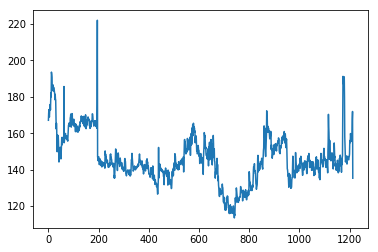

In [ ]:
plt.figure()
plt.plot(orig_tt[0,:,:].detach().numpy())
#plt.plot(pred_x[0,:,:].detach().numpy())
plt.show()

In [ ]:
latent_dim = 4
nhidden = 10
rnn_nhidden = 8
obs_dim = 1 # no of colums in original dataframe
nspiral = 1
# nsample = 1214
noise_std = 0.09

In [ ]:
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim, nhidden):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden,nhidden)   # outputs latent state of dim 4
        self.fc4 = nn.Linear(nhidden,nhidden)
        self.fc5 = nn.Linear(nhidden,latent_dim)
#         self.fc6 = nn.Linear(nhidden,latent_dim)
        self.nfe = 0

    def forward(self, t, x): # Note that forward pass has time t as input as well, as compared to RNN where the argument would be no. of neurons in hidden layers!
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        out = self.elu(out)
        out = self.fc4(out)
        out = self.elu(out)
        out = self.fc5(out)
#         out = self.elu(out)
#         out = self.fc6(out)
        return out

In [ ]:
# class LatentODEfunc(nn.Module):
#     def __init__(self,latent_dim,nhidden):
#         super(LatentODEfunc, self).__init__()      
#         self.lstm = nn.LSTM(latent_dim, nhidden)
#         # The linear layer that maps from hidden state space to tag space
#         self.hidden2tag = nn.Linear(nhidden, latent_dim)
#         self.nfe=0

#     def forward(self,t,x):
#         self.nfe+=1
#         lstm_out = self.lstm(x)
#         lstm_out = self.hidden2tag(lstm_out)
#         return lstm_out


In [ ]:
class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim, obs_dim, nhidden, nbatch):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2) #Note that we are outputing twice the size of latent dim, this will go in as qz0_mean and qz0_logvar ... see training loop

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1) ###
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch,self.nhidden)

In [ ]:
class Decoder(nn.Module):

    def __init__(self, latent_dim, obs_dim, nhidden):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
#         self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden,obs_dim)
#         self.fc3 = nn.Linear(nhidden,obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
#         out = self.relu(out)
#         out = self.fc3(out)
        return out


In [ ]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [ ]:
def log_normal_pdf(x, mean, logvar):
#     const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
#     const = torch.log(const)
#     return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))
    return -.5 * (logvar + (x - mean) ** 2. / torch.exp(logvar))


def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl

In [ ]:
torch.manual_seed(350)
func = LatentODEfunc(latent_dim, nhidden)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden,nspiral)
dec = Decoder(latent_dim, obs_dim, nhidden)

In [ ]:

params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = torch.optim.Adam(params, lr=0.01)
loss_meter = RunningAverageMeter()

In [ ]:
print(orig_tt.size())
print(orig_tt.size(1)) # total dataset size of spirals is 1000(256) spirals but each sampled spiral has 100(2) datapoints

h = rec.initHidden() # for recurrent nn
for t in reversed(range(orig_tt.size(1))):
        obs = orig_tt[:,t, :]
        out, h = rec.forward(obs, h) # init forward pass to start rnn

print(out.size(),h.size()) #weights


qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
epsilon = torch.randn(qz0_mean.size())
z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

print('z0 size = ', z0.size())
pred_z = odeint_adjoint(func, z0, orig_ts,method='euler')
print('pred_z size = ', pred_z.size())
pred_z = pred_z.permute(1, 0, 2)
print('pred_z size after changing axes = ',pred_z.size())
pred_x = dec(pred_z)
print('pred_x size = ',pred_x.size())

torch.Size([1, 1214, 1])
1214
torch.Size([1, 8]) torch.Size([1, 8])
z0 size =  torch.Size([1, 4])
pred_z size =  torch.Size([1214, 1, 4])
pred_z size after changing axes =  torch.Size([1, 1214, 4])
pred_x size =  torch.Size([1, 1214, 1])


In [ ]:
orig_ts.shape

torch.Size([1214])

Iter: 1, running avg elbo: -1058045194928128.0000
Iter: 2, running avg elbo: -1047464776471797.7500
Iter: 3, running avg elbo: -1036990172814190.1250
Iter: 4, running avg elbo: -1026620321356010.5000
Iter: 5, running avg elbo: -1016354172402894.5000
Iter: 6, running avg elbo: -1006190679075814.0000
Iter: 7, running avg elbo: -996128795978646.8750
Iter: 8, running avg elbo: -986167517783320.5000
Iter: 9, running avg elbo: -976305927783158.8750
Iter: 10, running avg elbo: -966543056847025.7500
Iter: 11, running avg elbo: -956877861229273.0000
Iter: 12, running avg elbo: -947309272959554.3750
Iter: 13, running avg elbo: -937836275301467.3750
Iter: 14, running avg elbo: -928457940213154.2500
Iter: 15, running avg elbo: -919173369080199.7500
Iter: 16, running avg elbo: -909981652937267.2500
Iter: 17, running avg elbo: -900881850482735.0000
Iter: 18, running avg elbo: -891873040143904.3750
Iter: 19, running avg elbo: -882954316146007.7500
Iter: 20, running avg elbo: -874124781882834.3750
Ite

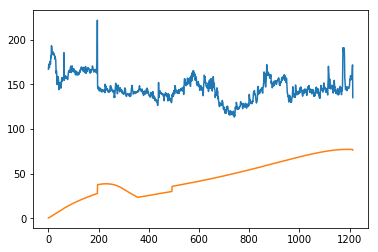


Iter: 31, running avg elbo: -782637448557092.2500
Iter: 32, running avg elbo: -774811080658208.1250
Iter: 33, running avg elbo: -767062976729180.5000
Iter: 34, running avg elbo: -759392354467003.6250
Iter: 35, running avg elbo: -751798438238459.7500
Iter: 36, running avg elbo: -744280460689407.0000
Iter: 37, running avg elbo: -736837662154658.1250
Iter: 38, running avg elbo: -729469291219213.2500
Iter: 39, running avg elbo: -722174604074378.6250
Iter: 40, running avg elbo: -714952863526009.2500
Iter: 41, running avg elbo: -707803339291440.0000
Iter: 42, running avg elbo: -700725309845831.8750
Iter: 43, running avg elbo: -693718060018879.3750
Iter: 44, running avg elbo: -686780882801671.7500
Iter: 45, running avg elbo: -679913077417100.5000
Iter: 46, running avg elbo: -673113950037768.2500
Iter: 47, running avg elbo: -666382813843759.1250
Iter: 48, running avg elbo: -659718988939100.7500
Iter: 49, running avg elbo: -653121802226390.1250
Iter: 50, running avg elbo: -646590587249124.3750

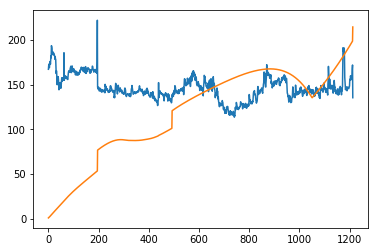


Iter: 51, running avg elbo: -640124684348443.0000
Iter: 52, running avg elbo: -633723440516149.0000
Iter: 53, running avg elbo: -627386209123156.5000
Iter: 54, running avg elbo: -621112349979817.0000
Iter: 55, running avg elbo: -614901229453737.6250
Iter: 56, running avg elbo: -608752219943120.2500
Iter: 57, running avg elbo: -602664700510369.3750
Iter: 58, running avg elbo: -596638056285692.1250
Iter: 59, running avg elbo: -590671678517838.5000
Iter: 60, running avg elbo: -584764964510063.6250
Iter: 61, running avg elbo: -578917317564259.0000
Iter: 62, running avg elbo: -573128147036038.7500
Iter: 63, running avg elbo: -567396868235100.6250
Iter: 64, running avg elbo: -561722902220651.6875
Iter: 65, running avg elbo: -556105675868707.2500
Iter: 66, running avg elbo: -550544621713710.7500
Iter: 67, running avg elbo: -545039178042568.6875
Iter: 68, running avg elbo: -539588788790224.9375
Iter: 69, running avg elbo: -534192903413945.0625
Iter: 70, running avg elbo: -528850976938234.5625

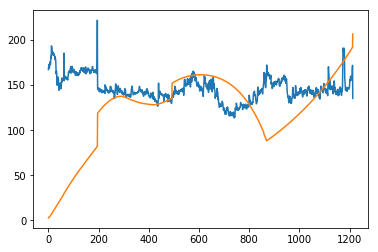


Iter: 101, running avg elbo: -387279415427791.6875
Iter: 102, running avg elbo: -383406623534193.2500
Iter: 103, running avg elbo: -379572559521466.6875
Iter: 104, running avg elbo: -375776836161640.3125
Iter: 105, running avg elbo: -372019070040590.2500
Iter: 106, running avg elbo: -368298881536332.5625
Iter: 107, running avg elbo: -364615894914272.7500
Iter: 108, running avg elbo: -360969738183592.0625
Iter: 109, running avg elbo: -357360042993495.5000
Iter: 110, running avg elbo: -353786444770162.0000
Iter: 111, running avg elbo: -350248582508305.8125
Iter: 112, running avg elbo: -346746098855289.9375
Iter: 113, running avg elbo: -343278640081660.4375
Iter: 114, running avg elbo: -339845855847361.8750
Iter: 115, running avg elbo: -336447399462944.4375
Iter: 116, running avg elbo: -333082927630452.2500
Iter: 117, running avg elbo: -329752100512474.1250
Iter: 118, running avg elbo: -326454581692226.0000
Iter: 119, running avg elbo: -323190038044353.5000
Iter: 120, running avg elbo: -

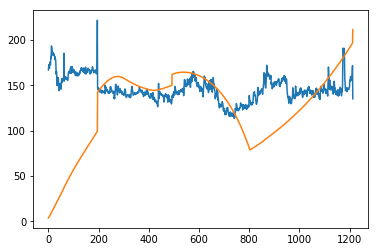


Iter: 151, running avg elbo: -234306480677788.9688
Iter: 152, running avg elbo: -231963418005147.6875
Iter: 153, running avg elbo: -229643785903537.0312
Iter: 154, running avg elbo: -227347350162366.6250
Iter: 155, running avg elbo: -225073878796239.9375
Iter: 156, running avg elbo: -222823142058189.3750
Iter: 157, running avg elbo: -220594912797699.7812
Iter: 158, running avg elbo: -218388965737612.5312
Iter: 159, running avg elbo: -216205078211981.8438
Iter: 160, running avg elbo: -214043029507753.4062
Iter: 161, running avg elbo: -211902601283908.0312
Iter: 162, running avg elbo: -209783577383576.9375
Iter: 163, running avg elbo: -207685743727901.6250
Iter: 164, running avg elbo: -205608888426355.2188
Iter: 165, running avg elbo: -203552801622500.1250
Iter: 166, running avg elbo: -201517275690389.2188
Iter: 167, running avg elbo: -199502105030655.0625
Iter: 168, running avg elbo: -197507086091644.5000
Iter: 169, running avg elbo: -195532017311976.3750
Iter: 170, running avg elbo: -

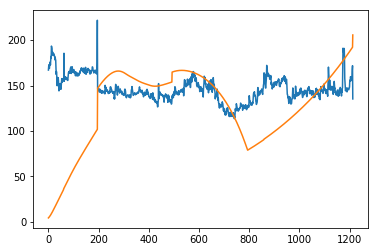


Iter: 201, running avg elbo: -141756924323961.4062
Iter: 202, running avg elbo: -140339357131299.3906
Iter: 203, running avg elbo: -138935965616386.7031
Iter: 204, running avg elbo: -137546607976457.5469
Iter: 205, running avg elbo: -136171143958325.6094
Iter: 206, running avg elbo: -134809434533666.8438
Iter: 207, running avg elbo: -133461342191304.0938
Iter: 208, running avg elbo: -132126730828370.4062
Iter: 209, running avg elbo: -130805465541966.3906
Iter: 210, running avg elbo: -129497412939757.7656
Iter: 211, running avg elbo: -128202440837178.9062
Iter: 212, running avg elbo: -126920418439670.7969
Iter: 213, running avg elbo: -125651216278450.2500
Iter: 214, running avg elbo: -124394706134088.3125
Iter: 215, running avg elbo: -123150761100416.8594
Iter: 216, running avg elbo: -121919255511093.4844
Iter: 217, running avg elbo: -120700064945847.6719
Iter: 218, running avg elbo: -119493066358525.8281
Iter: 219, running avg elbo: -118298137680957.6875
Iter: 220, running avg elbo: -

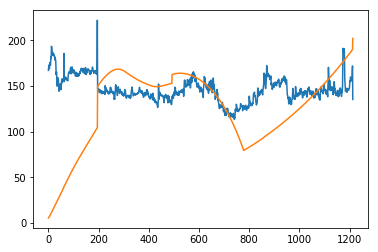


Iter: 251, running avg elbo: -85763878819508.5000
Iter: 252, running avg elbo: -84906242020328.2969
Iter: 253, running avg elbo: -84057181587758.1406
Iter: 254, running avg elbo: -83216611764497.5156
Iter: 255, running avg elbo: -82384447648203.9062
Iter: 256, running avg elbo: -81560605181301.5469
Iter: 257, running avg elbo: -80745001087231.8906
Iter: 258, running avg elbo: -79937553064024.3750
Iter: 259, running avg elbo: -79138179526841.8906
Iter: 260, running avg elbo: -78346799710915.5469
Iter: 261, running avg elbo: -77563333695606.0781
Iter: 262, running avg elbo: -76787702357963.1406
Iter: 263, running avg elbo: -76019827290946.3906
Iter: 264, running avg elbo: -75259631009275.9688
Iter: 265, running avg elbo: -74507036683219.6875
Iter: 266, running avg elbo: -73761968313037.7188
Iter: 267, running avg elbo: -73024350612273.2656
Iter: 268, running avg elbo: -72294109072019.6562
Iter: 269, running avg elbo: -71571169960784.7344
Iter: 270, running avg elbo: -70855460232946.8125

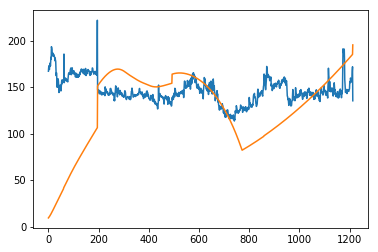


Iter: 301, running avg elbo: -51887744302980.1484
Iter: 302, running avg elbo: -51368868761780.9062
Iter: 303, running avg elbo: -50855181993842.6172
Iter: 304, running avg elbo: -50346632088816.5078
Iter: 305, running avg elbo: -49843167685927.0625
Iter: 306, running avg elbo: -49344737965791.4688
Iter: 307, running avg elbo: -48851292535998.1953
Iter: 308, running avg elbo: -48362781542147.8125
Iter: 309, running avg elbo: -47879155621974.9766
Iter: 310, running avg elbo: -47400365957278.1094
Iter: 311, running avg elbo: -46926364242370.1250
Iter: 312, running avg elbo: -46457102536304.0234
Iter: 313, running avg elbo: -45992533399454.2656
Iter: 314, running avg elbo: -45532610006400.1953
Iter: 315, running avg elbo: -45077285853018.7578
Iter: 316, running avg elbo: -44626514925733.6875
Iter: 317, running avg elbo: -44180251690657.6328
Iter: 318, running avg elbo: -43738451071062.2578
Iter: 319, running avg elbo: -43301068462046.6719
Iter: 320, running avg elbo: -42868059689035.1641

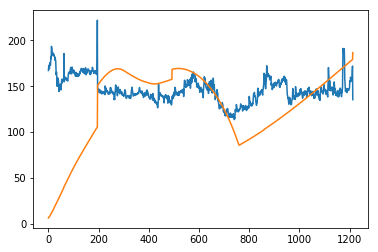


Iter: 351, running avg elbo: -31392474973381.0234
Iter: 352, running avg elbo: -31078552055566.8945
Iter: 353, running avg elbo: -30767768410702.4258
Iter: 354, running avg elbo: -30460092619532.5234
Iter: 355, running avg elbo: -30155493504167.9180
Iter: 356, running avg elbo: -29853940453710.0781
Iter: 357, running avg elbo: -29555402912625.7773
Iter: 358, running avg elbo: -29259850745389.2812
Iter: 359, running avg elbo: -28967254064707.8672
Iter: 360, running avg elbo: -28677583398147.5078
Iter: 361, running avg elbo: -28390809400673.8711
Iter: 362, running avg elbo: -28106903160876.4141
Iter: 363, running avg elbo: -27825835981603.0078
Iter: 364, running avg elbo: -27547579496211.4570
Iter: 365, running avg elbo: -27272105517857.9844
Iter: 366, running avg elbo: -26999386313813.6406
Iter: 367, running avg elbo: -26729394286949.5820
Iter: 368, running avg elbo: -26462102218146.0078
Iter: 369, running avg elbo: -26197483059585.9883
Iter: 370, running avg elbo: -25935510109024.5273

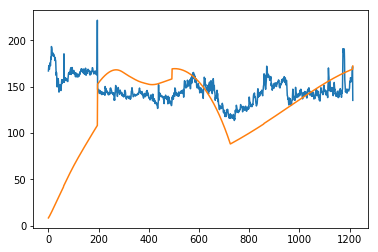


Iter: 401, running avg elbo: -18992709764981.7266
Iter: 402, running avg elbo: -18802784455422.4688
Iter: 403, running avg elbo: -18614758422665.0430
Iter: 404, running avg elbo: -18428612642212.4688
Iter: 405, running avg elbo: -18244328302570.9844
Iter: 406, running avg elbo: -18061886794935.9922
Iter: 407, running avg elbo: -17881269680818.4727
Iter: 408, running avg elbo: -17702458759655.8906
Iter: 409, running avg elbo: -17525435994312.7715
Iter: 410, running avg elbo: -17350183396150.7637
Iter: 411, running avg elbo: -17176683342537.8965
Iter: 412, running avg elbo: -17004918252340.6777
Iter: 413, running avg elbo: -16834870822320.6309
Iter: 414, running avg elbo: -16666523874259.1836
Iter: 415, running avg elbo: -16499860396801.7109
Iter: 416, running avg elbo: -16334863550853.6934
Iter: 417, running avg elbo: -16171516706951.0762
Iter: 418, running avg elbo: -16009803276532.4453
Iter: 419, running avg elbo: -15849707002196.0820
Iter: 420, running avg elbo: -15691211673976.5215

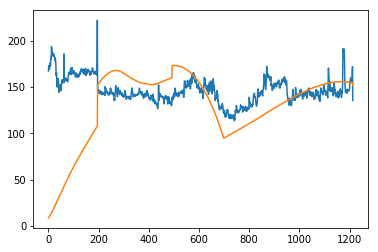


Iter: 451, running avg elbo: -11490772927609.3750
Iter: 452, running avg elbo: -11375866866412.4805
Iter: 453, running avg elbo: -11262109838218.9160
Iter: 454, running avg elbo: -11149490377187.7656
Iter: 455, running avg elbo: -11037997152907.8887
Iter: 456, running avg elbo: -10927618867974.4902
Iter: 457, running avg elbo: -10818344327166.7461
Iter: 458, running avg elbo: -10710162552346.1172
Iter: 459, running avg elbo: -10603062591387.7754
Iter: 460, running avg elbo: -10497033617821.7383
Iter: 461, running avg elbo: -10392064969429.6016
Iter: 462, running avg elbo: -10288145974989.7051
Iter: 463, running avg elbo: -10185266191755.1680
Iter: 464, running avg elbo: -10083415182420.9746
Iter: 465, running avg elbo: -9982582650282.5254
Iter: 466, running avg elbo: -9882758479526.2598
Iter: 467, running avg elbo: -9783932592159.4785
Iter: 468, running avg elbo: -9686094931542.3633
Iter: 469, running avg elbo: -9589235603877.0195
Iter: 470, running avg elbo: -9493344868593.6094
Iter:

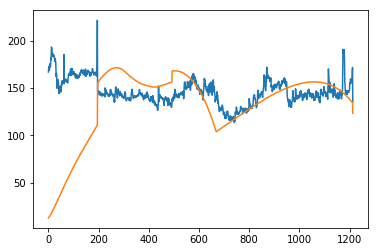


Iter: 501, running avg elbo: -6952051713685.2354
Iter: 502, running avg elbo: -6882532780009.6631
Iter: 503, running avg elbo: -6813709007975.0068
Iter: 504, running avg elbo: -6745573494569.4971
Iter: 505, running avg elbo: -6678119380926.2021
Iter: 506, running avg elbo: -6611339784061.4209
Iter: 507, running avg elbo: -6545227983962.0869
Iter: 508, running avg elbo: -6479777319181.5059
Iter: 509, running avg elbo: -6414981148192.4102
Iter: 510, running avg elbo: -6350832890715.9268
Iter: 511, running avg elbo: -6287326137773.5674
Iter: 512, running avg elbo: -6224454452734.0723
Iter: 513, running avg elbo: -6162211477541.7715
Iter: 514, running avg elbo: -6100590939777.0732
Iter: 515, running avg elbo: -6039586565647.1426
Iter: 516, running avg elbo: -5979192312322.1904
Iter: 517, running avg elbo: -5919401972309.5283
Iter: 518, running avg elbo: -5860209534136.0322
Iter: 519, running avg elbo: -5801609060933.3916
Iter: 520, running avg elbo: -5743594581798.6172
Iter: 521, running 

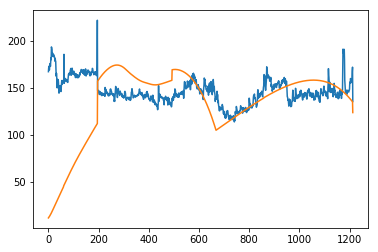


Iter: 551, running avg elbo: -4206096330641.9204
Iter: 552, running avg elbo: -4164036933423.6611
Iter: 553, running avg elbo: -4122398114824.1445
Iter: 554, running avg elbo: -4081175725913.3428
Iter: 555, running avg elbo: -4040365592335.8096
Iter: 556, running avg elbo: -3999963502667.0117
Iter: 557, running avg elbo: -3959965449880.8218
Iter: 558, running avg elbo: -3920367373346.3335
Iter: 559, running avg elbo: -3881165293176.0703
Iter: 560, running avg elbo: -3842355186430.3896
Iter: 561, running avg elbo: -3803933253692.9658
Iter: 562, running avg elbo: -3765895480335.5562
Iter: 563, running avg elbo: -3728238085789.8008
Iter: 564, running avg elbo: -3690957282664.8628
Iter: 565, running avg elbo: -3654049269506.6943
Iter: 566, running avg elbo: -3617510333600.4272
Iter: 567, running avg elbo: -3581336814102.8228
Iter: 568, running avg elbo: -3545525032989.7944
Iter: 569, running avg elbo: -3510071342461.0166
Iter: 570, running avg elbo: -3474972213685.6860
Iter: 571, running 

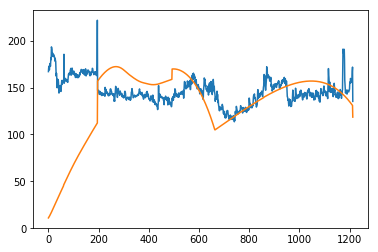


Iter: 601, running avg elbo: -2544775764606.0874
Iter: 602, running avg elbo: -2519329581740.0264
Iter: 603, running avg elbo: -2494137809280.2261
Iter: 604, running avg elbo: -2469197990848.7036
Iter: 605, running avg elbo: -2444507575606.9370
Iter: 606, running avg elbo: -2420064118475.8276
Iter: 607, running avg elbo: -2395865066024.5093
Iter: 608, running avg elbo: -2371907949657.0640
Iter: 609, running avg elbo: -2348190430170.8931
Iter: 610, running avg elbo: -2324710157114.4639
Iter: 611, running avg elbo: -2301464602228.7593
Iter: 612, running avg elbo: -2278451516436.2314
Iter: 613, running avg elbo: -2255668610265.6289
Iter: 614, running avg elbo: -2233113575218.1729
Iter: 615, running avg elbo: -2210783975765.6714
Iter: 616, running avg elbo: -2188677672043.2146
Iter: 617, running avg elbo: -2166792569508.3826
Iter: 618, running avg elbo: -2145126301227.6987
Iter: 619, running avg elbo: -2123676543581.5017
Iter: 620, running avg elbo: -2102441452529.2068
Iter: 621, running 

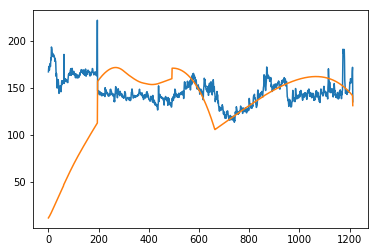


Iter: 651, running avg elbo: -1539667108194.9780
Iter: 652, running avg elbo: -1524271986543.4282
Iter: 653, running avg elbo: -1509030791579.2739
Iter: 654, running avg elbo: -1493942055675.3213
Iter: 655, running avg elbo: -1479004212854.4082
Iter: 656, running avg elbo: -1464215710232.7439
Iter: 657, running avg elbo: -1449575118566.2566
Iter: 658, running avg elbo: -1435080922051.9541
Iter: 659, running avg elbo: -1420731693790.3145
Iter: 660, running avg elbo: -1406525912204.0913
Iter: 661, running avg elbo: -1392462179134.8503
Iter: 662, running avg elbo: -1378539090794.2217
Iter: 663, running avg elbo: -1364755258440.8396
Iter: 664, running avg elbo: -1351109292582.6711
Iter: 665, running avg elbo: -1337599725011.2444
Iter: 666, running avg elbo: -1324225256375.3718
Iter: 667, running avg elbo: -1310984552973.3782
Iter: 668, running avg elbo: -1297876286847.8042
Iter: 669, running avg elbo: -1284899086009.2461
Iter: 670, running avg elbo: -1272051646835.2336
Iter: 671, running 

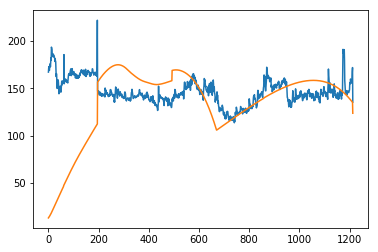


Iter: 701, running avg elbo: -931568912950.2651
Iter: 702, running avg elbo: -922254706685.7224
Iter: 703, running avg elbo: -913033665822.7052
Iter: 704, running avg elbo: -903904903455.0382
Iter: 705, running avg elbo: -894867403728.9678
Iter: 706, running avg elbo: -885920289766.2382
Iter: 707, running avg elbo: -877062620143.6158
Iter: 708, running avg elbo: -868293551699.6196
Iter: 709, running avg elbo: -859612212454.4634
Iter: 710, running avg elbo: -851017633577.5988
Iter: 711, running avg elbo: -842509018120.8628
Iter: 712, running avg elbo: -834085440719.3342
Iter: 713, running avg elbo: -825746141209.9009
Iter: 714, running avg elbo: -817490260369.1619
Iter: 715, running avg elbo: -809316928475.5502
Iter: 716, running avg elbo: -801225275402.1547
Iter: 717, running avg elbo: -793214568993.2531
Iter: 718, running avg elbo: -785283998200.7605
Iter: 719, running avg elbo: -777432718808.1929
Iter: 720, running avg elbo: -769659968911.3109
Iter: 721, running avg elbo: -761964866

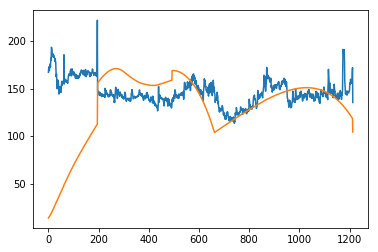


Iter: 751, running avg elbo: -563665283875.7024
Iter: 752, running avg elbo: -558030140344.9453
Iter: 753, running avg elbo: -552451338338.1359
Iter: 754, running avg elbo: -546928340038.5945
Iter: 755, running avg elbo: -541460572399.3286
Iter: 756, running avg elbo: -536047477005.8953
Iter: 757, running avg elbo: -530688545911.0364
Iter: 758, running avg elbo: -525383159218.1660
Iter: 759, running avg elbo: -520130813959.7444
Iter: 760, running avg elbo: -514931000779.8269
Iter: 761, running avg elbo: -509783213288.0286
Iter: 762, running avg elbo: -504686843884.5883
Iter: 763, running avg elbo: -499641482313.2625
Iter: 764, running avg elbo: -494646577919.7298
Iter: 765, running avg elbo: -489701595100.3725
Iter: 766, running avg elbo: -484806077101.6888
Iter: 767, running avg elbo: -479959490157.7119
Iter: 768, running avg elbo: -475161380059.0147
Iter: 769, running avg elbo: -470411316423.8646
Iter: 770, running avg elbo: -465708714734.0259
Iter: 771, running avg elbo: -461053142

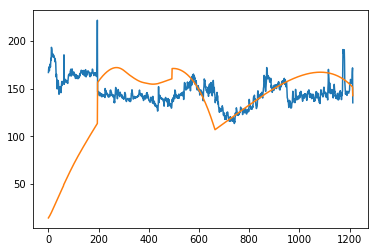


Iter: 801, running avg elbo: -341080359676.3435
Iter: 802, running avg elbo: -337671037709.9801
Iter: 803, running avg elbo: -334295828065.8403
Iter: 804, running avg elbo: -330954369158.1420
Iter: 805, running avg elbo: -327646352928.4805
Iter: 806, running avg elbo: -324371404429.7557
Iter: 807, running avg elbo: -321129198923.8582
Iter: 808, running avg elbo: -317919384642.9396
Iter: 809, running avg elbo: -314741715064.8303
Iter: 810, running avg elbo: -311595834116.5820
Iter: 811, running avg elbo: -308481402837.0161
Iter: 812, running avg elbo: -305398090291.5259
Iter: 813, running avg elbo: -302345630475.6506
Iter: 814, running avg elbo: -299323672480.8141
Iter: 815, running avg elbo: -296331939788.8059
Iter: 816, running avg elbo: -293370101718.1179
Iter: 817, running avg elbo: -290437941610.8567
Iter: 818, running avg elbo: -287535102489.3081
Iter: 819, running avg elbo: -284661308519.2950
Iter: 820, running avg elbo: -281816173143.7021
Iter: 821, running avg elbo: -278999487

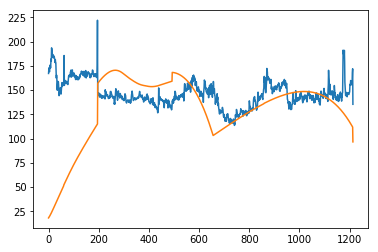


Iter: 851, running avg elbo: -206414785173.7116
Iter: 852, running avg elbo: -204352128956.0544
Iter: 853, running avg elbo: -202310085738.6539
Iter: 854, running avg elbo: -200288454043.0274
Iter: 855, running avg elbo: -198287089039.5571
Iter: 856, running avg elbo: -196305785155.7215
Iter: 857, running avg elbo: -194344259615.2043
Iter: 858, running avg elbo: -192402330812.0123
Iter: 859, running avg elbo: -190479801672.2122
Iter: 860, running avg elbo: -188576488439.9700
Iter: 861, running avg elbo: -186692212207.4103
Iter: 862, running avg elbo: -184826771632.6962
Iter: 863, running avg elbo: -182980014327.0893
Iter: 864, running avg elbo: -181151694261.0984
Iter: 865, running avg elbo: -179341645141.6874
Iter: 866, running avg elbo: -177549669183.5505
Iter: 867, running avg elbo: -175775664503.2350
Iter: 868, running avg elbo: -174019319384.2826
Iter: 869, running avg elbo: -172280587157.7998
Iter: 870, running avg elbo: -170559247888.7818
Iter: 871, running avg elbo: -168855071

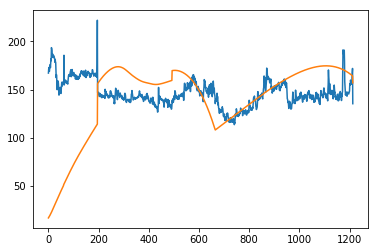


Iter: 901, running avg elbo: -124940397628.2109
Iter: 902, running avg elbo: -123692445762.0088
Iter: 903, running avg elbo: -122456967594.1487
Iter: 904, running avg elbo: -121233841507.9672
Iter: 905, running avg elbo: -120022979746.9676
Iter: 906, running avg elbo: -118824226089.8179
Iter: 907, running avg elbo: -117637456279.7997
Iter: 908, running avg elbo: -116462496309.6417
Iter: 909, running avg elbo: -115299331907.9853
Iter: 910, running avg elbo: -114147784462.8254
Iter: 911, running avg elbo: -113007822932.1172
Iter: 912, running avg elbo: -111879158418.3160
Iter: 913, running avg elbo: -110761812743.5729
Iter: 914, running avg elbo: -109655641157.0971
Iter: 915, running avg elbo: -108560538965.6862
Iter: 916, running avg elbo: -107476372711.3893
Iter: 917, running avg elbo: -106403061432.5954
Iter: 918, running avg elbo: -105340504694.9095
Iter: 919, running avg elbo: -104288496047.8004
Iter: 920, running avg elbo: -103247062321.7224
Iter: 921, running avg elbo: -102216038

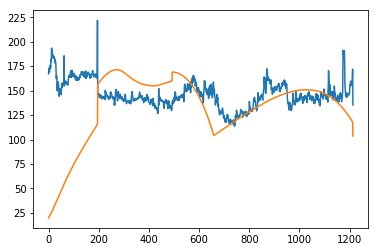


Iter: 951, running avg elbo: -75646824539.6323
Iter: 952, running avg elbo: -74891850994.7160
Iter: 953, running avg elbo: -74144560401.5689
Iter: 954, running avg elbo: -73404744067.6332
Iter: 955, running avg elbo: -72672279751.9169
Iter: 956, running avg elbo: -71947100582.8777
Iter: 957, running avg elbo: -71229090780.7289
Iter: 958, running avg elbo: -70518208143.6416
Iter: 959, running avg elbo: -69814464917.0852
Iter: 960, running avg elbo: -69117787665.5143
Iter: 961, running avg elbo: -68428097306.9392
Iter: 962, running avg elbo: -67745339997.0698
Iter: 963, running avg elbo: -67069381544.4591
Iter: 964, running avg elbo: -66400128376.6945
Iter: 965, running avg elbo: -65737573344.7676
Iter: 966, running avg elbo: -65081676005.7199
Iter: 967, running avg elbo: -64432394926.1427
Iter: 968, running avg elbo: -63789589668.4013
Iter: 969, running avg elbo: -63153097983.2373
Iter: 970, running avg elbo: -62523002037.8049
Iter: 971, running avg elbo: -61899263283.0268
Iter: 972, r

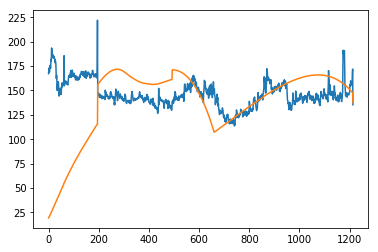


Iter: 1001, running avg elbo: -45823810905.8879
Iter: 1002, running avg elbo: -45366965303.2291
Iter: 1003, running avg elbo: -44914731860.2768
Iter: 1004, running avg elbo: -44467054517.8340
Iter: 1005, running avg elbo: -44023802021.4557
Iter: 1006, running avg elbo: -43584973809.8811
Iter: 1007, running avg elbo: -43150530705.2223
Iter: 1008, running avg elbo: -42720429836.4101
Iter: 1009, running avg elbo: -42294675093.7260
Iter: 1010, running avg elbo: -41873214345.1887
Iter: 1011, running avg elbo: -41455911004.9368
Iter: 1012, running avg elbo: -41042743281.2875
Iter: 1013, running avg elbo: -40633667350.7146
Iter: 1014, running avg elbo: -40228719680.7274
Iter: 1015, running avg elbo: -39827859681.0402
Iter: 1016, running avg elbo: -39431041687.9098
Iter: 1017, running avg elbo: -39038193986.5507
Iter: 1018, running avg elbo: -38649230691.0052
Iter: 1019, running avg elbo: -38264139438.9751
Iter: 1020, running avg elbo: -37882899017.2254
Iter: 1021, running avg elbo: -37505525

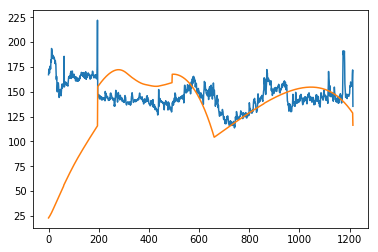


Iter: 1051, running avg elbo: -27779219856.4795
Iter: 1052, running avg elbo: -27502810738.2347
Iter: 1053, running avg elbo: -27229144830.3724
Iter: 1054, running avg elbo: -26958216675.3487
Iter: 1055, running avg elbo: -26689990877.2352
Iter: 1056, running avg elbo: -26424453719.6628
Iter: 1057, running avg elbo: -26161542346.7062
Iter: 1058, running avg elbo: -25901226260.1191
Iter: 1059, running avg elbo: -25643544946.3179
Iter: 1060, running avg elbo: -25388434557.9748
Iter: 1061, running avg elbo: -25135909593.9950
Iter: 1062, running avg elbo: -24885920438.8551
Iter: 1063, running avg elbo: -24638408769.5065
Iter: 1064, running avg elbo: -24393420029.1715
Iter: 1065, running avg elbo: -24150832900.5597
Iter: 1066, running avg elbo: -23910660028.3541
Iter: 1067, running avg elbo: -23672904147.5906
Iter: 1068, running avg elbo: -23437538271.5547
Iter: 1069, running avg elbo: -23204512898.2791
Iter: 1070, running avg elbo: -22973810774.2564
Iter: 1071, running avg elbo: -22745456

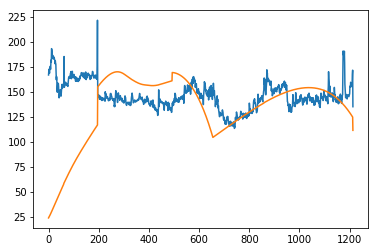


Iter: 1101, running avg elbo: -16859868245.1772
Iter: 1102, running avg elbo: -16692607384.2454
Iter: 1103, running avg elbo: -16527005167.6829
Iter: 1104, running avg elbo: -16363064143.2861
Iter: 1105, running avg elbo: -16200754741.9332
Iter: 1106, running avg elbo: -16040083506.0339
Iter: 1107, running avg elbo: -15881023889.3736
Iter: 1108, running avg elbo: -15723515710.1598
Iter: 1109, running avg elbo: -15567609772.8982
Iter: 1110, running avg elbo: -15413237100.6893
Iter: 1111, running avg elbo: -15260433562.7224
Iter: 1112, running avg elbo: -15109142379.8951
Iter: 1113, running avg elbo: -14959372142.5762
Iter: 1114, running avg elbo: -14811068694.6704
Iter: 1115, running avg elbo: -14664253542.5237
Iter: 1116, running avg elbo: -14518930634.6185
Iter: 1117, running avg elbo: -14375088333.3923
Iter: 1118, running avg elbo: -14232653816.2184
Iter: 1119, running avg elbo: -14091657323.1762
Iter: 1120, running avg elbo: -13952088007.5444
Iter: 1121, running avg elbo: -13813861

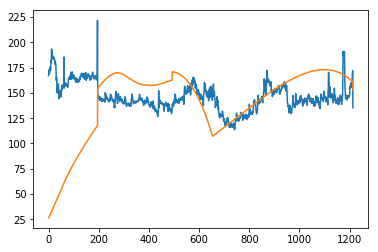


Iter: 1151, running avg elbo: -10252718659.6988
Iter: 1152, running avg elbo: -10151503807.5818
Iter: 1153, running avg elbo: -10051274272.5460
Iter: 1154, running avg elbo: -9952056819.8205
Iter: 1155, running avg elbo: -9853841867.6223
Iter: 1156, running avg elbo: -9756609340.2261
Iter: 1157, running avg elbo: -9660324481.7838
Iter: 1158, running avg elbo: -9565012230.0060
Iter: 1159, running avg elbo: -9470635039.7059
Iter: 1160, running avg elbo: -9377242397.6289
Iter: 1161, running avg elbo: -9284814780.2126
Iter: 1162, running avg elbo: -9193376058.8104
Iter: 1163, running avg elbo: -9102823261.1023
Iter: 1164, running avg elbo: -9013128976.1713
Iter: 1165, running avg elbo: -8924300297.4496
Iter: 1166, running avg elbo: -8836324121.8351
Iter: 1167, running avg elbo: -8749215359.0968
Iter: 1168, running avg elbo: -8663030755.8258
Iter: 1169, running avg elbo: -8577677110.1075
Iter: 1170, running avg elbo: -8493133673.6465
Iter: 1171, running avg elbo: -8409470267.7100
Iter: 117

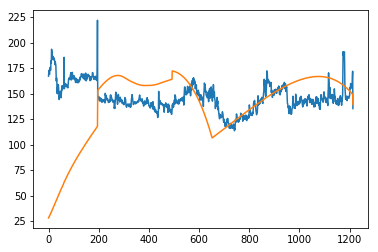


Iter: 1201, running avg elbo: -6253729607.7450
Iter: 1202, running avg elbo: -6192450965.7475
Iter: 1203, running avg elbo: -6131793322.2501
Iter: 1204, running avg elbo: -6071707885.8276
Iter: 1205, running avg elbo: -6012240838.0093
Iter: 1206, running avg elbo: -5953422538.3492
Iter: 1207, running avg elbo: -5895160206.8057
Iter: 1208, running avg elbo: -5837494154.7376
Iter: 1209, running avg elbo: -5780355564.0703
Iter: 1210, running avg elbo: -5723818865.6296
Iter: 1211, running avg elbo: -5667924037.2933
Iter: 1212, running avg elbo: -5612561923.4803
Iter: 1213, running avg elbo: -5557716800.8855
Iter: 1214, running avg elbo: -5503369863.7567
Iter: 1215, running avg elbo: -5449599859.1191
Iter: 1216, running avg elbo: -5396412237.3279
Iter: 1217, running avg elbo: -5343759439.5146
Iter: 1218, running avg elbo: -5291586179.6795
Iter: 1219, running avg elbo: -5239901026.1227
Iter: 1220, running avg elbo: -5188737933.7015
Iter: 1221, running avg elbo: -5138118967.4045
Iter: 1222, 

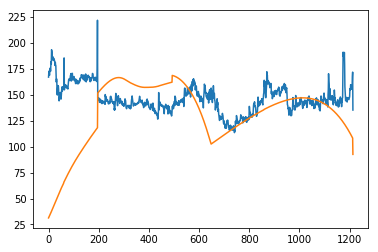


Iter: 1251, running avg elbo: -3833080655.4576
Iter: 1252, running avg elbo: -3795995330.1830
Iter: 1253, running avg elbo: -3759231260.6412
Iter: 1254, running avg elbo: -3722846585.7148
Iter: 1255, running avg elbo: -3686844816.9776
Iter: 1256, running avg elbo: -3651274267.0478
Iter: 1257, running avg elbo: -3616068368.0574
Iter: 1258, running avg elbo: -3581187381.1768
Iter: 1259, running avg elbo: -3546613994.8050
Iter: 1260, running avg elbo: -3512329215.0970
Iter: 1261, running avg elbo: -3478379601.8260
Iter: 1262, running avg elbo: -3444794846.6877
Iter: 1263, running avg elbo: -3411570214.7809
Iter: 1264, running avg elbo: -3378697407.9930
Iter: 1265, running avg elbo: -3346123929.2731
Iter: 1266, running avg elbo: -3313871807.9004
Iter: 1267, running avg elbo: -3281914232.5414
Iter: 1268, running avg elbo: -3250269950.2160
Iter: 1269, running avg elbo: -3218952635.7538
Iter: 1270, running avg elbo: -3187908328.7563
Iter: 1271, running avg elbo: -3157201218.1087
Iter: 1272, 

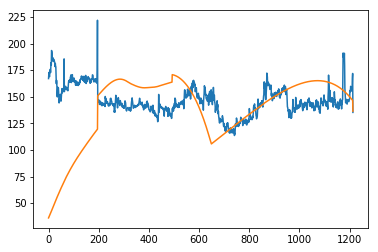


Iter: 1301, running avg elbo: -2365920138.6034
Iter: 1302, running avg elbo: -2343406527.6174
Iter: 1303, running avg elbo: -2321099563.3012
Iter: 1304, running avg elbo: -2299023998.5482
Iter: 1305, running avg elbo: -2277177836.1627
Iter: 1306, running avg elbo: -2255549640.4411
Iter: 1307, running avg elbo: -2234131650.8367
Iter: 1308, running avg elbo: -2212940066.9683
Iter: 1309, running avg elbo: -2191963105.7386
Iter: 1310, running avg elbo: -2171207405.0012
Iter: 1311, running avg elbo: -2150626862.5512
Iter: 1312, running avg elbo: -2130254552.4857
Iter: 1313, running avg elbo: -2110041463.9209
Iter: 1314, running avg elbo: -2090059709.0416
Iter: 1315, running avg elbo: -2070246629.7112
Iter: 1316, running avg elbo: -2050672710.6941
Iter: 1317, running avg elbo: -2031299491.6672
Iter: 1318, running avg elbo: -2012134875.3105
Iter: 1319, running avg elbo: -1993148498.5574
Iter: 1320, running avg elbo: -1974321119.9718
Iter: 1321, running avg elbo: -1955728634.9321
Iter: 1322, 

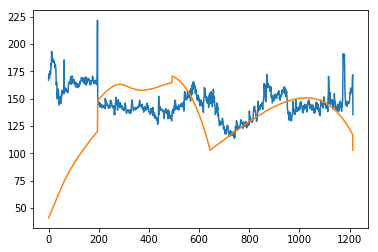


Iter: 1351, running avg elbo: -1475744213.8809
Iter: 1352, running avg elbo: -1462038998.0621
Iter: 1353, running avg elbo: -1448493743.8415
Iter: 1354, running avg elbo: -1435071164.5631
Iter: 1355, running avg elbo: -1421809340.9174
Iter: 1356, running avg elbo: -1408654387.1883
Iter: 1357, running avg elbo: -1395598293.5564
Iter: 1358, running avg elbo: -1382715184.5408
Iter: 1359, running avg elbo: -1369976049.9754
Iter: 1360, running avg elbo: -1357346184.7556
Iter: 1361, running avg elbo: -1344833430.1081
Iter: 1362, running avg elbo: -1332458487.1670
Iter: 1363, running avg elbo: -1320180228.2153
Iter: 1364, running avg elbo: -1308052890.3332
Iter: 1365, running avg elbo: -1296029146.1499
Iter: 1366, running avg elbo: -1284113935.9684
Iter: 1367, running avg elbo: -1272356947.5687
Iter: 1368, running avg elbo: -1260679917.2930
Iter: 1369, running avg elbo: -1249132760.7601
Iter: 1370, running avg elbo: -1237686592.3525
Iter: 1371, running avg elbo: -1226354620.0289
Iter: 1372, 

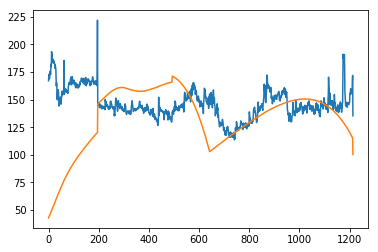


Iter: 1401, running avg elbo: -934097833.5360
Iter: 1402, running avg elbo: -925770185.6807
Iter: 1403, running avg elbo: -917522218.2239
Iter: 1404, running avg elbo: -909351107.3216
Iter: 1405, running avg elbo: -901273647.6884
Iter: 1406, running avg elbo: -893262299.4515
Iter: 1407, running avg elbo: -885328365.3370
Iter: 1408, running avg elbo: -877450251.7636
Iter: 1409, running avg elbo: -869663167.8860
Iter: 1410, running avg elbo: -861956556.6071
Iter: 1411, running avg elbo: -854329467.3611
Iter: 1412, running avg elbo: -846775052.7675
Iter: 1413, running avg elbo: -839282574.3198
Iter: 1414, running avg elbo: -831842110.0966
Iter: 1415, running avg elbo: -824513575.0756
Iter: 1416, running avg elbo: -817243962.6049
Iter: 1417, running avg elbo: -810054523.7788
Iter: 1418, running avg elbo: -802913132.1410
Iter: 1419, running avg elbo: -795858070.4196
Iter: 1420, running avg elbo: -788877844.4354
Iter: 1421, running avg elbo: -781964544.0711
Iter: 1422, running avg elbo: -77

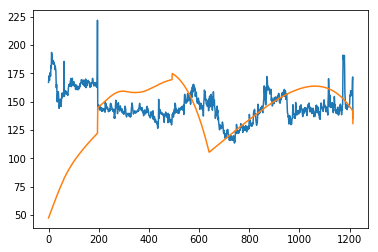


Iter: 1451, running avg elbo: -603400721.0099
Iter: 1452, running avg elbo: -598395634.9198
Iter: 1453, running avg elbo: -593468490.0906
Iter: 1454, running avg elbo: -588612841.4297
Iter: 1455, running avg elbo: -583762970.1354
Iter: 1456, running avg elbo: -578908532.1141
Iter: 1457, running avg elbo: -574068296.7129
Iter: 1458, running avg elbo: -569256557.9858
Iter: 1459, running avg elbo: -564490895.6859
Iter: 1460, running avg elbo: -559794240.1691
Iter: 1461, running avg elbo: -555209187.9274
Iter: 1462, running avg elbo: -550685499.9681
Iter: 1463, running avg elbo: -546155088.6484
Iter: 1464, running avg elbo: -541637810.8020
Iter: 1465, running avg elbo: -537106604.3739
Iter: 1466, running avg elbo: -532659953.2102
Iter: 1467, running avg elbo: -528289031.5181
Iter: 1468, running avg elbo: -524044737.2029
Iter: 1469, running avg elbo: -519837833.8309
Iter: 1470, running avg elbo: -515707149.4926
Iter: 1471, running avg elbo: -511576341.5177
Iter: 1472, running avg elbo: -50

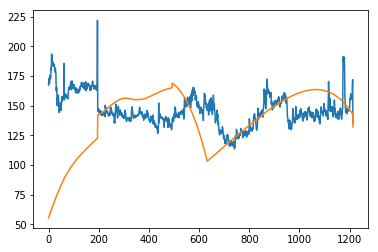


Iter: 1501, running avg elbo: -401811743.1068
Iter: 1502, running avg elbo: -398638277.9158
Iter: 1503, running avg elbo: -395504972.0966
Iter: 1504, running avg elbo: -392389760.7757
Iter: 1505, running avg elbo: -389296267.8879
Iter: 1506, running avg elbo: -386253610.1690
Iter: 1507, running avg elbo: -383245320.3073
Iter: 1508, running avg elbo: -380249298.9443
Iter: 1509, running avg elbo: -377276702.0348
Iter: 1510, running avg elbo: -374353018.2145
Iter: 1511, running avg elbo: -371443828.5923
Iter: 1512, running avg elbo: -368572631.9864
Iter: 1513, running avg elbo: -365721297.2665
Iter: 1514, running avg elbo: -362895010.7739
Iter: 1515, running avg elbo: -360109012.1861
Iter: 1516, running avg elbo: -357329897.0243
Iter: 1517, running avg elbo: -354594415.8940
Iter: 1518, running avg elbo: -351864632.5351
Iter: 1519, running avg elbo: -349152404.6097
Iter: 1520, running avg elbo: -346525881.6036
Iter: 1521, running avg elbo: -343953021.1076
Iter: 1522, running avg elbo: -34

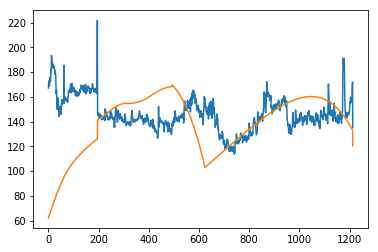


Iter: 1551, running avg elbo: -275074129.2832
Iter: 1552, running avg elbo: -273095116.1504
Iter: 1553, running avg elbo: -271139198.9089
Iter: 1554, running avg elbo: -269198423.3998
Iter: 1555, running avg elbo: -267246828.1258
Iter: 1556, running avg elbo: -265339345.1246
Iter: 1557, running avg elbo: -263428598.8733
Iter: 1558, running avg elbo: -261568489.7646
Iter: 1559, running avg elbo: -259750061.6669
Iter: 1560, running avg elbo: -257938352.4903
Iter: 1561, running avg elbo: -256123944.5654
Iter: 1562, running avg elbo: -254308603.4397
Iter: 1563, running avg elbo: -252520433.2453
Iter: 1564, running avg elbo: -250774435.6329
Iter: 1565, running avg elbo: -249038431.5965
Iter: 1566, running avg elbo: -247291185.1206
Iter: 1567, running avg elbo: -245549078.7894
Iter: 1568, running avg elbo: -243847063.4415
Iter: 1569, running avg elbo: -242167473.4471
Iter: 1570, running avg elbo: -240478823.9926
Iter: 1571, running avg elbo: -238809037.4327
Iter: 1572, running avg elbo: -23

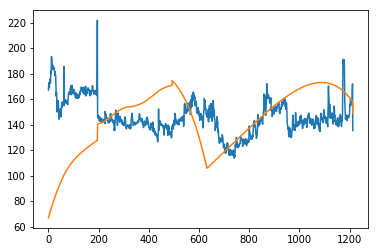


Iter: 1601, running avg elbo: -195340995.8135
Iter: 1602, running avg elbo: -194142350.3354
Iter: 1603, running avg elbo: -192914313.7920
Iter: 1604, running avg elbo: -191675858.5741
Iter: 1605, running avg elbo: -190446228.8684
Iter: 1606, running avg elbo: -189251735.4597
Iter: 1607, running avg elbo: -188069210.1051
Iter: 1608, running avg elbo: -186879451.7640
Iter: 1609, running avg elbo: -185683044.4464
Iter: 1610, running avg elbo: -184512432.8019
Iter: 1611, running avg elbo: -183363810.7939
Iter: 1612, running avg elbo: -182231329.3260
Iter: 1613, running avg elbo: -181083051.8727
Iter: 1614, running avg elbo: -179934947.1940
Iter: 1615, running avg elbo: -178817428.9221
Iter: 1616, running avg elbo: -177727370.4728
Iter: 1617, running avg elbo: -176639121.4881
Iter: 1618, running avg elbo: -175537765.9932
Iter: 1619, running avg elbo: -174450508.6533
Iter: 1620, running avg elbo: -173358222.7268
Iter: 1621, running avg elbo: -172297154.5795
Iter: 1622, running avg elbo: -17

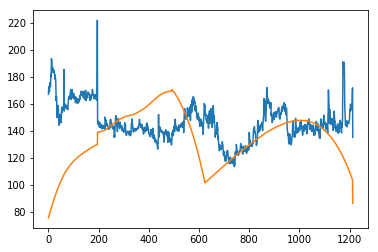


Iter: 1651, running avg elbo: -144187634.4419
Iter: 1652, running avg elbo: -143394254.2975
Iter: 1653, running avg elbo: -142584153.0345
Iter: 1654, running avg elbo: -141783078.6642
Iter: 1655, running avg elbo: -141015326.7975
Iter: 1656, running avg elbo: -140287881.7696
Iter: 1657, running avg elbo: -139551895.3519
Iter: 1658, running avg elbo: -138808462.1983
Iter: 1659, running avg elbo: -138027202.9764
Iter: 1660, running avg elbo: -137237154.3066
Iter: 1661, running avg elbo: -136496602.6035
Iter: 1662, running avg elbo: -135779061.0575
Iter: 1663, running avg elbo: -135045181.2869
Iter: 1664, running avg elbo: -134295201.7541
Iter: 1665, running avg elbo: -133548200.0565
Iter: 1666, running avg elbo: -132813257.6559
Iter: 1667, running avg elbo: -132095013.4794
Iter: 1668, running avg elbo: -131367878.0646
Iter: 1669, running avg elbo: -130655541.2039
Iter: 1670, running avg elbo: -129946042.5919
Iter: 1671, running avg elbo: -129245593.6060
Iter: 1672, running avg elbo: -12

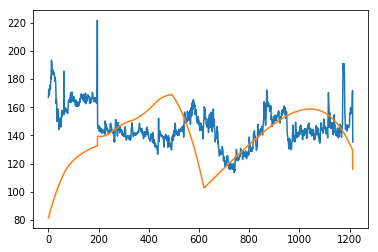


Iter: 1701, running avg elbo: -110390054.8684
Iter: 1702, running avg elbo: -109820809.8797
Iter: 1703, running avg elbo: -109278089.4609
Iter: 1704, running avg elbo: -108735832.0463
Iter: 1705, running avg elbo: -108193327.4859
Iter: 1706, running avg elbo: -107651105.5310
Iter: 1707, running avg elbo: -107126517.6757
Iter: 1708, running avg elbo: -106600643.4589
Iter: 1709, running avg elbo: -106069372.9844
Iter: 1710, running avg elbo: -105555358.2945
Iter: 1711, running avg elbo: -105045045.6316
Iter: 1712, running avg elbo: -104536040.0552
Iter: 1713, running avg elbo: -104034126.0947
Iter: 1714, running avg elbo: -103540024.1937
Iter: 1715, running avg elbo: -103036127.8318
Iter: 1716, running avg elbo: -102530404.1535
Iter: 1717, running avg elbo: -102035000.7920
Iter: 1718, running avg elbo: -101549471.9040
Iter: 1719, running avg elbo: -101068150.2250
Iter: 1720, running avg elbo: -100586339.1627
Iter: 1721, running avg elbo: -100101554.8111
Iter: 1722, running avg elbo: -99

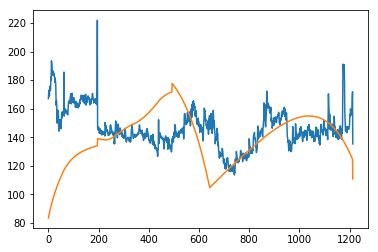


Iter: 1751, running avg elbo: -87404310.7165
Iter: 1752, running avg elbo: -87008804.6893
Iter: 1753, running avg elbo: -86621635.2825
Iter: 1754, running avg elbo: -86234790.8496
Iter: 1755, running avg elbo: -85848807.9011
Iter: 1756, running avg elbo: -85478781.6221
Iter: 1757, running avg elbo: -85117645.4859
Iter: 1758, running avg elbo: -84757594.7110
Iter: 1759, running avg elbo: -84394118.2839
Iter: 1760, running avg elbo: -84029637.3811
Iter: 1761, running avg elbo: -83656867.1273
Iter: 1762, running avg elbo: -83307519.0960
Iter: 1763, running avg elbo: -82960290.0250
Iter: 1764, running avg elbo: -82620574.4848
Iter: 1765, running avg elbo: -82269479.7799
Iter: 1766, running avg elbo: -81925826.7821
Iter: 1767, running avg elbo: -81576739.1543
Iter: 1768, running avg elbo: -81225043.7628
Iter: 1769, running avg elbo: -80874623.1252
Iter: 1770, running avg elbo: -80524959.8939
Iter: 1771, running avg elbo: -80176937.9350
Iter: 1772, running avg elbo: -79831056.0356
Iter: 177

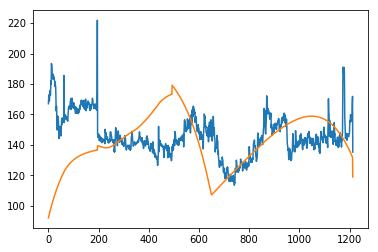


Iter: 1801, running avg elbo: -70890658.6276
Iter: 1802, running avg elbo: -70607003.5214
Iter: 1803, running avg elbo: -70321556.1662
Iter: 1804, running avg elbo: -70047146.9645
Iter: 1805, running avg elbo: -69776988.2949
Iter: 1806, running avg elbo: -69505715.3719
Iter: 1807, running avg elbo: -69231428.4582
Iter: 1808, running avg elbo: -68961909.2936
Iter: 1809, running avg elbo: -68693465.2407
Iter: 1810, running avg elbo: -68430905.1083
Iter: 1811, running avg elbo: -68156651.6172
Iter: 1812, running avg elbo: -67894746.7410
Iter: 1813, running avg elbo: -67638313.1136
Iter: 1814, running avg elbo: -67389835.4225
Iter: 1815, running avg elbo: -67135103.4282
Iter: 1816, running avg elbo: -66894527.1940
Iter: 1817, running avg elbo: -66658137.2420
Iter: 1818, running avg elbo: -66408937.2296
Iter: 1819, running avg elbo: -66169178.4173
Iter: 1820, running avg elbo: -65949770.6731
Iter: 1821, running avg elbo: -65718817.1664
Iter: 1822, running avg elbo: -65548832.1947
Iter: 182

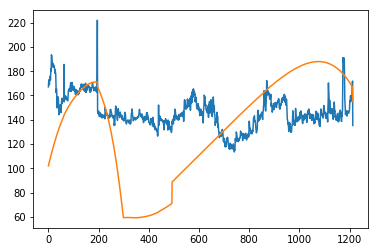


Iter: 1851, running avg elbo: -85019724.0247
Iter: 1852, running avg elbo: -85538187.7444
Iter: 1853, running avg elbo: -85883382.2670
Iter: 1854, running avg elbo: -86200870.7643
Iter: 1855, running avg elbo: -86630299.4167
Iter: 1856, running avg elbo: -87167820.4225
Iter: 1857, running avg elbo: -87591728.6183
Iter: 1858, running avg elbo: -87891242.5321
Iter: 1859, running avg elbo: -88192622.9868
Iter: 1860, running avg elbo: -88573617.3969
Iter: 1861, running avg elbo: -88953128.5029
Iter: 1862, running avg elbo: -89268598.9779
Iter: 1863, running avg elbo: -89546259.0681
Iter: 1864, running avg elbo: -89820742.6375
Iter: 1865, running avg elbo: -90119122.0911
Iter: 1866, running avg elbo: -90380686.6302
Iter: 1867, running avg elbo: -90599256.6439
Iter: 1868, running avg elbo: -90794399.5174
Iter: 1869, running avg elbo: -90998576.0023
Iter: 1870, running avg elbo: -91219214.4022
Iter: 1871, running avg elbo: -91408934.8982
Iter: 1872, running avg elbo: -91555634.2692
Iter: 187

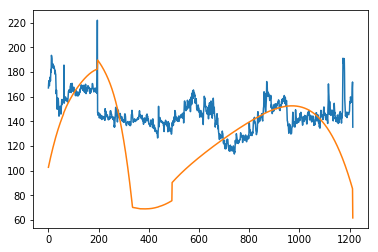


Iter: 1901, running avg elbo: -93744675.6260
Iter: 1902, running avg elbo: -93758312.6298
Iter: 1903, running avg elbo: -93743174.0635
Iter: 1904, running avg elbo: -93794063.0428
Iter: 1905, running avg elbo: -93927355.2124
Iter: 1906, running avg elbo: -94089118.2203
Iter: 1907, running avg elbo: -94172108.3981
Iter: 1908, running avg elbo: -94144248.0341
Iter: 1909, running avg elbo: -94094901.0738
Iter: 1910, running avg elbo: -94102582.9430
Iter: 1911, running avg elbo: -94165399.3536
Iter: 1912, running avg elbo: -94208822.1600
Iter: 1913, running avg elbo: -94152202.9784
Iter: 1914, running avg elbo: -94076877.6687
Iter: 1915, running avg elbo: -94066857.4520
Iter: 1916, running avg elbo: -94044222.7975
Iter: 1917, running avg elbo: -93962426.3295
Iter: 1918, running avg elbo: -93921410.2262
Iter: 1919, running avg elbo: -93998818.2039
Iter: 1920, running avg elbo: -94078944.4219
Iter: 1921, running avg elbo: -94034886.6577
Iter: 1922, running avg elbo: -93919639.7911
Iter: 192

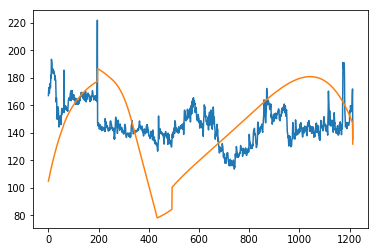


Iter: 1951, running avg elbo: -89528810.9847
Iter: 1952, running avg elbo: -89338886.7149
Iter: 1953, running avg elbo: -89063794.8077
Iter: 1954, running avg elbo: -88700010.4596
Iter: 1955, running avg elbo: -88402240.6350
Iter: 1956, running avg elbo: -88337574.8687
Iter: 1957, running avg elbo: -88321793.9200
Iter: 1958, running avg elbo: -88048179.9408
Iter: 1959, running avg elbo: -87601377.5014
Iter: 1960, running avg elbo: -87249845.3664
Iter: 1961, running avg elbo: -87113685.5527
Iter: 1962, running avg elbo: -86929670.8572
Iter: 1963, running avg elbo: -86561609.8686
Iter: 1964, running avg elbo: -86087444.7699
Iter: 1965, running avg elbo: -85678680.9622
Iter: 1966, running avg elbo: -85301998.6726
Iter: 1967, running avg elbo: -84847603.5659
Iter: 1968, running avg elbo: -84396244.3702
Iter: 1969, running avg elbo: -84080036.3265
Iter: 1970, running avg elbo: -83766024.9233
Iter: 1971, running avg elbo: -83317559.1540
Iter: 1972, running avg elbo: -82895688.8825
Iter: 197

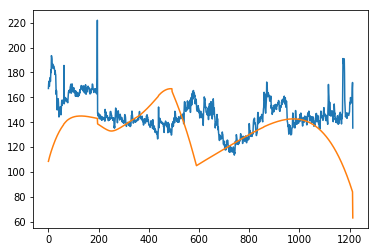


Iter: 2001, running avg elbo: -71803285.1867
Iter: 2002, running avg elbo: -71529848.7348
Iter: 2003, running avg elbo: -71525024.5674
Iter: 2004, running avg elbo: -71229004.5218
Iter: 2005, running avg elbo: -70957693.1565
Iter: 2006, running avg elbo: -70938468.5450
Iter: 2007, running avg elbo: -70603982.9395
Iter: 2008, running avg elbo: -70354450.5501
Iter: 2009, running avg elbo: -70205629.8046
Iter: 2010, running avg elbo: -69826680.9066
Iter: 2011, running avg elbo: -69631550.5775
Iter: 2012, running avg elbo: -69428032.0717
Iter: 2013, running avg elbo: -69070468.1110
Iter: 2014, running avg elbo: -68790203.2699
Iter: 2015, running avg elbo: -68459365.9972
Iter: 2016, running avg elbo: -68121971.1772
Iter: 2017, running avg elbo: -67846877.5455
Iter: 2018, running avg elbo: -67528949.5300
Iter: 2019, running avg elbo: -67179601.8947
Iter: 2020, running avg elbo: -66871595.1558
Iter: 2021, running avg elbo: -66572975.5242
Iter: 2022, running avg elbo: -66235630.3890
Iter: 202

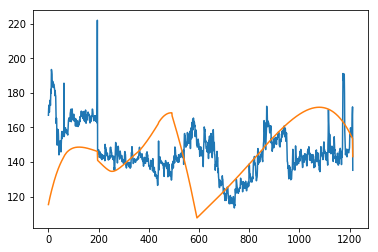


Iter: 2051, running avg elbo: -58902012.9478
Iter: 2052, running avg elbo: -58674786.9783
Iter: 2053, running avg elbo: -58606577.3885
Iter: 2054, running avg elbo: -58359064.1346
Iter: 2055, running avg elbo: -58153662.2933
Iter: 2056, running avg elbo: -58036646.5903
Iter: 2057, running avg elbo: -57763800.1444
Iter: 2058, running avg elbo: -57672094.2630
Iter: 2059, running avg elbo: -57499168.4404
Iter: 2060, running avg elbo: -57298049.2760
Iter: 2061, running avg elbo: -57358211.5432
Iter: 2062, running avg elbo: -57098184.2478
Iter: 2063, running avg elbo: -57241508.2453
Iter: 2064, running avg elbo: -57363642.4428
Iter: 2065, running avg elbo: -57106161.5384
Iter: 2066, running avg elbo: -57240770.6430
Iter: 2067, running avg elbo: -57095773.0166
Iter: 2068, running avg elbo: -56932202.2864
Iter: 2069, running avg elbo: -56864863.9836
Iter: 2070, running avg elbo: -56660443.5037
Iter: 2071, running avg elbo: -56936975.4687
Iter: 2072, running avg elbo: -56718732.6740
Iter: 207

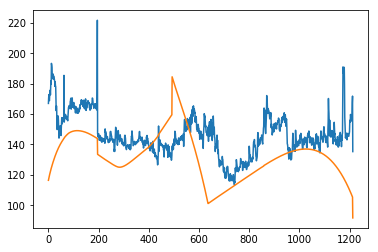


Iter: 2101, running avg elbo: -51598045.7969
Iter: 2102, running avg elbo: -51356370.9590
Iter: 2103, running avg elbo: -51119918.2294
Iter: 2104, running avg elbo: -50886515.5671
Iter: 2105, running avg elbo: -50652811.1914
Iter: 2106, running avg elbo: -50439654.1595
Iter: 2107, running avg elbo: -50207788.2579
Iter: 2108, running avg elbo: -49997381.9153
Iter: 2109, running avg elbo: -49780809.9362
Iter: 2110, running avg elbo: -49655640.4368
Iter: 2111, running avg elbo: -49492250.0924
Iter: 2112, running avg elbo: -49269784.2715
Iter: 2113, running avg elbo: -49089062.0488
Iter: 2114, running avg elbo: -48867439.4883
Iter: 2115, running avg elbo: -48702134.1134
Iter: 2116, running avg elbo: -48480035.1723
Iter: 2117, running avg elbo: -48313725.4206
Iter: 2118, running avg elbo: -48116392.9264
Iter: 2119, running avg elbo: -48061796.3571
Iter: 2120, running avg elbo: -47878010.7535
Iter: 2121, running avg elbo: -47728946.0460
Iter: 2122, running avg elbo: -47585058.3455
Iter: 212

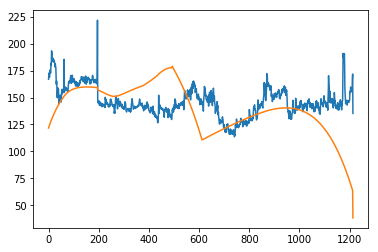


Iter: 2151, running avg elbo: -46634949.6261
Iter: 2152, running avg elbo: -46583321.4899
Iter: 2153, running avg elbo: -46539651.8350
Iter: 2154, running avg elbo: -46768602.5166
Iter: 2155, running avg elbo: -46568864.6114
Iter: 2156, running avg elbo: -46743310.8053
Iter: 2157, running avg elbo: -46581655.2773
Iter: 2158, running avg elbo: -46594752.7645
Iter: 2159, running avg elbo: -46582408.5969
Iter: 2160, running avg elbo: -46381821.3109
Iter: 2161, running avg elbo: -46307002.4978
Iter: 2162, running avg elbo: -46096852.0128
Iter: 2163, running avg elbo: -45976466.6927
Iter: 2164, running avg elbo: -45813510.2658
Iter: 2165, running avg elbo: -45626040.2831
Iter: 2166, running avg elbo: -45459576.6803
Iter: 2167, running avg elbo: -45269922.9335
Iter: 2168, running avg elbo: -45189288.8241
Iter: 2169, running avg elbo: -45033869.6759
Iter: 2170, running avg elbo: -44836678.6591
Iter: 2171, running avg elbo: -44658332.2325
Iter: 2172, running avg elbo: -44475220.8502
Iter: 217

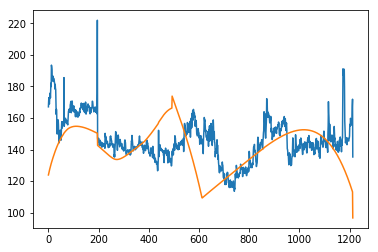


Iter: 2201, running avg elbo: -40831549.3002
Iter: 2202, running avg elbo: -40671279.4472
Iter: 2203, running avg elbo: -40605072.0527
Iter: 2204, running avg elbo: -40441536.4522
Iter: 2205, running avg elbo: -40373926.0877
Iter: 2206, running avg elbo: -40208747.0468
Iter: 2207, running avg elbo: -40210078.1764
Iter: 2208, running avg elbo: -40058156.9746
Iter: 2209, running avg elbo: -39982004.3648
Iter: 2210, running avg elbo: -39856415.7412
Iter: 2211, running avg elbo: -39715678.2638
Iter: 2212, running avg elbo: -39570666.9411
Iter: 2213, running avg elbo: -39469087.0917
Iter: 2214, running avg elbo: -39447247.6608
Iter: 2215, running avg elbo: -39300425.4042
Iter: 2216, running avg elbo: -39168597.6502
Iter: 2217, running avg elbo: -39009188.5537
Iter: 2218, running avg elbo: -38854491.3081
Iter: 2219, running avg elbo: -38698818.6950
Iter: 2220, running avg elbo: -38536179.8081
Iter: 2221, running avg elbo: -38403067.3700
Iter: 2222, running avg elbo: -38262159.1363
Iter: 222

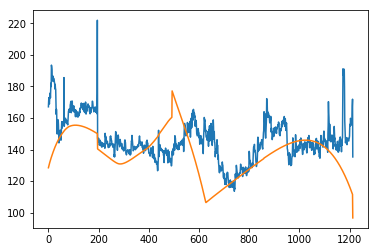


Iter: 2251, running avg elbo: -36059325.8220
Iter: 2252, running avg elbo: -35919203.6238
Iter: 2253, running avg elbo: -36057686.9875
Iter: 2254, running avg elbo: -35940757.1377
Iter: 2255, running avg elbo: -35838506.1863
Iter: 2256, running avg elbo: -35711889.0444
Iter: 2257, running avg elbo: -35663254.9940
Iter: 2258, running avg elbo: -35600732.2440
Iter: 2259, running avg elbo: -35784269.2416
Iter: 2260, running avg elbo: -35652222.5892
Iter: 2261, running avg elbo: -35918741.9633
Iter: 2262, running avg elbo: -35765645.8037
Iter: 2263, running avg elbo: -36092194.3856
Iter: 2264, running avg elbo: -35961287.3018
Iter: 2265, running avg elbo: -36119526.9887
Iter: 2266, running avg elbo: -36000049.1189
Iter: 2267, running avg elbo: -35967836.2677
Iter: 2268, running avg elbo: -35815274.3050
Iter: 2269, running avg elbo: -35692307.2219
Iter: 2270, running avg elbo: -35552886.3497
Iter: 2271, running avg elbo: -35424900.1662
Iter: 2272, running avg elbo: -35317312.9246
Iter: 227

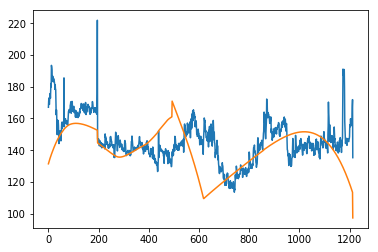


Iter: 2301, running avg elbo: -34341694.5667
Iter: 2302, running avg elbo: -34194375.5210
Iter: 2303, running avg elbo: -34079474.3858
Iter: 2304, running avg elbo: -34048676.0419
Iter: 2305, running avg elbo: -33944016.4415
Iter: 2306, running avg elbo: -33913468.6971
Iter: 2307, running avg elbo: -33769454.8901
Iter: 2308, running avg elbo: -33791453.6212
Iter: 2309, running avg elbo: -33668087.4650
Iter: 2310, running avg elbo: -33736260.8704
Iter: 2311, running avg elbo: -33640036.6617
Iter: 2312, running avg elbo: -33543965.4150
Iter: 2313, running avg elbo: -33404140.8209
Iter: 2314, running avg elbo: -33356319.7527
Iter: 2315, running avg elbo: -33215816.9952
Iter: 2316, running avg elbo: -33225781.2252
Iter: 2317, running avg elbo: -33114708.2930
Iter: 2318, running avg elbo: -33260675.1700
Iter: 2319, running avg elbo: -33125728.9383
Iter: 2320, running avg elbo: -33491923.4089
Iter: 2321, running avg elbo: -33442950.0349
Iter: 2322, running avg elbo: -33665515.4145
Iter: 232

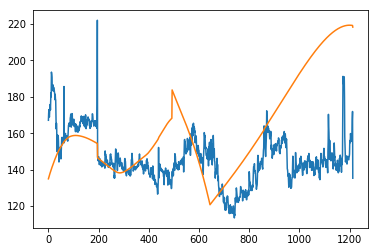


Iter: 2351, running avg elbo: -41010517.9654
Iter: 2352, running avg elbo: -41711495.1857
Iter: 2353, running avg elbo: -41640133.8739
Iter: 2354, running avg elbo: -41983222.0551
Iter: 2355, running avg elbo: -41826387.7146
Iter: 2356, running avg elbo: -42063072.2774
Iter: 2357, running avg elbo: -41898942.9547
Iter: 2358, running avg elbo: -41837852.2451
Iter: 2359, running avg elbo: -41837574.6827
Iter: 2360, running avg elbo: -41852536.2958
Iter: 2361, running avg elbo: -41924581.6529
Iter: 2362, running avg elbo: -41840255.7963
Iter: 2363, running avg elbo: -41735961.1184
Iter: 2364, running avg elbo: -41634919.2672
Iter: 2365, running avg elbo: -41487208.5145
Iter: 2366, running avg elbo: -41300185.0094
Iter: 2367, running avg elbo: -41140671.3793
Iter: 2368, running avg elbo: -41045120.4055
Iter: 2369, running avg elbo: -40858836.1414
Iter: 2370, running avg elbo: -41546034.2600
Iter: 2371, running avg elbo: -41596022.0774
Iter: 2372, running avg elbo: -41604026.5366
Iter: 237

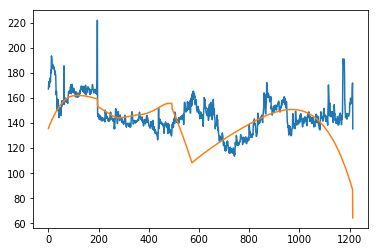


Iter: 2401, running avg elbo: -39518690.6628
Iter: 2402, running avg elbo: -39733485.7562
Iter: 2403, running avg elbo: -39626462.1387
Iter: 2404, running avg elbo: -39672450.0373
Iter: 2405, running avg elbo: -39603709.9969
Iter: 2406, running avg elbo: -40003632.1769
Iter: 2407, running avg elbo: -39935143.2952
Iter: 2408, running avg elbo: -40402279.8622
Iter: 2409, running avg elbo: -40487090.0636
Iter: 2410, running avg elbo: -40537960.0429
Iter: 2411, running avg elbo: -40921003.4825
Iter: 2412, running avg elbo: -41116155.6477
Iter: 2413, running avg elbo: -41531912.0912
Iter: 2414, running avg elbo: -41581352.1303
Iter: 2415, running avg elbo: -42050136.0490
Iter: 2416, running avg elbo: -41933449.3285
Iter: 2417, running avg elbo: -42478483.7152
Iter: 2418, running avg elbo: -42285303.0781
Iter: 2419, running avg elbo: -42848919.6473
Iter: 2420, running avg elbo: -42703163.8108
Iter: 2421, running avg elbo: -42894352.1727
Iter: 2422, running avg elbo: -42923090.6910
Iter: 242

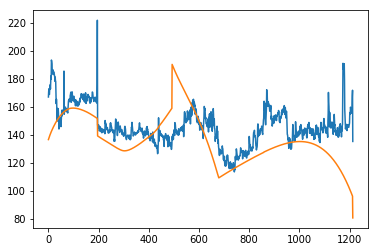


Iter: 2451, running avg elbo: -42654388.1821
Iter: 2452, running avg elbo: -42734884.7803
Iter: 2453, running avg elbo: -42551710.2925
Iter: 2454, running avg elbo: -42544342.8696
Iter: 2455, running avg elbo: -42322810.6409
Iter: 2456, running avg elbo: -42303202.8545
Iter: 2457, running avg elbo: -42075537.7259
Iter: 2458, running avg elbo: -41935880.7087
Iter: 2459, running avg elbo: -41770801.1016
Iter: 2460, running avg elbo: -41603908.8506
Iter: 2461, running avg elbo: -41366367.2021
Iter: 2462, running avg elbo: -41132037.8500
Iter: 2463, running avg elbo: -40904189.1115
Iter: 2464, running avg elbo: -40722959.0004
Iter: 2465, running avg elbo: -40517466.5704
Iter: 2466, running avg elbo: -40385298.9247
Iter: 2467, running avg elbo: -40158125.9755
Iter: 2468, running avg elbo: -39967787.3157
Iter: 2469, running avg elbo: -39749341.0226
Iter: 2470, running avg elbo: -39525982.8923
Iter: 2471, running avg elbo: -39306550.5434
Iter: 2472, running avg elbo: -39084285.5980
Iter: 247

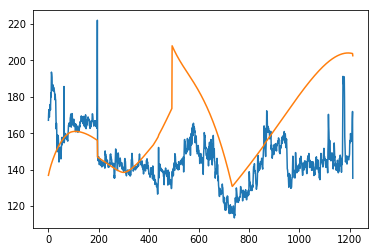


Iter: 2501, running avg elbo: -34986529.6052
Iter: 2502, running avg elbo: -35742055.9892
Iter: 2503, running avg elbo: -35938346.2693
Iter: 2504, running avg elbo: -36231334.7666
Iter: 2505, running avg elbo: -36564594.8589
Iter: 2506, running avg elbo: -36663221.7103
Iter: 2507, running avg elbo: -36983783.4132
Iter: 2508, running avg elbo: -36864528.8791
Iter: 2509, running avg elbo: -37157744.4703
Iter: 2510, running avg elbo: -37189314.9456
Iter: 2511, running avg elbo: -37773750.1961
Iter: 2512, running avg elbo: -37725771.7142
Iter: 2513, running avg elbo: -38008822.7570
Iter: 2514, running avg elbo: -38222223.6095
Iter: 2515, running avg elbo: -38335993.3734
Iter: 2516, running avg elbo: -38550669.7196
Iter: 2517, running avg elbo: -38376577.4824
Iter: 2518, running avg elbo: -39801507.7076
Iter: 2519, running avg elbo: -39646037.6505
Iter: 2520, running avg elbo: -40431131.5140
Iter: 2521, running avg elbo: -40695073.9189
Iter: 2522, running avg elbo: -41036553.0997
Iter: 252

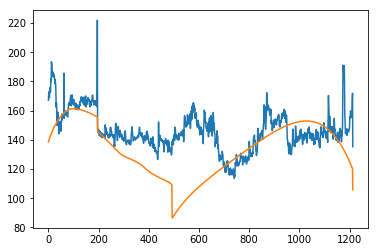


Iter: 2551, running avg elbo: -48179572.0249
Iter: 2552, running avg elbo: -48592911.6647
Iter: 2553, running avg elbo: -50065931.8281
Iter: 2554, running avg elbo: -50859783.0698
Iter: 2555, running avg elbo: -51814024.2791
Iter: 2556, running avg elbo: -53006861.6363
Iter: 2557, running avg elbo: -53465520.5399
Iter: 2558, running avg elbo: -54667153.3345
Iter: 2559, running avg elbo: -55053267.8812
Iter: 2560, running avg elbo: -55823432.4824
Iter: 2561, running avg elbo: -56486879.6775
Iter: 2562, running avg elbo: -56907110.2408
Iter: 2563, running avg elbo: -57407390.2584
Iter: 2564, running avg elbo: -57889894.2758
Iter: 2565, running avg elbo: -58335847.4930
Iter: 2566, running avg elbo: -59324423.0981
Iter: 2567, running avg elbo: -59511153.9071
Iter: 2568, running avg elbo: -60379625.5680
Iter: 2569, running avg elbo: -61255950.1124
Iter: 2570, running avg elbo: -61773331.4912
Iter: 2571, running avg elbo: -63009640.0963
Iter: 2572, running avg elbo: -63084648.9754
Iter: 257

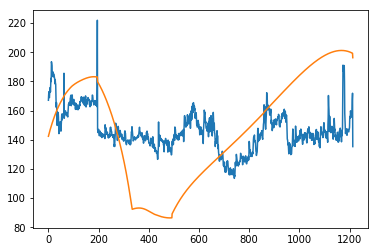


Iter: 2601, running avg elbo: -75199334.9868
Iter: 2602, running avg elbo: -75074080.2369
Iter: 2603, running avg elbo: -75150682.7145
Iter: 2604, running avg elbo: -75380131.6474
Iter: 2605, running avg elbo: -76078952.2509
Iter: 2606, running avg elbo: -76141340.5684
Iter: 2607, running avg elbo: -76034589.2427
Iter: 2608, running avg elbo: -76369200.3103
Iter: 2609, running avg elbo: -76705786.9472
Iter: 2610, running avg elbo: -77107406.9977
Iter: 2611, running avg elbo: -77714656.9277
Iter: 2612, running avg elbo: -77521208.6385
Iter: 2613, running avg elbo: -78196421.5121
Iter: 2614, running avg elbo: -78380140.4970
Iter: 2615, running avg elbo: -78184464.3320
Iter: 2616, running avg elbo: -78889697.1287
Iter: 2617, running avg elbo: -78697548.9974
Iter: 2618, running avg elbo: -78704164.5474
Iter: 2619, running avg elbo: -78949548.5819
Iter: 2620, running avg elbo: -78758386.4161
Iter: 2621, running avg elbo: -78705527.3519
Iter: 2622, running avg elbo: -78459566.3984
Iter: 262

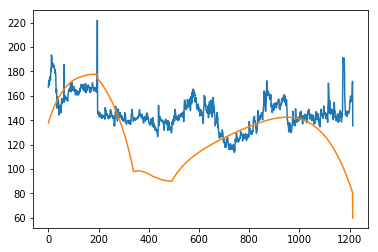


Iter: 2651, running avg elbo: -74641602.2976
Iter: 2652, running avg elbo: -74603509.2347
Iter: 2653, running avg elbo: -74332757.9823
Iter: 2654, running avg elbo: -74271970.4025
Iter: 2655, running avg elbo: -74005696.4985
Iter: 2656, running avg elbo: -73746786.2535
Iter: 2657, running avg elbo: -73627553.2309
Iter: 2658, running avg elbo: -73367126.3386
Iter: 2659, running avg elbo: -73279911.7552
Iter: 2660, running avg elbo: -73069362.1977
Iter: 2661, running avg elbo: -72800912.0157
Iter: 2662, running avg elbo: -73067927.0556
Iter: 2663, running avg elbo: -72806421.7050
Iter: 2664, running avg elbo: -74077418.1280
Iter: 2665, running avg elbo: -73811878.5467
Iter: 2666, running avg elbo: -73538898.2412
Iter: 2667, running avg elbo: -73992782.6988
Iter: 2668, running avg elbo: -73713882.6718
Iter: 2669, running avg elbo: -74008346.8851
Iter: 2670, running avg elbo: -73997145.0162
Iter: 2671, running avg elbo: -73847034.7261
Iter: 2672, running avg elbo: -74156383.4188
Iter: 267

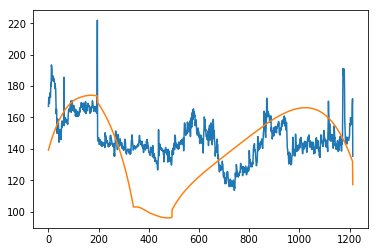


Iter: 2701, running avg elbo: -68667166.0672
Iter: 2702, running avg elbo: -68542238.7665
Iter: 2703, running avg elbo: -68263908.0589
Iter: 2704, running avg elbo: -68058756.5383
Iter: 2705, running avg elbo: -68124936.0129
Iter: 2706, running avg elbo: -67859704.8528
Iter: 2707, running avg elbo: -68000776.7642
Iter: 2708, running avg elbo: -67915986.3566
Iter: 2709, running avg elbo: -67937909.2930
Iter: 2710, running avg elbo: -67997557.8801
Iter: 2711, running avg elbo: -67747651.3813
Iter: 2712, running avg elbo: -67743718.7875
Iter: 2713, running avg elbo: -67478953.2396
Iter: 2714, running avg elbo: -67258858.7072
Iter: 2715, running avg elbo: -67035566.9601
Iter: 2716, running avg elbo: -66785853.2105
Iter: 2717, running avg elbo: -66532192.8384
Iter: 2718, running avg elbo: -66374006.9501
Iter: 2719, running avg elbo: -66117628.4006
Iter: 2720, running avg elbo: -65864139.2366
Iter: 2721, running avg elbo: -65870513.3242
Iter: 2722, running avg elbo: -65632257.2309
Iter: 272

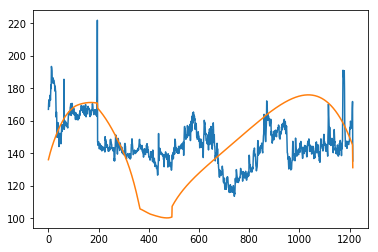


Iter: 2751, running avg elbo: -62210018.4983
Iter: 2752, running avg elbo: -61952365.5933
Iter: 2753, running avg elbo: -62075418.7374
Iter: 2754, running avg elbo: -61918823.1900
Iter: 2755, running avg elbo: -61805374.0381
Iter: 2756, running avg elbo: -62145248.4577
Iter: 2757, running avg elbo: -61991527.0931
Iter: 2758, running avg elbo: -61921838.5022
Iter: 2759, running avg elbo: -61721929.8772
Iter: 2760, running avg elbo: -61618609.0584
Iter: 2761, running avg elbo: -61493061.3278
Iter: 2762, running avg elbo: -61219191.0346
Iter: 2763, running avg elbo: -61213721.9242
Iter: 2764, running avg elbo: -60952132.3050
Iter: 2765, running avg elbo: -60708938.3819
Iter: 2766, running avg elbo: -60455700.5181
Iter: 2767, running avg elbo: -60182307.3129
Iter: 2768, running avg elbo: -59917794.3198
Iter: 2769, running avg elbo: -59648942.2366
Iter: 2770, running avg elbo: -59378579.4942
Iter: 2771, running avg elbo: -59115809.8193
Iter: 2772, running avg elbo: -58947190.7611
Iter: 277

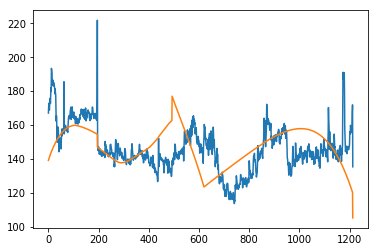


Iter: 2801, running avg elbo: -50886455.3720
Iter: 2802, running avg elbo: -50552957.9983
Iter: 2803, running avg elbo: -50307554.7983
Iter: 2804, running avg elbo: -49974210.8103
Iter: 2805, running avg elbo: -49699529.4222
Iter: 2806, running avg elbo: -49381449.7880
Iter: 2807, running avg elbo: -49085624.5501
Iter: 2808, running avg elbo: -48750745.1446
Iter: 2809, running avg elbo: -48925479.4531
Iter: 2810, running avg elbo: -48596205.4886
Iter: 2811, running avg elbo: -48627955.8737
Iter: 2812, running avg elbo: -48347618.5750
Iter: 2813, running avg elbo: -48022890.7092
Iter: 2814, running avg elbo: -47856275.2421
Iter: 2815, running avg elbo: -47629776.9497
Iter: 2816, running avg elbo: -47471802.1202
Iter: 2817, running avg elbo: -47189317.8390
Iter: 2818, running avg elbo: -46881471.6206
Iter: 2819, running avg elbo: -46579767.7444
Iter: 2820, running avg elbo: -46293488.7870
Iter: 2821, running avg elbo: -45997717.2091
Iter: 2822, running avg elbo: -45731990.7770
Iter: 282

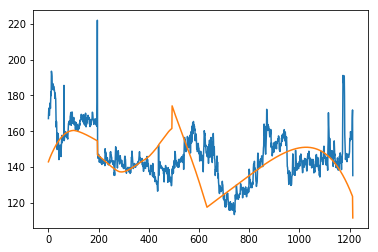


Iter: 2851, running avg elbo: -38563912.8551
Iter: 2852, running avg elbo: -38334863.3766
Iter: 2853, running avg elbo: -38097037.0128
Iter: 2854, running avg elbo: -37889449.4227
Iter: 2855, running avg elbo: -37751287.3285
Iter: 2856, running avg elbo: -37749636.3752
Iter: 2857, running avg elbo: -37525101.2714
Iter: 2858, running avg elbo: -37450231.8787
Iter: 2859, running avg elbo: -37229198.0799
Iter: 2860, running avg elbo: -37013361.0091
Iter: 2861, running avg elbo: -36869418.9790
Iter: 2862, running avg elbo: -36643274.5892
Iter: 2863, running avg elbo: -36464714.8234
Iter: 2864, running avg elbo: -36265238.0851
Iter: 2865, running avg elbo: -36058985.6543
Iter: 2866, running avg elbo: -35869110.9377
Iter: 2867, running avg elbo: -35732998.0883
Iter: 2868, running avg elbo: -35544578.3675
Iter: 2869, running avg elbo: -35547865.3838
Iter: 2870, running avg elbo: -35350660.4000
Iter: 2871, running avg elbo: -35290066.1160
Iter: 2872, running avg elbo: -35087003.8548
Iter: 287

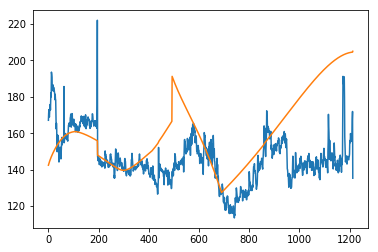


Iter: 2901, running avg elbo: -32392154.8564
Iter: 2902, running avg elbo: -32330934.5879
Iter: 2903, running avg elbo: -32473805.6820
Iter: 2904, running avg elbo: -32302930.8552
Iter: 2905, running avg elbo: -32172745.4466
Iter: 2906, running avg elbo: -32139904.5921
Iter: 2907, running avg elbo: -31987776.8662
Iter: 2908, running avg elbo: -31949946.6176
Iter: 2909, running avg elbo: -31977534.9914
Iter: 2910, running avg elbo: -31861526.9415
Iter: 2911, running avg elbo: -31908697.5521
Iter: 2912, running avg elbo: -31735682.3065
Iter: 2913, running avg elbo: -31914566.4035
Iter: 2914, running avg elbo: -31744223.2394
Iter: 2915, running avg elbo: -31614910.2070
Iter: 2916, running avg elbo: -31496231.2450
Iter: 2917, running avg elbo: -31414771.1725
Iter: 2918, running avg elbo: -31354404.5208
Iter: 2919, running avg elbo: -31240275.7156
Iter: 2920, running avg elbo: -31393908.4384
Iter: 2921, running avg elbo: -31314670.6540
Iter: 2922, running avg elbo: -31350158.4675
Iter: 292

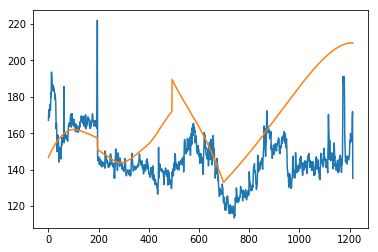


Iter: 2951, running avg elbo: -29490496.3916
Iter: 2952, running avg elbo: -29506142.2077
Iter: 2953, running avg elbo: -29515773.0456
Iter: 2954, running avg elbo: -29403428.8952
Iter: 2955, running avg elbo: -29423382.1662
Iter: 2956, running avg elbo: -29263654.8946
Iter: 2957, running avg elbo: -29304566.1056
Iter: 2958, running avg elbo: -29158923.5346
Iter: 2959, running avg elbo: -29037463.1592
Iter: 2960, running avg elbo: -28882451.6276
Iter: 2961, running avg elbo: -28722643.4913
Iter: 2962, running avg elbo: -28562172.6264
Iter: 2963, running avg elbo: -28411641.4602
Iter: 2964, running avg elbo: -28256811.1456
Iter: 2965, running avg elbo: -28111685.8941
Iter: 2966, running avg elbo: -27986628.3552
Iter: 2967, running avg elbo: -28094358.8716
Iter: 2968, running avg elbo: -28109231.2029
Iter: 2969, running avg elbo: -28503107.9309
Iter: 2970, running avg elbo: -28470151.5116
Iter: 2971, running avg elbo: -28811654.5964
Iter: 2972, running avg elbo: -29055653.4105
Iter: 297

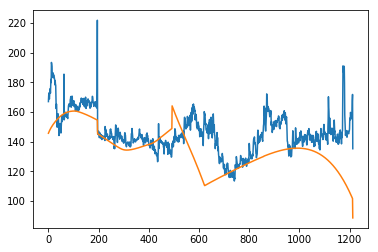


Iter: 3001, running avg elbo: -27785086.5355
Iter: 3002, running avg elbo: -27772510.5302
Iter: 3003, running avg elbo: -27702483.2449
Iter: 3004, running avg elbo: -27653054.7724
Iter: 3005, running avg elbo: -27545022.6247
Iter: 3006, running avg elbo: -27420643.3985
Iter: 3007, running avg elbo: -27345413.6245
Iter: 3008, running avg elbo: -27254724.8682
Iter: 3009, running avg elbo: -27402441.5795
Iter: 3010, running avg elbo: -27392486.3838
Iter: 3011, running avg elbo: -27338133.7599
Iter: 3012, running avg elbo: -27276843.6023
Iter: 3013, running avg elbo: -27247821.2663
Iter: 3014, running avg elbo: -27125736.7436
Iter: 3015, running avg elbo: -27101943.9362
Iter: 3016, running avg elbo: -27021690.2968
Iter: 3017, running avg elbo: -26892459.0239
Iter: 3018, running avg elbo: -26782130.9336
Iter: 3019, running avg elbo: -26713284.7043
Iter: 3020, running avg elbo: -26619420.0172
Iter: 3021, running avg elbo: -26661510.2171
Iter: 3022, running avg elbo: -26592252.9949
Iter: 302

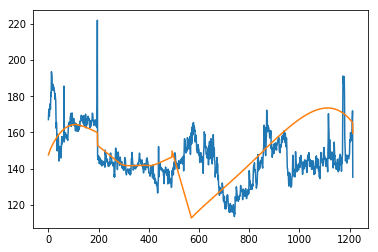


Iter: 3051, running avg elbo: -27093025.4677
Iter: 3052, running avg elbo: -27086363.6930
Iter: 3053, running avg elbo: -26977866.8061
Iter: 3054, running avg elbo: -26974164.1381
Iter: 3055, running avg elbo: -26882107.6367
Iter: 3056, running avg elbo: -26829698.3003
Iter: 3057, running avg elbo: -26708245.9073
Iter: 3058, running avg elbo: -26578698.2082
Iter: 3059, running avg elbo: -26442538.2461
Iter: 3060, running avg elbo: -26440986.3637
Iter: 3061, running avg elbo: -26304075.4600
Iter: 3062, running avg elbo: -26182168.5554
Iter: 3063, running avg elbo: -26072963.2499
Iter: 3064, running avg elbo: -25938769.5174
Iter: 3065, running avg elbo: -25804765.5322
Iter: 3066, running avg elbo: -25676070.3269
Iter: 3067, running avg elbo: -25633333.3436
Iter: 3068, running avg elbo: -25525339.3302
Iter: 3069, running avg elbo: -25542084.6769
Iter: 3070, running avg elbo: -25457150.2301
Iter: 3071, running avg elbo: -25345605.1078
Iter: 3072, running avg elbo: -25362447.8367
Iter: 307

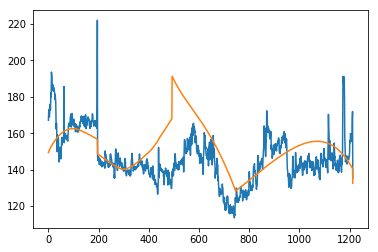


Iter: 3101, running avg elbo: -23078734.0590
Iter: 3102, running avg elbo: -23122363.5984
Iter: 3103, running avg elbo: -23105404.6424
Iter: 3104, running avg elbo: -23107028.4760
Iter: 3105, running avg elbo: -23044040.2513
Iter: 3106, running avg elbo: -22926184.8587
Iter: 3107, running avg elbo: -23130407.0902
Iter: 3108, running avg elbo: -23118742.5793
Iter: 3109, running avg elbo: -23358794.9535
Iter: 3110, running avg elbo: -23544586.9239
Iter: 3111, running avg elbo: -23775843.5747
Iter: 3112, running avg elbo: -23962150.2589
Iter: 3113, running avg elbo: -24133534.7964
Iter: 3114, running avg elbo: -24364487.0884
Iter: 3115, running avg elbo: -24531475.3775
Iter: 3116, running avg elbo: -24763039.5437
Iter: 3117, running avg elbo: -24910299.3883
Iter: 3118, running avg elbo: -25051097.0744
Iter: 3119, running avg elbo: -25176207.8237
Iter: 3120, running avg elbo: -25291821.4654
Iter: 3121, running avg elbo: -25415534.1708
Iter: 3122, running avg elbo: -25518266.3091
Iter: 312

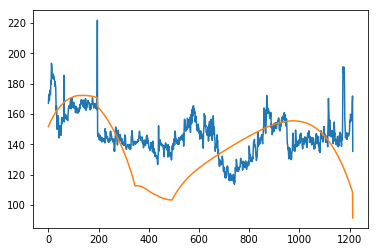


Iter: 3151, running avg elbo: -27924019.2698
Iter: 3152, running avg elbo: -28006470.1571
Iter: 3153, running avg elbo: -28044173.3555
Iter: 3154, running avg elbo: -28168600.5020
Iter: 3155, running avg elbo: -28208191.4969
Iter: 3156, running avg elbo: -28291791.9420
Iter: 3157, running avg elbo: -28337945.5026
Iter: 3158, running avg elbo: -28393546.0875
Iter: 3159, running avg elbo: -28546931.3867
Iter: 3160, running avg elbo: -28594483.3728
Iter: 3161, running avg elbo: -28730455.2591
Iter: 3162, running avg elbo: -28733525.7865
Iter: 3163, running avg elbo: -28988950.4886
Iter: 3164, running avg elbo: -29033255.8037
Iter: 3165, running avg elbo: -29173529.4857
Iter: 3166, running avg elbo: -29238803.8308
Iter: 3167, running avg elbo: -29347982.8325
Iter: 3168, running avg elbo: -29489011.2842
Iter: 3169, running avg elbo: -29506461.7514
Iter: 3170, running avg elbo: -29586972.6938
Iter: 3171, running avg elbo: -29597157.5269
Iter: 3172, running avg elbo: -29595177.5716
Iter: 317

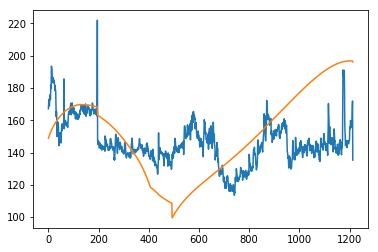


Iter: 3201, running avg elbo: -34298640.7686
Iter: 3202, running avg elbo: -34224519.4009
Iter: 3203, running avg elbo: -34704339.8069
Iter: 3204, running avg elbo: -35092306.1688
Iter: 3205, running avg elbo: -35069808.2271
Iter: 3206, running avg elbo: -35321146.4248
Iter: 3207, running avg elbo: -35737922.6406
Iter: 3208, running avg elbo: -36166440.8542
Iter: 3209, running avg elbo: -36381508.4056
Iter: 3210, running avg elbo: -36291808.2216
Iter: 3211, running avg elbo: -36484247.7794
Iter: 3212, running avg elbo: -36659081.3416
Iter: 3213, running avg elbo: -36576809.2882
Iter: 3214, running avg elbo: -36589287.2753
Iter: 3215, running avg elbo: -36664641.9625
Iter: 3216, running avg elbo: -36698485.1029
Iter: 3217, running avg elbo: -36754788.4919
Iter: 3218, running avg elbo: -36590457.3070
Iter: 3219, running avg elbo: -36486437.3539
Iter: 3220, running avg elbo: -37568783.5403
Iter: 3221, running avg elbo: -37871200.1049
Iter: 3222, running avg elbo: -38151312.9439
Iter: 322

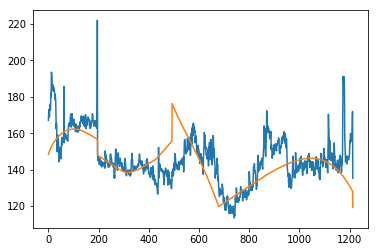


Iter: 3251, running avg elbo: -34539156.0738
Iter: 3252, running avg elbo: -34343841.5431
Iter: 3253, running avg elbo: -34138242.1076
Iter: 3254, running avg elbo: -33968256.0866
Iter: 3255, running avg elbo: -33772888.4157
Iter: 3256, running avg elbo: -33652632.2115
Iter: 3257, running avg elbo: -33491865.5894
Iter: 3258, running avg elbo: -33328233.1935
Iter: 3259, running avg elbo: -33139344.3216
Iter: 3260, running avg elbo: -32938138.6884
Iter: 3261, running avg elbo: -32793331.0815
Iter: 3262, running avg elbo: -32604628.6307
Iter: 3263, running avg elbo: -32399851.9344
Iter: 3264, running avg elbo: -32289026.2350
Iter: 3265, running avg elbo: -32105364.6727
Iter: 3266, running avg elbo: -31932985.2460
Iter: 3267, running avg elbo: -31731269.5835
Iter: 3268, running avg elbo: -31546127.1077
Iter: 3269, running avg elbo: -31423142.7566
Iter: 3270, running avg elbo: -31222144.9190
Iter: 3271, running avg elbo: -31087737.9098
Iter: 3272, running avg elbo: -30919341.6107
Iter: 327

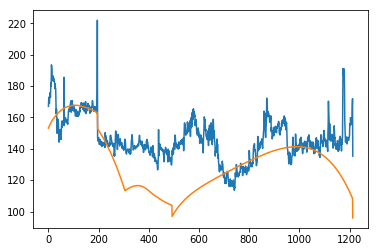


Iter: 3301, running avg elbo: -35007131.5940
Iter: 3302, running avg elbo: -34965381.6180
Iter: 3303, running avg elbo: -34970907.2419
Iter: 3304, running avg elbo: -34963737.7694
Iter: 3305, running avg elbo: -34893987.2518
Iter: 3306, running avg elbo: -34942949.4192
Iter: 3307, running avg elbo: -34877446.7850
Iter: 3308, running avg elbo: -34802034.3372
Iter: 3309, running avg elbo: -34857446.6738
Iter: 3310, running avg elbo: -34781771.3671
Iter: 3311, running avg elbo: -34752327.0734
Iter: 3312, running avg elbo: -34708559.5427
Iter: 3313, running avg elbo: -34723380.9872
Iter: 3314, running avg elbo: -34665499.2174
Iter: 3315, running avg elbo: -34609917.0652
Iter: 3316, running avg elbo: -34554927.3746
Iter: 3317, running avg elbo: -34486687.5408
Iter: 3318, running avg elbo: -34419548.0254
Iter: 3319, running avg elbo: -34406028.1051
Iter: 3320, running avg elbo: -34385148.4641
Iter: 3321, running avg elbo: -34301168.5195
Iter: 3322, running avg elbo: -34230616.1343
Iter: 332

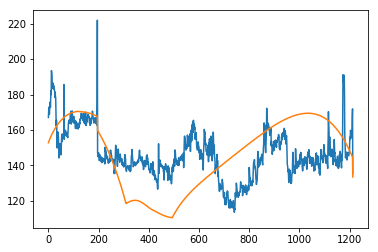


Iter: 3351, running avg elbo: -36379781.0756
Iter: 3352, running avg elbo: -36290801.7648
Iter: 3353, running avg elbo: -36198372.7872
Iter: 3354, running avg elbo: -36089281.1193
Iter: 3355, running avg elbo: -35981729.9881
Iter: 3356, running avg elbo: -35978227.6882
Iter: 3357, running avg elbo: -35867366.6114
Iter: 3358, running avg elbo: -35815476.0452
Iter: 3359, running avg elbo: -35724248.0648
Iter: 3360, running avg elbo: -35773969.1441
Iter: 3361, running avg elbo: -35688661.9527
Iter: 3362, running avg elbo: -35608144.6732
Iter: 3363, running avg elbo: -35513815.4664
Iter: 3364, running avg elbo: -35489388.2518
Iter: 3365, running avg elbo: -35374938.6693
Iter: 3366, running avg elbo: -35287279.2626
Iter: 3367, running avg elbo: -35180533.2299
Iter: 3368, running avg elbo: -35079423.5576
Iter: 3369, running avg elbo: -34998495.1021
Iter: 3370, running avg elbo: -34899205.6710
Iter: 3371, running avg elbo: -34806424.3743
Iter: 3372, running avg elbo: -34700091.3306
Iter: 337

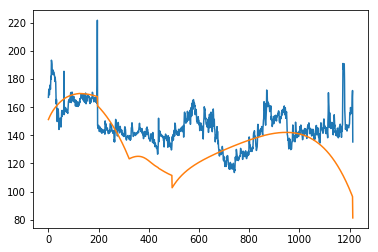


Iter: 3401, running avg elbo: -33002575.8704
Iter: 3402, running avg elbo: -32998233.1317
Iter: 3403, running avg elbo: -32912049.7004
Iter: 3404, running avg elbo: -33144830.4034
Iter: 3405, running avg elbo: -33126392.4193
Iter: 3406, running avg elbo: -33345242.5751
Iter: 3407, running avg elbo: -33319631.3494
Iter: 3408, running avg elbo: -33289605.1359
Iter: 3409, running avg elbo: -33188393.6645
Iter: 3410, running avg elbo: -33110323.1079
Iter: 3411, running avg elbo: -33064432.9968
Iter: 3412, running avg elbo: -32962774.2868
Iter: 3413, running avg elbo: -32888926.2840
Iter: 3414, running avg elbo: -32970505.8611
Iter: 3415, running avg elbo: -32880297.7225
Iter: 3416, running avg elbo: -33381167.9453
Iter: 3417, running avg elbo: -33391657.7058
Iter: 3418, running avg elbo: -33480988.4088
Iter: 3419, running avg elbo: -33714317.2047
Iter: 3420, running avg elbo: -33609222.5926
Iter: 3421, running avg elbo: -33832030.0867
Iter: 3422, running avg elbo: -33708939.5858
Iter: 342

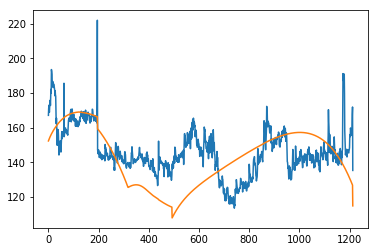


Iter: 3451, running avg elbo: -31654515.2085
Iter: 3452, running avg elbo: -31572414.3764
Iter: 3453, running avg elbo: -31471194.3127
Iter: 3454, running avg elbo: -31551380.5695
Iter: 3455, running avg elbo: -31445665.8039
Iter: 3456, running avg elbo: -31420285.9858
Iter: 3457, running avg elbo: -31368623.5860
Iter: 3458, running avg elbo: -31288591.9501
Iter: 3459, running avg elbo: -31612306.1106
Iter: 3460, running avg elbo: -31704850.0095
Iter: 3461, running avg elbo: -31878777.5894
Iter: 3462, running avg elbo: -32140914.3335
Iter: 3463, running avg elbo: -32033792.5302
Iter: 3464, running avg elbo: -32087451.8449
Iter: 3465, running avg elbo: -32258771.1264
Iter: 3466, running avg elbo: -32154771.1952
Iter: 3467, running avg elbo: -32374806.6032
Iter: 3468, running avg elbo: -32330175.0772
Iter: 3469, running avg elbo: -32267499.2864
Iter: 3470, running avg elbo: -32315031.1735
Iter: 3471, running avg elbo: -32248690.5818
Iter: 3472, running avg elbo: -32164337.7760
Iter: 347

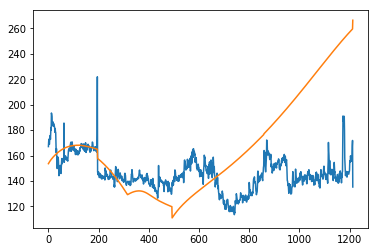


Iter: 3501, running avg elbo: -39663072.6709
Iter: 3502, running avg elbo: -39492251.5441
Iter: 3503, running avg elbo: -39411155.9687
Iter: 3504, running avg elbo: -39302871.1490
Iter: 3505, running avg elbo: -39132813.3575
Iter: 3506, running avg elbo: -39441194.4240
Iter: 3507, running avg elbo: -39271156.0797
Iter: 3508, running avg elbo: -39087848.9189
Iter: 3509, running avg elbo: -39045020.1097
Iter: 3510, running avg elbo: -38868980.2486
Iter: 3511, running avg elbo: -38777596.6061
Iter: 3512, running avg elbo: -38975824.3201
Iter: 3513, running avg elbo: -38974211.5169
Iter: 3514, running avg elbo: -38786799.3017
Iter: 3515, running avg elbo: -38871948.5887
Iter: 3516, running avg elbo: -38806809.8828
Iter: 3517, running avg elbo: -38611334.1240
Iter: 3518, running avg elbo: -38845657.2227
Iter: 3519, running avg elbo: -38746406.0705
Iter: 3520, running avg elbo: -38548778.7098
Iter: 3521, running avg elbo: -38567830.3627
Iter: 3522, running avg elbo: -38527973.2591
Iter: 352

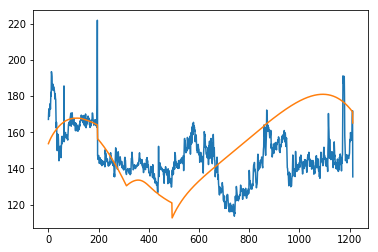


Iter: 3551, running avg elbo: -36789036.9017
Iter: 3552, running avg elbo: -36845275.0127
Iter: 3553, running avg elbo: -36909793.8626
Iter: 3554, running avg elbo: -36775154.2639
Iter: 3555, running avg elbo: -37188936.8813
Iter: 3556, running avg elbo: -36999089.4925
Iter: 3557, running avg elbo: -36834254.0776
Iter: 3558, running avg elbo: -36894193.8168
Iter: 3559, running avg elbo: -36757469.3986
Iter: 3560, running avg elbo: -36627647.8846
Iter: 3561, running avg elbo: -36601006.8858
Iter: 3562, running avg elbo: -36425033.2169
Iter: 3563, running avg elbo: -36264577.8847
Iter: 3564, running avg elbo: -36078599.9259
Iter: 3565, running avg elbo: -35900144.1066
Iter: 3566, running avg elbo: -35907171.8256
Iter: 3567, running avg elbo: -35735574.7073
Iter: 3568, running avg elbo: -35636097.5202
Iter: 3569, running avg elbo: -35580181.6050
Iter: 3570, running avg elbo: -35432047.5090
Iter: 3571, running avg elbo: -35288055.9339
Iter: 3572, running avg elbo: -35110011.9146
Iter: 357

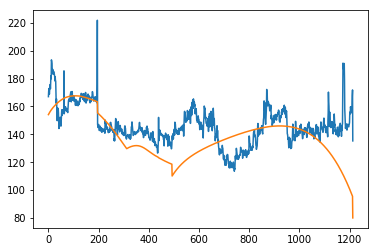


Iter: 3601, running avg elbo: -34167313.2014
Iter: 3602, running avg elbo: -34149831.8494
Iter: 3603, running avg elbo: -34036266.9909
Iter: 3604, running avg elbo: -34271957.0410
Iter: 3605, running avg elbo: -34204957.4506
Iter: 3606, running avg elbo: -34118121.4961
Iter: 3607, running avg elbo: -34318456.8811
Iter: 3608, running avg elbo: -34216436.0923
Iter: 3609, running avg elbo: -34207249.4714
Iter: 3610, running avg elbo: -34176972.9366
Iter: 3611, running avg elbo: -34133061.3673
Iter: 3612, running avg elbo: -33984477.6136
Iter: 3613, running avg elbo: -33979275.5975
Iter: 3614, running avg elbo: -33888955.1215
Iter: 3615, running avg elbo: -33719647.1103
Iter: 3616, running avg elbo: -33703120.4992
Iter: 3617, running avg elbo: -33609398.5942
Iter: 3618, running avg elbo: -33441648.4082
Iter: 3619, running avg elbo: -33362642.5442
Iter: 3620, running avg elbo: -33284053.7987
Iter: 3621, running avg elbo: -33220362.6207
Iter: 3622, running avg elbo: -33387229.9945
Iter: 362

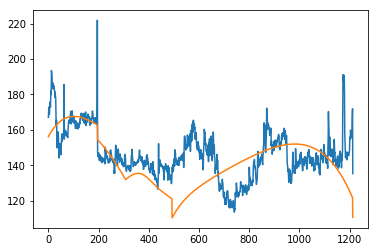


Iter: 3651, running avg elbo: -35364159.1695
Iter: 3652, running avg elbo: -35235184.7178
Iter: 3653, running avg elbo: -35050437.0406
Iter: 3654, running avg elbo: -34878566.2902
Iter: 3655, running avg elbo: -34723528.2073
Iter: 3656, running avg elbo: -34556947.6252
Iter: 3657, running avg elbo: -34688728.8690
Iter: 3658, running avg elbo: -34505527.2103
Iter: 3659, running avg elbo: -34654010.0182
Iter: 3660, running avg elbo: -34516181.7180
Iter: 3661, running avg elbo: -34789758.2208
Iter: 3662, running avg elbo: -34653880.2786
Iter: 3663, running avg elbo: -34757084.9158
Iter: 3664, running avg elbo: -34894979.1067
Iter: 3665, running avg elbo: -35028577.3556
Iter: 3666, running avg elbo: -35224077.7420
Iter: 3667, running avg elbo: -35428167.0446
Iter: 3668, running avg elbo: -35422892.7742
Iter: 3669, running avg elbo: -35371102.1264
Iter: 3670, running avg elbo: -36037516.0652
Iter: 3671, running avg elbo: -36020243.9845
Iter: 3672, running avg elbo: -36209449.1447
Iter: 367

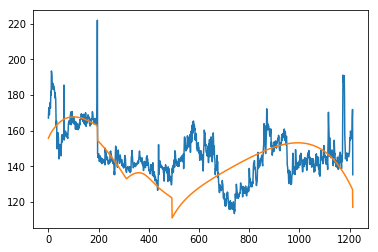


Iter: 3701, running avg elbo: -34429124.2159
Iter: 3702, running avg elbo: -34250350.6438
Iter: 3703, running avg elbo: -34262071.0173
Iter: 3704, running avg elbo: -34090520.9472
Iter: 3705, running avg elbo: -34026944.2377
Iter: 3706, running avg elbo: -33862896.0553
Iter: 3707, running avg elbo: -33686006.9747
Iter: 3708, running avg elbo: -33743942.9450
Iter: 3709, running avg elbo: -33603571.1156
Iter: 3710, running avg elbo: -33445374.2644
Iter: 3711, running avg elbo: -33418127.2618
Iter: 3712, running avg elbo: -33247378.0691
Iter: 3713, running avg elbo: -33095476.5684
Iter: 3714, running avg elbo: -32941259.3428
Iter: 3715, running avg elbo: -33152858.9493
Iter: 3716, running avg elbo: -32984141.4798
Iter: 3717, running avg elbo: -32910097.4450
Iter: 3718, running avg elbo: -32960943.6306
Iter: 3719, running avg elbo: -32809891.1343
Iter: 3720, running avg elbo: -33059798.7029
Iter: 3721, running avg elbo: -32885057.6859
Iter: 3722, running avg elbo: -32720908.2891
Iter: 372

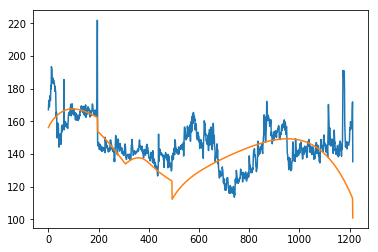


Iter: 3751, running avg elbo: -31109134.7182
Iter: 3752, running avg elbo: -31047238.8110
Iter: 3753, running avg elbo: -30901145.6729
Iter: 3754, running avg elbo: -30777283.4762
Iter: 3755, running avg elbo: -30666480.9014
Iter: 3756, running avg elbo: -30551208.3524
Iter: 3757, running avg elbo: -30425308.7889
Iter: 3758, running avg elbo: -30295651.5210
Iter: 3759, running avg elbo: -30618277.2058
Iter: 3760, running avg elbo: -30477688.2537
Iter: 3761, running avg elbo: -30789168.3712
Iter: 3762, running avg elbo: -30869670.9675
Iter: 3763, running avg elbo: -30750291.1378
Iter: 3764, running avg elbo: -30990755.5464
Iter: 3765, running avg elbo: -31050537.8710
Iter: 3766, running avg elbo: -30960566.5123
Iter: 3767, running avg elbo: -30817685.8371
Iter: 3768, running avg elbo: -30803462.8988
Iter: 3769, running avg elbo: -31881804.7498
Iter: 3770, running avg elbo: -31718348.0023
Iter: 3771, running avg elbo: -32291898.0423
Iter: 3772, running avg elbo: -32422155.3418
Iter: 377

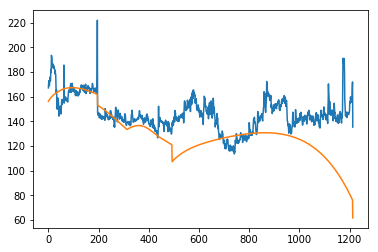


Iter: 3801, running avg elbo: -36731825.8762
Iter: 3802, running avg elbo: -36569034.5174
Iter: 3803, running avg elbo: -36454919.6923
Iter: 3804, running avg elbo: -36424780.6553
Iter: 3805, running avg elbo: -36226468.4788
Iter: 3806, running avg elbo: -36021086.8940
Iter: 3807, running avg elbo: -36056125.9850
Iter: 3808, running avg elbo: -35862477.5852
Iter: 3809, running avg elbo: -35754542.4293
Iter: 3810, running avg elbo: -35554020.5951
Iter: 3811, running avg elbo: -35350003.5191
Iter: 3812, running avg elbo: -35191016.1039
Iter: 3813, running avg elbo: -35155816.3029
Iter: 3814, running avg elbo: -34975647.9198
Iter: 3815, running avg elbo: -34812712.5806
Iter: 3816, running avg elbo: -34700599.1348
Iter: 3817, running avg elbo: -34523260.2235
Iter: 3818, running avg elbo: -34431005.9213
Iter: 3819, running avg elbo: -34369805.7220
Iter: 3820, running avg elbo: -34201249.1248
Iter: 3821, running avg elbo: -34111441.9936
Iter: 3822, running avg elbo: -33967537.7736
Iter: 382

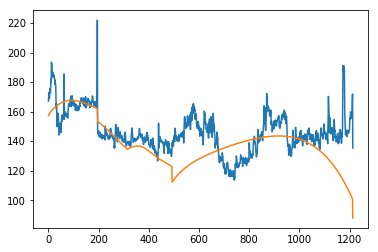


Iter: 3851, running avg elbo: -30898077.3331
Iter: 3852, running avg elbo: -30739022.8398
Iter: 3853, running avg elbo: -30781254.7314
Iter: 3854, running avg elbo: -30625791.7141
Iter: 3855, running avg elbo: -30501345.9969
Iter: 3856, running avg elbo: -30350454.4570
Iter: 3857, running avg elbo: -30258852.8124
Iter: 3858, running avg elbo: -30126251.3643
Iter: 3859, running avg elbo: -29977943.3706
Iter: 3860, running avg elbo: -29833225.4469
Iter: 3861, running avg elbo: -29736075.3124
Iter: 3862, running avg elbo: -29617454.7793
Iter: 3863, running avg elbo: -29474326.4515
Iter: 3864, running avg elbo: -29438580.3870
Iter: 3865, running avg elbo: -29318310.8031
Iter: 3866, running avg elbo: -29227806.1151
Iter: 3867, running avg elbo: -29420796.2140
Iter: 3868, running avg elbo: -29314343.7718
Iter: 3869, running avg elbo: -29187132.8041
Iter: 3870, running avg elbo: -29060587.2061
Iter: 3871, running avg elbo: -29099261.1140
Iter: 3872, running avg elbo: -28999370.4429
Iter: 387

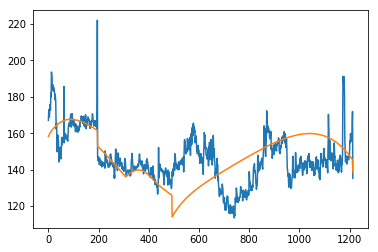


Iter: 3901, running avg elbo: -26974976.8454
Iter: 3902, running avg elbo: -27013296.1369
Iter: 3903, running avg elbo: -26904736.8356
Iter: 3904, running avg elbo: -26848277.2072
Iter: 3905, running avg elbo: -26733057.0851
Iter: 3906, running avg elbo: -26682668.2343
Iter: 3907, running avg elbo: -26716156.6120
Iter: 3908, running avg elbo: -26642389.9858
Iter: 3909, running avg elbo: -26674890.0860
Iter: 3910, running avg elbo: -26820188.5851
Iter: 3911, running avg elbo: -26856650.8593
Iter: 3912, running avg elbo: -26940755.2707
Iter: 3913, running avg elbo: -26976363.0380
Iter: 3914, running avg elbo: -26867157.3476
Iter: 3915, running avg elbo: -27060053.2141
Iter: 3916, running avg elbo: -27157257.0820
Iter: 3917, running avg elbo: -27037782.8011
Iter: 3918, running avg elbo: -27045129.5731
Iter: 3919, running avg elbo: -27269158.0374
Iter: 3920, running avg elbo: -27160766.9070
Iter: 3921, running avg elbo: -27050587.4980
Iter: 3922, running avg elbo: -26988369.9630
Iter: 392

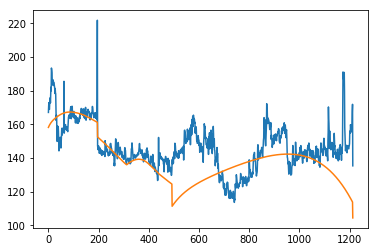


Iter: 3951, running avg elbo: -30047323.6974
Iter: 3952, running avg elbo: -29896463.5005
Iter: 3953, running avg elbo: -30014780.8655
Iter: 3954, running avg elbo: -29873764.0768
Iter: 3955, running avg elbo: -29769237.6160
Iter: 3956, running avg elbo: -29621511.8599
Iter: 3957, running avg elbo: -29501119.8013
Iter: 3958, running avg elbo: -29366491.4133
Iter: 3959, running avg elbo: -29462412.0991
Iter: 3960, running avg elbo: -29316461.5781
Iter: 3961, running avg elbo: -29222867.6424
Iter: 3962, running avg elbo: -29137683.6259
Iter: 3963, running avg elbo: -28991963.5997
Iter: 3964, running avg elbo: -28877221.8237
Iter: 3965, running avg elbo: -28732957.9854
Iter: 3966, running avg elbo: -28588307.9056
Iter: 3967, running avg elbo: -28453109.6665
Iter: 3968, running avg elbo: -28311374.4999
Iter: 3969, running avg elbo: -28171166.2349
Iter: 3970, running avg elbo: -28040357.7725
Iter: 3971, running avg elbo: -27901868.7548
Iter: 3972, running avg elbo: -27767508.7573
Iter: 397

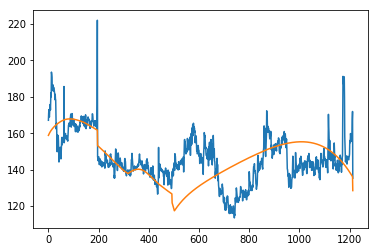


Iter: 4001, running avg elbo: -24989218.9796
Iter: 4002, running avg elbo: -24886342.1298
Iter: 4003, running avg elbo: -24779514.0285
Iter: 4004, running avg elbo: -24734243.6682
Iter: 4005, running avg elbo: -24602719.5815
Iter: 4006, running avg elbo: -24487436.3957
Iter: 4007, running avg elbo: -24370592.6618
Iter: 4008, running avg elbo: -24256606.7851
Iter: 4009, running avg elbo: -24149026.4173
Iter: 4010, running avg elbo: -24021372.8731
Iter: 4011, running avg elbo: -23904018.8944
Iter: 4012, running avg elbo: -23795955.7354
Iter: 4013, running avg elbo: -23679036.1481
Iter: 4014, running avg elbo: -23587639.5266
Iter: 4015, running avg elbo: -23461601.0213
Iter: 4016, running avg elbo: -23318347.1111
Iter: 4017, running avg elbo: -23339821.1200
Iter: 4018, running avg elbo: -23223084.0288
Iter: 4019, running avg elbo: -23173115.8485
Iter: 4020, running avg elbo: -23083741.4700
Iter: 4021, running avg elbo: -23004334.6153
Iter: 4022, running avg elbo: -22919704.4092
Iter: 402

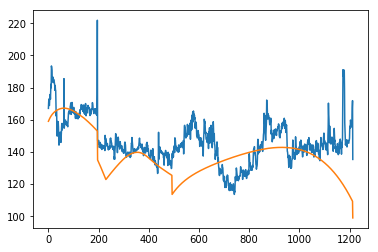


Iter: 4051, running avg elbo: -22466765.3479
Iter: 4052, running avg elbo: -22477514.8144
Iter: 4053, running avg elbo: -22595293.0263
Iter: 4054, running avg elbo: -22514755.6860
Iter: 4055, running avg elbo: -22499251.2891
Iter: 4056, running avg elbo: -22474981.9963
Iter: 4057, running avg elbo: -22392199.0263
Iter: 4058, running avg elbo: -22322435.7860
Iter: 4059, running avg elbo: -22338595.3282
Iter: 4060, running avg elbo: -22255593.0849
Iter: 4061, running avg elbo: -22182868.7040
Iter: 4062, running avg elbo: -22129201.4570
Iter: 4063, running avg elbo: -22053965.0024
Iter: 4064, running avg elbo: -21988094.8824
Iter: 4065, running avg elbo: -21912655.2236
Iter: 4066, running avg elbo: -21876897.8513
Iter: 4067, running avg elbo: -21914453.5128
Iter: 4068, running avg elbo: -21895676.2577
Iter: 4069, running avg elbo: -21872911.6351
Iter: 4070, running avg elbo: -22031789.9988
Iter: 4071, running avg elbo: -21955072.4988
Iter: 4072, running avg elbo: -21969973.0138
Iter: 407

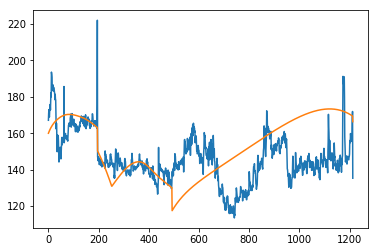


Iter: 4101, running avg elbo: -23307356.0714
Iter: 4102, running avg elbo: -23531451.7507
Iter: 4103, running avg elbo: -23572628.0732
Iter: 4104, running avg elbo: -23486218.5224
Iter: 4105, running avg elbo: -23499942.1572
Iter: 4106, running avg elbo: -23566819.9757
Iter: 4107, running avg elbo: -23503533.5359
Iter: 4108, running avg elbo: -23648335.0005
Iter: 4109, running avg elbo: -23665195.7705
Iter: 4110, running avg elbo: -23590370.6828
Iter: 4111, running avg elbo: -23792619.2560
Iter: 4112, running avg elbo: -23809989.6034
Iter: 4113, running avg elbo: -23732523.7174
Iter: 4114, running avg elbo: -23792915.8602
Iter: 4115, running avg elbo: -23764691.0216
Iter: 4116, running avg elbo: -23752692.3514
Iter: 4117, running avg elbo: -23653231.1579
Iter: 4118, running avg elbo: -23666481.2263
Iter: 4119, running avg elbo: -23871111.1341
Iter: 4120, running avg elbo: -23834192.2027
Iter: 4121, running avg elbo: -23996019.3207
Iter: 4122, running avg elbo: -24394075.5675
Iter: 412

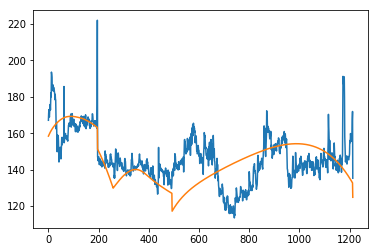


Iter: 4151, running avg elbo: -23689399.1121
Iter: 4152, running avg elbo: -23595758.4610
Iter: 4153, running avg elbo: -23657552.5763
Iter: 4154, running avg elbo: -23615938.4506
Iter: 4155, running avg elbo: -23535580.4061
Iter: 4156, running avg elbo: -23498856.9820
Iter: 4157, running avg elbo: -23548465.8922
Iter: 4158, running avg elbo: -23558662.7333
Iter: 4159, running avg elbo: -23524308.9659
Iter: 4160, running avg elbo: -23597541.0963
Iter: 4161, running avg elbo: -23642912.4653
Iter: 4162, running avg elbo: -23584847.3807
Iter: 4163, running avg elbo: -23627063.1469
Iter: 4164, running avg elbo: -23576058.3954
Iter: 4165, running avg elbo: -23475510.8114
Iter: 4166, running avg elbo: -23416475.8233
Iter: 4167, running avg elbo: -23459250.9451
Iter: 4168, running avg elbo: -23368443.6056
Iter: 4169, running avg elbo: -23298310.7396
Iter: 4170, running avg elbo: -23228785.6022
Iter: 4171, running avg elbo: -23156997.7962
Iter: 4172, running avg elbo: -23195221.4582
Iter: 417

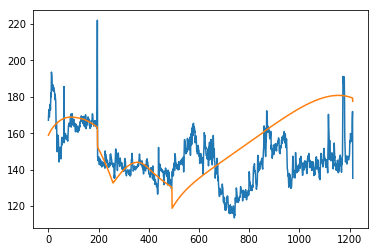


Iter: 4201, running avg elbo: -23177073.3040
Iter: 4202, running avg elbo: -23200319.7110
Iter: 4203, running avg elbo: -23118968.9739
Iter: 4204, running avg elbo: -23350011.8042
Iter: 4205, running avg elbo: -23340237.0261
Iter: 4206, running avg elbo: -23242471.1359
Iter: 4207, running avg elbo: -23183135.4445
Iter: 4208, running avg elbo: -23246269.8901
Iter: 4209, running avg elbo: -23275892.2112
Iter: 4210, running avg elbo: -23213117.2490
Iter: 4211, running avg elbo: -23311707.0165
Iter: 4212, running avg elbo: -23373426.2264
Iter: 4213, running avg elbo: -23324219.8041
Iter: 4214, running avg elbo: -23338010.0261
Iter: 4215, running avg elbo: -23314250.4658
Iter: 4216, running avg elbo: -23214197.4112
Iter: 4217, running avg elbo: -23125028.9370
Iter: 4218, running avg elbo: -23216209.0477
Iter: 4219, running avg elbo: -23277535.8972
Iter: 4220, running avg elbo: -23238541.6782
Iter: 4221, running avg elbo: -23302834.1214
Iter: 4222, running avg elbo: -23219755.4502
Iter: 422

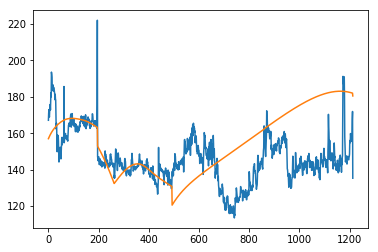


Iter: 4251, running avg elbo: -22528792.5336
Iter: 4252, running avg elbo: -22519120.5482
Iter: 4253, running avg elbo: -22435331.5827
Iter: 4254, running avg elbo: -22344018.5369
Iter: 4255, running avg elbo: -22297224.0715
Iter: 4256, running avg elbo: -22219929.1208
Iter: 4257, running avg elbo: -22184257.7496
Iter: 4258, running avg elbo: -22093825.6421
Iter: 4259, running avg elbo: -22004170.6357
Iter: 4260, running avg elbo: -21913381.2694
Iter: 4261, running avg elbo: -21830658.7367
Iter: 4262, running avg elbo: -21794230.1093
Iter: 4263, running avg elbo: -21722414.1782
Iter: 4264, running avg elbo: -21634846.3764
Iter: 4265, running avg elbo: -21601473.1127
Iter: 4266, running avg elbo: -21523622.2815
Iter: 4267, running avg elbo: -21505534.4587
Iter: 4268, running avg elbo: -21427437.7141
Iter: 4269, running avg elbo: -21344614.8570
Iter: 4270, running avg elbo: -21266142.0884
Iter: 4271, running avg elbo: -21190736.0875
Iter: 4272, running avg elbo: -21108584.4167
Iter: 427

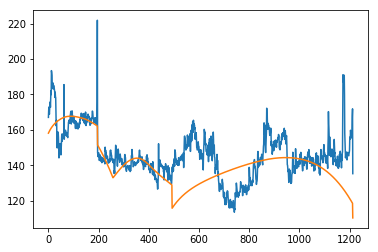


Iter: 4301, running avg elbo: -20380806.0851
Iter: 4302, running avg elbo: -20319664.1743
Iter: 4303, running avg elbo: -20287599.2726
Iter: 4304, running avg elbo: -20280525.2198
Iter: 4305, running avg elbo: -20221493.8476
Iter: 4306, running avg elbo: -20153296.3292
Iter: 4307, running avg elbo: -20231945.6859
Iter: 4308, running avg elbo: -20162842.8290
Iter: 4309, running avg elbo: -20096533.0507
Iter: 4310, running avg elbo: -20047789.4602
Iter: 4311, running avg elbo: -20036895.8456
Iter: 4312, running avg elbo: -20018429.2471
Iter: 4313, running avg elbo: -19954332.3947
Iter: 4314, running avg elbo: -19931945.4107
Iter: 4315, running avg elbo: -19916767.1366
Iter: 4316, running avg elbo: -19861592.9753
Iter: 4317, running avg elbo: -19810603.9055
Iter: 4318, running avg elbo: -19880154.0864
Iter: 4319, running avg elbo: -19844915.1556
Iter: 4320, running avg elbo: -19873617.1840
Iter: 4321, running avg elbo: -19865316.5122
Iter: 4322, running avg elbo: -19795506.8171
Iter: 432

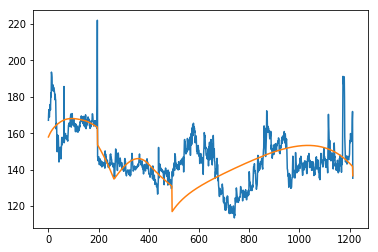


Iter: 4351, running avg elbo: -18551300.3112
Iter: 4352, running avg elbo: -18543485.9881
Iter: 4353, running avg elbo: -18591690.1482
Iter: 4354, running avg elbo: -18537584.7367
Iter: 4355, running avg elbo: -18495173.2193
Iter: 4356, running avg elbo: -18437556.4171
Iter: 4357, running avg elbo: -18382536.4130
Iter: 4358, running avg elbo: -18368471.4688
Iter: 4359, running avg elbo: -18386064.4941
Iter: 4360, running avg elbo: -18339672.0592
Iter: 4361, running avg elbo: -18288726.5586
Iter: 4362, running avg elbo: -18236678.7430
Iter: 4363, running avg elbo: -18191785.0156
Iter: 4364, running avg elbo: -18137081.7954
Iter: 4365, running avg elbo: -18091201.0475
Iter: 4366, running avg elbo: -18039050.6070
Iter: 4367, running avg elbo: -18012350.4709
Iter: 4368, running avg elbo: -17958805.8462
Iter: 4369, running avg elbo: -17919176.5678
Iter: 4370, running avg elbo: -17873388.5721
Iter: 4371, running avg elbo: -17828240.6664
Iter: 4372, running avg elbo: -17903487.7797
Iter: 437

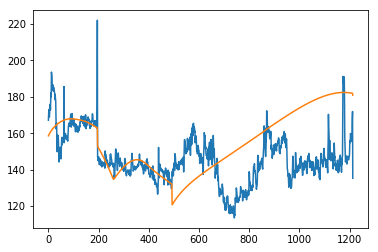


Iter: 4401, running avg elbo: -18705411.8715
Iter: 4402, running avg elbo: -18868558.2327
Iter: 4403, running avg elbo: -19004021.9904
Iter: 4404, running avg elbo: -18942511.2105
Iter: 4405, running avg elbo: -18943701.9984
Iter: 4406, running avg elbo: -19108089.1784
Iter: 4407, running avg elbo: -19056746.7166
Iter: 4408, running avg elbo: -18997075.2595
Iter: 4409, running avg elbo: -19070360.7669
Iter: 4410, running avg elbo: -19142181.4592
Iter: 4411, running avg elbo: -19076839.4546
Iter: 4412, running avg elbo: -19050665.3401
Iter: 4413, running avg elbo: -19043842.6067
Iter: 4414, running avg elbo: -19016616.7706
Iter: 4415, running avg elbo: -18969648.1729
Iter: 4416, running avg elbo: -18939459.1112
Iter: 4417, running avg elbo: -18894289.3601
Iter: 4418, running avg elbo: -18830426.2065
Iter: 4419, running avg elbo: -18815771.1844
Iter: 4420, running avg elbo: -18754018.6625
Iter: 4421, running avg elbo: -18693955.7059
Iter: 4422, running avg elbo: -18640481.9589
Iter: 442

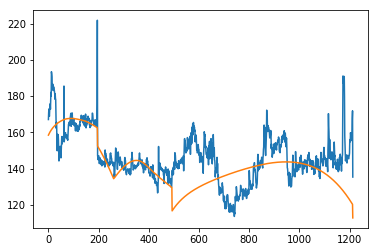


Iter: 4451, running avg elbo: -17679912.2868
Iter: 4452, running avg elbo: -17652194.2839
Iter: 4453, running avg elbo: -17631302.2811
Iter: 4454, running avg elbo: -17778760.8383
Iter: 4455, running avg elbo: -17763903.8199
Iter: 4456, running avg elbo: -17797697.1817
Iter: 4457, running avg elbo: -17881828.7099
Iter: 4458, running avg elbo: -17889642.4828
Iter: 4459, running avg elbo: -17903461.2380
Iter: 4460, running avg elbo: -17926893.4456
Iter: 4461, running avg elbo: -17880321.1111
Iter: 4462, running avg elbo: -17824679.7200
Iter: 4463, running avg elbo: -17771288.0828
Iter: 4464, running avg elbo: -17730648.4620
Iter: 4465, running avg elbo: -17709582.5374
Iter: 4466, running avg elbo: -17659947.0320
Iter: 4467, running avg elbo: -17614943.5217
Iter: 4468, running avg elbo: -17577637.5765
Iter: 4469, running avg elbo: -17651607.2207
Iter: 4470, running avg elbo: -17599528.3785
Iter: 4471, running avg elbo: -17627110.7147
Iter: 4472, running avg elbo: -17692191.6676
Iter: 447

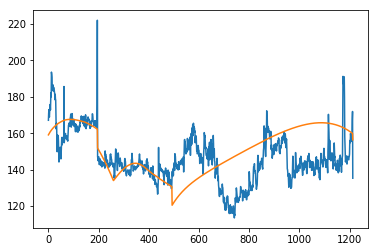


Iter: 4501, running avg elbo: -17553745.7074
Iter: 4502, running avg elbo: -17516001.9903
Iter: 4503, running avg elbo: -17532761.9304
Iter: 4504, running avg elbo: -17483138.9111
Iter: 4505, running avg elbo: -17459767.6020
Iter: 4506, running avg elbo: -17421347.5160
Iter: 4507, running avg elbo: -17370849.7408
Iter: 4508, running avg elbo: -17325177.6734
Iter: 4509, running avg elbo: -17288852.1267
Iter: 4510, running avg elbo: -17240670.3554
Iter: 4511, running avg elbo: -17203373.1519
Iter: 4512, running avg elbo: -17242902.5803
Iter: 4513, running avg elbo: -17193645.0345
Iter: 4514, running avg elbo: -17145410.8042
Iter: 4515, running avg elbo: -17173039.9162
Iter: 4516, running avg elbo: -17205903.7970
Iter: 4517, running avg elbo: -17160090.4090
Iter: 4518, running avg elbo: -17180425.9049
Iter: 4519, running avg elbo: -17197267.8059
Iter: 4520, running avg elbo: -17147417.2478
Iter: 4521, running avg elbo: -17130045.8553
Iter: 4522, running avg elbo: -17121285.8868
Iter: 452

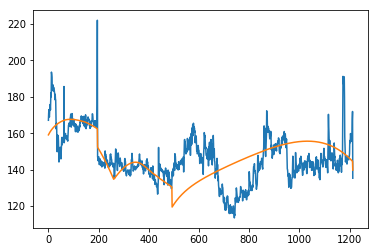


Iter: 4551, running avg elbo: -16370482.7736
Iter: 4552, running avg elbo: -16398059.0058
Iter: 4553, running avg elbo: -16358767.8758
Iter: 4554, running avg elbo: -16370461.4370
Iter: 4555, running avg elbo: -16448635.5026
Iter: 4556, running avg elbo: -16410598.3576
Iter: 4557, running avg elbo: -16406809.7140
Iter: 4558, running avg elbo: -16433666.1569
Iter: 4559, running avg elbo: -16451821.7353
Iter: 4560, running avg elbo: -16413002.5580
Iter: 4561, running avg elbo: -16514350.4324
Iter: 4562, running avg elbo: -16490528.8881
Iter: 4563, running avg elbo: -16462872.4392
Iter: 4564, running avg elbo: -16435630.7248
Iter: 4565, running avg elbo: -16399536.5875
Iter: 4566, running avg elbo: -16364100.8517
Iter: 4567, running avg elbo: -16323676.2732
Iter: 4568, running avg elbo: -16284928.4904
Iter: 4569, running avg elbo: -16242964.1455
Iter: 4570, running avg elbo: -16227577.2641
Iter: 4571, running avg elbo: -16188137.2814
Iter: 4572, running avg elbo: -16169704.4586
Iter: 457

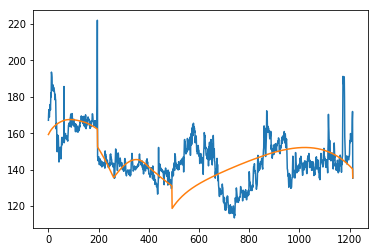


Iter: 4601, running avg elbo: -16009060.5817
Iter: 4602, running avg elbo: -16002711.8859
Iter: 4603, running avg elbo: -15963747.5270
Iter: 4604, running avg elbo: -15945697.2418
Iter: 4605, running avg elbo: -15938878.6393
Iter: 4606, running avg elbo: -15913399.5729
Iter: 4607, running avg elbo: -15884143.2072
Iter: 4608, running avg elbo: -15865131.3051
Iter: 4609, running avg elbo: -15893070.8521
Iter: 4610, running avg elbo: -15854473.4936
Iter: 4611, running avg elbo: -15856644.8586
Iter: 4612, running avg elbo: -15852878.4700
Iter: 4613, running avg elbo: -15825833.9253
Iter: 4614, running avg elbo: -15789722.2661
Iter: 4615, running avg elbo: -15808267.6234
Iter: 4616, running avg elbo: -15791660.3172
Iter: 4617, running avg elbo: -15763507.9240
Iter: 4618, running avg elbo: -15733851.0248
Iter: 4619, running avg elbo: -15707223.8145
Iter: 4620, running avg elbo: -15696283.9964
Iter: 4621, running avg elbo: -15722085.4364
Iter: 4622, running avg elbo: -15692075.8821
Iter: 462

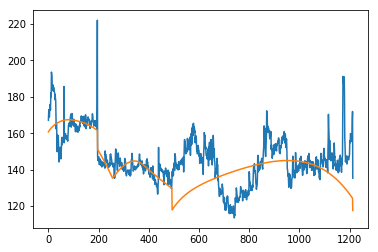


Iter: 4651, running avg elbo: -15561548.0789
Iter: 4652, running avg elbo: -15669069.9581
Iter: 4653, running avg elbo: -15642965.9085
Iter: 4654, running avg elbo: -15706267.1294
Iter: 4655, running avg elbo: -15774652.0181
Iter: 4656, running avg elbo: -15744403.3280
Iter: 4657, running avg elbo: -15749119.2147
Iter: 4658, running avg elbo: -15882682.7625
Iter: 4659, running avg elbo: -15847880.7549
Iter: 4660, running avg elbo: -15808951.2674
Iter: 4661, running avg elbo: -15827944.8747
Iter: 4662, running avg elbo: -15871031.2859
Iter: 4663, running avg elbo: -15835015.8531
Iter: 4664, running avg elbo: -15815435.1146
Iter: 4665, running avg elbo: -15817165.2634
Iter: 4666, running avg elbo: -15850184.9108
Iter: 4667, running avg elbo: -15811317.3917
Iter: 4668, running avg elbo: -15839404.9577
Iter: 4669, running avg elbo: -15841113.5382
Iter: 4670, running avg elbo: -15836975.5328
Iter: 4671, running avg elbo: -15808437.4175
Iter: 4672, running avg elbo: -15808691.9833
Iter: 467

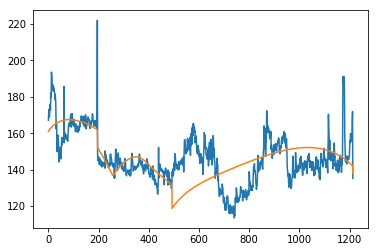


Iter: 4701, running avg elbo: -15661310.4237
Iter: 4702, running avg elbo: -15661690.0194
Iter: 4703, running avg elbo: -15631913.2192
Iter: 4704, running avg elbo: -15714091.1271
Iter: 4705, running avg elbo: -15744820.3758
Iter: 4706, running avg elbo: -15738365.4820
Iter: 4707, running avg elbo: -15793466.0472
Iter: 4708, running avg elbo: -15785582.1867
Iter: 4709, running avg elbo: -15753601.3249
Iter: 4710, running avg elbo: -15894800.5716
Iter: 4711, running avg elbo: -15930963.6059
Iter: 4712, running avg elbo: -15890815.7798
Iter: 4713, running avg elbo: -15925399.4620
Iter: 4714, running avg elbo: -15948486.3874
Iter: 4715, running avg elbo: -15913951.4235
Iter: 4716, running avg elbo: -15927681.2893
Iter: 4717, running avg elbo: -15968651.2364
Iter: 4718, running avg elbo: -15927487.0041
Iter: 4719, running avg elbo: -15891896.0340
Iter: 4720, running avg elbo: -15892085.8237
Iter: 4721, running avg elbo: -15852754.1254
Iter: 4722, running avg elbo: -15841496.0342
Iter: 472

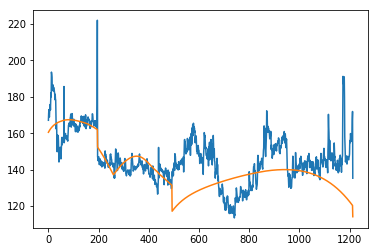


Iter: 4751, running avg elbo: -15566634.0314
Iter: 4752, running avg elbo: -15585094.6711
Iter: 4753, running avg elbo: -15546079.2144
Iter: 4754, running avg elbo: -15507220.3123
Iter: 4755, running avg elbo: -15508116.5692
Iter: 4756, running avg elbo: -15493595.6235
Iter: 4757, running avg elbo: -15455500.9372
Iter: 4758, running avg elbo: -15425853.4679
Iter: 4759, running avg elbo: -15399494.1932
Iter: 4760, running avg elbo: -15414249.9512
Iter: 4761, running avg elbo: -15405383.7017
Iter: 4762, running avg elbo: -15398366.8547
Iter: 4763, running avg elbo: -15363457.3962
Iter: 4764, running avg elbo: -15352319.4422
Iter: 4765, running avg elbo: -15395606.2678
Iter: 4766, running avg elbo: -15402280.8251
Iter: 4767, running avg elbo: -15377056.9769
Iter: 4768, running avg elbo: -15379294.3171
Iter: 4769, running avg elbo: -15462040.4339
Iter: 4770, running avg elbo: -15443970.2296
Iter: 4771, running avg elbo: -15463701.5873
Iter: 4772, running avg elbo: -15556065.2114
Iter: 477

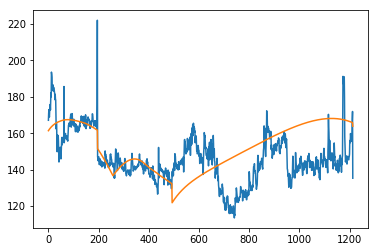


Iter: 4801, running avg elbo: -15301538.6618
Iter: 4802, running avg elbo: -15308017.2152
Iter: 4803, running avg elbo: -15364906.2031
Iter: 4804, running avg elbo: -15328101.7210
Iter: 4805, running avg elbo: -15339921.9238
Iter: 4806, running avg elbo: -15337004.6746
Iter: 4807, running avg elbo: -15299022.6778
Iter: 4808, running avg elbo: -15266708.2311
Iter: 4809, running avg elbo: -15250450.8188
Iter: 4810, running avg elbo: -15213935.2306
Iter: 4811, running avg elbo: -15176747.1483
Iter: 4812, running avg elbo: -15149278.0868
Iter: 4813, running avg elbo: -15116089.1859
Iter: 4814, running avg elbo: -15080015.0141
Iter: 4815, running avg elbo: -15054463.4639
Iter: 4816, running avg elbo: -15021394.8993
Iter: 4817, running avg elbo: -14985922.1403
Iter: 4818, running avg elbo: -14952400.8789
Iter: 4819, running avg elbo: -14917377.3501
Iter: 4820, running avg elbo: -14883244.2966
Iter: 4821, running avg elbo: -14850321.5836
Iter: 4822, running avg elbo: -14817214.9478
Iter: 482

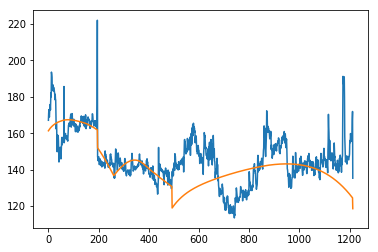


Iter: 4851, running avg elbo: -14245496.8338
Iter: 4852, running avg elbo: -14230945.4154
Iter: 4853, running avg elbo: -14264539.3813
Iter: 4854, running avg elbo: -14266376.2375
Iter: 4855, running avg elbo: -14248886.6251
Iter: 4856, running avg elbo: -14272857.1888
Iter: 4857, running avg elbo: -14304058.4569
Iter: 4858, running avg elbo: -14274818.0524
Iter: 4859, running avg elbo: -14310183.8719
Iter: 4860, running avg elbo: -14286333.6331
Iter: 4861, running avg elbo: -14261979.8468
Iter: 4862, running avg elbo: -14236035.7683
Iter: 4863, running avg elbo: -14291095.5707
Iter: 4864, running avg elbo: -14264281.1549
Iter: 4865, running avg elbo: -14277305.1834
Iter: 4866, running avg elbo: -14284530.4416
Iter: 4867, running avg elbo: -14258220.5571
Iter: 4868, running avg elbo: -14246651.0716
Iter: 4869, running avg elbo: -14244028.3009
Iter: 4870, running avg elbo: -14215804.6479
Iter: 4871, running avg elbo: -14224135.3814
Iter: 4872, running avg elbo: -14208348.1776
Iter: 487

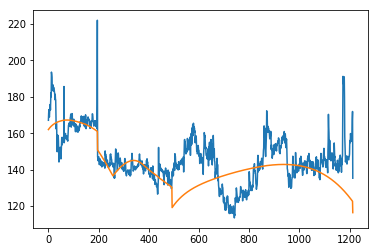


Iter: 4901, running avg elbo: -14038308.7452
Iter: 4902, running avg elbo: -14068408.4178
Iter: 4903, running avg elbo: -14102500.7336
Iter: 4904, running avg elbo: -14079555.0462
Iter: 4905, running avg elbo: -14083833.7458
Iter: 4906, running avg elbo: -14100507.9383
Iter: 4907, running avg elbo: -14074104.5989
Iter: 4908, running avg elbo: -14047149.1829
Iter: 4909, running avg elbo: -14023939.2611
Iter: 4910, running avg elbo: -14048518.5685
Iter: 4911, running avg elbo: -14021225.1228
Iter: 4912, running avg elbo: -14006648.6416
Iter: 4913, running avg elbo: -14006359.2252
Iter: 4914, running avg elbo: -13979942.2629
Iter: 4915, running avg elbo: -13962020.5503
Iter: 4916, running avg elbo: -13936025.0248
Iter: 4917, running avg elbo: -13910173.6345
Iter: 4918, running avg elbo: -13885598.3482
Iter: 4919, running avg elbo: -13862925.1647
Iter: 4920, running avg elbo: -13836838.3531
Iter: 4921, running avg elbo: -13811537.5295
Iter: 4922, running avg elbo: -13786488.3742
Iter: 492

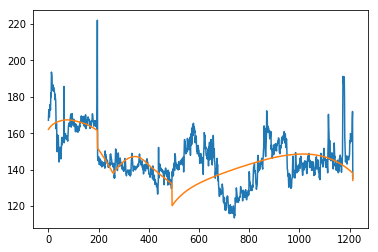


Iter: 4951, running avg elbo: -13310998.8261
Iter: 4952, running avg elbo: -13298670.6178
Iter: 4953, running avg elbo: -13307963.0416
Iter: 4954, running avg elbo: -13293167.8812
Iter: 4955, running avg elbo: -13311973.4924
Iter: 4956, running avg elbo: -13291275.8475
Iter: 4957, running avg elbo: -13271587.7990
Iter: 4958, running avg elbo: -13250617.7810
Iter: 4959, running avg elbo: -13266311.3132
Iter: 4960, running avg elbo: -13245234.4101
Iter: 4961, running avg elbo: -13233955.1660
Iter: 4962, running avg elbo: -13237510.0843
Iter: 4963, running avg elbo: -13216767.3935
Iter: 4964, running avg elbo: -13197515.5095
Iter: 4965, running avg elbo: -13218242.7844
Iter: 4966, running avg elbo: -13199515.5366
Iter: 4967, running avg elbo: -13208058.3212
Iter: 4968, running avg elbo: -13192021.0980
Iter: 4969, running avg elbo: -13182235.1770
Iter: 4970, running avg elbo: -13167545.4553
Iter: 4971, running avg elbo: -13168495.9807
Iter: 4972, running avg elbo: -13161446.6809
Iter: 497

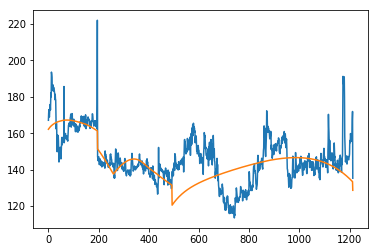


Iter: 5001, running avg elbo: -12857012.6668
Iter: 5002, running avg elbo: -12884662.5501
Iter: 5003, running avg elbo: -12887216.3546
Iter: 5004, running avg elbo: -12869379.1311
Iter: 5005, running avg elbo: -12920384.1598
Iter: 5006, running avg elbo: -12915209.4082
Iter: 5007, running avg elbo: -12896742.5541
Iter: 5008, running avg elbo: -12893996.4485
Iter: 5009, running avg elbo: -12892388.3841
Iter: 5010, running avg elbo: -12894431.9002
Iter: 5011, running avg elbo: -12889970.3212
Iter: 5012, running avg elbo: -12898215.1780
Iter: 5013, running avg elbo: -12904778.9162
Iter: 5014, running avg elbo: -12888546.1671
Iter: 5015, running avg elbo: -12936843.5254
Iter: 5016, running avg elbo: -13006594.5701
Iter: 5017, running avg elbo: -12987754.9444
Iter: 5018, running avg elbo: -13085020.0950
Iter: 5019, running avg elbo: -13105090.9740
Iter: 5020, running avg elbo: -13084907.5143
Iter: 5021, running avg elbo: -13113495.9092
Iter: 5022, running avg elbo: -13131946.4501
Iter: 502

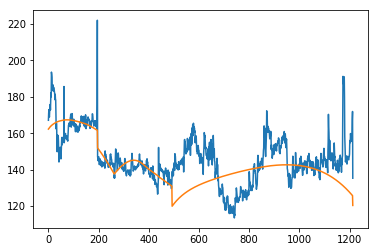


Iter: 5051, running avg elbo: -12975145.5694
Iter: 5052, running avg elbo: -12971443.9437
Iter: 5053, running avg elbo: -12957358.3043
Iter: 5054, running avg elbo: -12958841.3212
Iter: 5055, running avg elbo: -12940427.1080
Iter: 5056, running avg elbo: -12961697.4469
Iter: 5057, running avg elbo: -12975374.8825
Iter: 5058, running avg elbo: -12965223.9136
Iter: 5059, running avg elbo: -12994851.2445
Iter: 5060, running avg elbo: -12983421.3420
Iter: 5061, running avg elbo: -12964737.6686
Iter: 5062, running avg elbo: -12955394.6219
Iter: 5063, running avg elbo: -12949718.4957
Iter: 5064, running avg elbo: -12938137.4608
Iter: 5065, running avg elbo: -12926023.5662
Iter: 5066, running avg elbo: -12920443.7105
Iter: 5067, running avg elbo: -12919805.1234
Iter: 5068, running avg elbo: -12910312.6622
Iter: 5069, running avg elbo: -12891644.3055
Iter: 5070, running avg elbo: -12897154.4025
Iter: 5071, running avg elbo: -12878194.0385
Iter: 5072, running avg elbo: -12867064.3181
Iter: 507

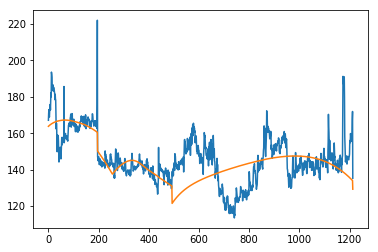


Iter: 5101, running avg elbo: -12598320.1015
Iter: 5102, running avg elbo: -12581974.6505
Iter: 5103, running avg elbo: -12589844.1440
Iter: 5104, running avg elbo: -12578128.5326
Iter: 5105, running avg elbo: -12560763.9272
Iter: 5106, running avg elbo: -12560078.0380
Iter: 5107, running avg elbo: -12559819.9576
Iter: 5108, running avg elbo: -12551028.8580
Iter: 5109, running avg elbo: -12546686.8694
Iter: 5110, running avg elbo: -12532471.9907
Iter: 5111, running avg elbo: -12515624.5708
Iter: 5112, running avg elbo: -12505208.2651
Iter: 5113, running avg elbo: -12496714.5525
Iter: 5114, running avg elbo: -12503767.5369
Iter: 5115, running avg elbo: -12500365.8716
Iter: 5116, running avg elbo: -12484730.3428
Iter: 5117, running avg elbo: -12472095.3794
Iter: 5118, running avg elbo: -12465510.7956
Iter: 5119, running avg elbo: -12449747.4077
Iter: 5120, running avg elbo: -12434079.1536
Iter: 5121, running avg elbo: -12418796.3721
Iter: 5122, running avg elbo: -12407843.8383
Iter: 512

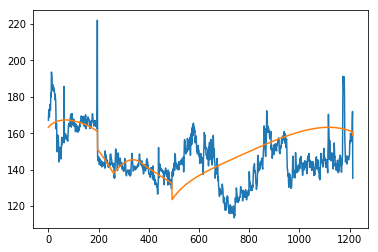


Iter: 5151, running avg elbo: -12322656.3976
Iter: 5152, running avg elbo: -12390399.6536
Iter: 5153, running avg elbo: -12394680.6671
Iter: 5154, running avg elbo: -12384447.8004
Iter: 5155, running avg elbo: -12435106.0824
Iter: 5156, running avg elbo: -12457699.7716
Iter: 5157, running avg elbo: -12448874.2839
Iter: 5158, running avg elbo: -12519865.9610
Iter: 5159, running avg elbo: -12509019.0314
Iter: 5160, running avg elbo: -12497571.4811
Iter: 5161, running avg elbo: -12541163.3663
Iter: 5162, running avg elbo: -12585910.8126
Iter: 5163, running avg elbo: -12568857.7145
Iter: 5164, running avg elbo: -12594180.2673
Iter: 5165, running avg elbo: -12627049.2347
Iter: 5166, running avg elbo: -12618497.8923
Iter: 5167, running avg elbo: -12654636.8234
Iter: 5168, running avg elbo: -12715777.7152
Iter: 5169, running avg elbo: -12697707.1980
Iter: 5170, running avg elbo: -12716702.3160
Iter: 5171, running avg elbo: -12739599.0129
Iter: 5172, running avg elbo: -12726173.7527
Iter: 517

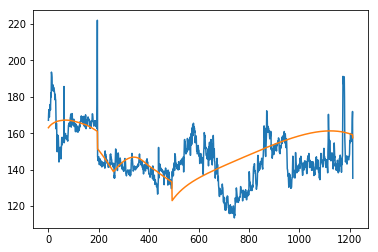


Iter: 5201, running avg elbo: -12833617.1217
Iter: 5202, running avg elbo: -12844835.4505
Iter: 5203, running avg elbo: -12842367.0360
Iter: 5204, running avg elbo: -12847534.8256
Iter: 5205, running avg elbo: -12827347.0274
Iter: 5206, running avg elbo: -12811897.6371
Iter: 5207, running avg elbo: -12795026.3307
Iter: 5208, running avg elbo: -12775298.7474
Iter: 5209, running avg elbo: -12766571.4899
Iter: 5210, running avg elbo: -12750067.9650
Iter: 5211, running avg elbo: -12747114.2554
Iter: 5212, running avg elbo: -12728382.1328
Iter: 5213, running avg elbo: -12716837.3615
Iter: 5214, running avg elbo: -12706831.3579
Iter: 5215, running avg elbo: -12687385.1543
Iter: 5216, running avg elbo: -12677160.4428
Iter: 5217, running avg elbo: -12661684.2083
Iter: 5218, running avg elbo: -12642148.3363
Iter: 5219, running avg elbo: -12626353.6529
Iter: 5220, running avg elbo: -12607867.4564
Iter: 5221, running avg elbo: -12594693.1918
Iter: 5222, running avg elbo: -12577655.8299
Iter: 522

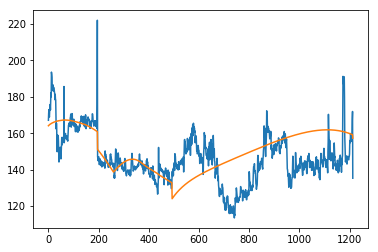


Iter: 5251, running avg elbo: -12354455.3988
Iter: 5252, running avg elbo: -12347014.2448
Iter: 5253, running avg elbo: -12367810.3624
Iter: 5254, running avg elbo: -12353153.8887
Iter: 5255, running avg elbo: -12360286.9598
Iter: 5256, running avg elbo: -12350938.4702
Iter: 5257, running avg elbo: -12335541.0255
Iter: 5258, running avg elbo: -12318992.9853
Iter: 5259, running avg elbo: -12311484.0854
Iter: 5260, running avg elbo: -12295607.3946
Iter: 5261, running avg elbo: -12279443.5306
Iter: 5262, running avg elbo: -12263876.4053
Iter: 5263, running avg elbo: -12252422.9613
Iter: 5264, running avg elbo: -12237967.2917
Iter: 5265, running avg elbo: -12235263.8187
Iter: 5266, running avg elbo: -12221753.6006
Iter: 5267, running avg elbo: -12218757.1945
Iter: 5268, running avg elbo: -12204336.3926
Iter: 5269, running avg elbo: -12192252.2487
Iter: 5270, running avg elbo: -12176717.4362
Iter: 5271, running avg elbo: -12162472.9618
Iter: 5272, running avg elbo: -12159138.8422
Iter: 527

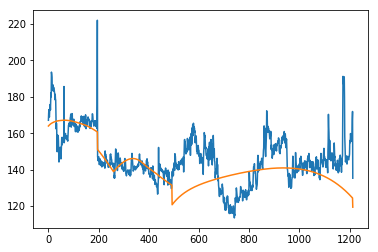


Iter: 5301, running avg elbo: -12222476.3386
Iter: 5302, running avg elbo: -12210599.9852
Iter: 5303, running avg elbo: -12223367.1154
Iter: 5304, running avg elbo: -12232778.7742
Iter: 5305, running avg elbo: -12216571.9865
Iter: 5306, running avg elbo: -12260344.3566
Iter: 5307, running avg elbo: -12247553.6130
Iter: 5308, running avg elbo: -12235338.4569
Iter: 5309, running avg elbo: -12257745.1423
Iter: 5310, running avg elbo: -12241645.7509
Iter: 5311, running avg elbo: -12225131.4534
Iter: 5312, running avg elbo: -12226837.1089
Iter: 5313, running avg elbo: -12216895.9978
Iter: 5314, running avg elbo: -12202397.8778
Iter: 5315, running avg elbo: -12194870.1290
Iter: 5316, running avg elbo: -12191965.2877
Iter: 5317, running avg elbo: -12177151.0549
Iter: 5318, running avg elbo: -12176439.9643
Iter: 5319, running avg elbo: -12161950.4647
Iter: 5320, running avg elbo: -12145981.1800
Iter: 5321, running avg elbo: -12132702.4982
Iter: 5322, running avg elbo: -12146956.6532
Iter: 532

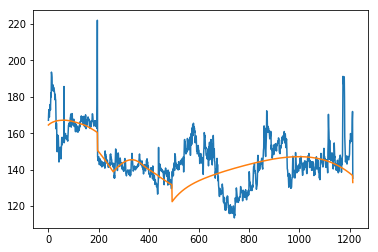


Iter: 5351, running avg elbo: -11951327.0662
Iter: 5352, running avg elbo: -11937182.7755
Iter: 5353, running avg elbo: -11924760.5778
Iter: 5354, running avg elbo: -11921570.9220
Iter: 5355, running avg elbo: -11917056.9328
Iter: 5356, running avg elbo: -11906608.4235
Iter: 5357, running avg elbo: -11922911.0492
Iter: 5358, running avg elbo: -11910100.0987
Iter: 5359, running avg elbo: -11895899.9277
Iter: 5360, running avg elbo: -11882798.5885
Iter: 5361, running avg elbo: -11873624.6826
Iter: 5362, running avg elbo: -11872483.8358
Iter: 5363, running avg elbo: -11864756.4674
Iter: 5364, running avg elbo: -11852168.8427
Iter: 5365, running avg elbo: -11881666.1743
Iter: 5366, running avg elbo: -11913287.4825
Iter: 5367, running avg elbo: -11938904.6377
Iter: 5368, running avg elbo: -11999949.0913
Iter: 5369, running avg elbo: -11991601.4104
Iter: 5370, running avg elbo: -11994944.9563
Iter: 5371, running avg elbo: -12007369.7368
Iter: 5372, running avg elbo: -12008897.4894
Iter: 537

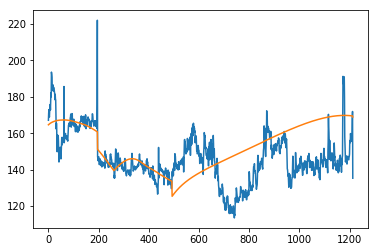


Iter: 5401, running avg elbo: -12303140.6554
Iter: 5402, running avg elbo: -12285035.8589
Iter: 5403, running avg elbo: -12305133.8403
Iter: 5404, running avg elbo: -12302981.5919
Iter: 5405, running avg elbo: -12285681.9860
Iter: 5406, running avg elbo: -12280415.8661
Iter: 5407, running avg elbo: -12290654.3974
Iter: 5408, running avg elbo: -12272265.0635
Iter: 5409, running avg elbo: -12258147.6528
Iter: 5410, running avg elbo: -12284541.7563
Iter: 5411, running avg elbo: -12265870.6987
Iter: 5412, running avg elbo: -12266587.2718
Iter: 5413, running avg elbo: -12264077.8090
Iter: 5414, running avg elbo: -12245776.1610
Iter: 5415, running avg elbo: -12234290.3193
Iter: 5416, running avg elbo: -12261726.4461
Iter: 5417, running avg elbo: -12243590.6417
Iter: 5418, running avg elbo: -12290012.1153
Iter: 5419, running avg elbo: -12296373.7141
Iter: 5420, running avg elbo: -12291016.1370
Iter: 5421, running avg elbo: -12292560.7056
Iter: 5422, running avg elbo: -12276459.2685
Iter: 542

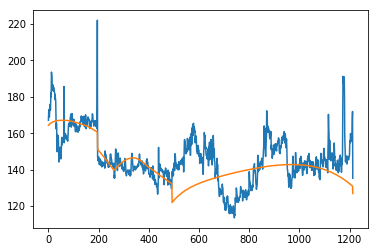


Iter: 5451, running avg elbo: -12210618.6764
Iter: 5452, running avg elbo: -12192756.1096
Iter: 5453, running avg elbo: -12176827.8685
Iter: 5454, running avg elbo: -12160501.6299
Iter: 5455, running avg elbo: -12143877.8736
Iter: 5456, running avg elbo: -12130281.0248
Iter: 5457, running avg elbo: -12113062.9946
Iter: 5458, running avg elbo: -12095180.0746
Iter: 5459, running avg elbo: -12084609.8739
Iter: 5460, running avg elbo: -12080408.0951
Iter: 5461, running avg elbo: -12065031.3442
Iter: 5462, running avg elbo: -12056409.8708
Iter: 5463, running avg elbo: -12060444.4320
Iter: 5464, running avg elbo: -12042715.8077
Iter: 5465, running avg elbo: -12060431.0996
Iter: 5466, running avg elbo: -12059565.2987
Iter: 5467, running avg elbo: -12053106.3757
Iter: 5468, running avg elbo: -12060129.4119
Iter: 5469, running avg elbo: -12047638.5278
Iter: 5470, running avg elbo: -12034119.3625
Iter: 5471, running avg elbo: -12035907.7589
Iter: 5472, running avg elbo: -12023909.7013
Iter: 547

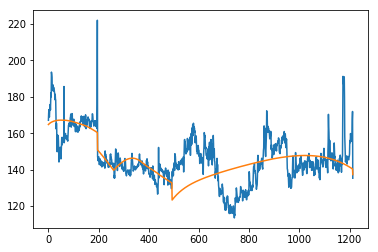


Iter: 5501, running avg elbo: -11768468.8481
Iter: 5502, running avg elbo: -11761936.7097
Iter: 5503, running avg elbo: -11748165.0826
Iter: 5504, running avg elbo: -11744433.8317
Iter: 5505, running avg elbo: -11734174.7734
Iter: 5506, running avg elbo: -11720497.1957
Iter: 5507, running avg elbo: -11705348.8937
Iter: 5508, running avg elbo: -11697312.5148
Iter: 5509, running avg elbo: -11682223.0096
Iter: 5510, running avg elbo: -11673048.9695
Iter: 5511, running avg elbo: -11658375.2999
Iter: 5512, running avg elbo: -11644226.1869
Iter: 5513, running avg elbo: -11630720.4450
Iter: 5514, running avg elbo: -11625830.5605
Iter: 5515, running avg elbo: -11611342.9449
Iter: 5516, running avg elbo: -11601879.4755
Iter: 5517, running avg elbo: -11589259.4207
Iter: 5518, running avg elbo: -11575996.3565
Iter: 5519, running avg elbo: -11561912.6530
Iter: 5520, running avg elbo: -11550007.8864
Iter: 5521, running avg elbo: -11537709.0876
Iter: 5522, running avg elbo: -11526899.4167
Iter: 552

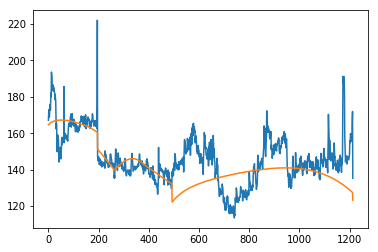


Iter: 5551, running avg elbo: -11534942.4295
Iter: 5552, running avg elbo: -11523196.6652
Iter: 5553, running avg elbo: -11533510.6186
Iter: 5554, running avg elbo: -11522083.5324
Iter: 5555, running avg elbo: -11508532.1271
Iter: 5556, running avg elbo: -11509831.4358
Iter: 5557, running avg elbo: -11508707.3214
Iter: 5558, running avg elbo: -11495959.6882
Iter: 5559, running avg elbo: -11531355.4713
Iter: 5560, running avg elbo: -11521674.7966
Iter: 5561, running avg elbo: -11508010.5787
Iter: 5562, running avg elbo: -11501873.1129
Iter: 5563, running avg elbo: -11488431.1417
Iter: 5564, running avg elbo: -11477591.7303
Iter: 5565, running avg elbo: -11466131.5130
Iter: 5566, running avg elbo: -11461558.6579
Iter: 5567, running avg elbo: -11448885.6213
Iter: 5568, running avg elbo: -11436603.9051
Iter: 5569, running avg elbo: -11431980.7061
Iter: 5570, running avg elbo: -11420222.7290
Iter: 5571, running avg elbo: -11407690.6917
Iter: 5572, running avg elbo: -11396232.9548
Iter: 557

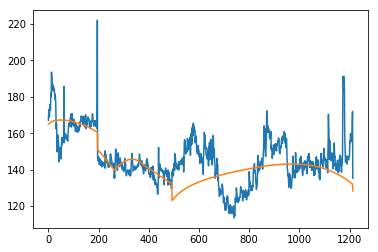


Iter: 5601, running avg elbo: -11282598.5329
Iter: 5602, running avg elbo: -11283832.0976
Iter: 5603, running avg elbo: -11277882.5166
Iter: 5604, running avg elbo: -11267070.1214
Iter: 5605, running avg elbo: -11256629.7702
Iter: 5606, running avg elbo: -11246117.1025
Iter: 5607, running avg elbo: -11234494.7315
Iter: 5608, running avg elbo: -11223098.6042
Iter: 5609, running avg elbo: -11213746.5481
Iter: 5610, running avg elbo: -11202325.1827
Iter: 5611, running avg elbo: -11190620.2308
Iter: 5612, running avg elbo: -11179498.2085
Iter: 5613, running avg elbo: -11173806.7264
Iter: 5614, running avg elbo: -11162203.4792
Iter: 5615, running avg elbo: -11151540.6544
Iter: 5616, running avg elbo: -11140438.2878
Iter: 5617, running avg elbo: -11129477.4350
Iter: 5618, running avg elbo: -11118442.8406
Iter: 5619, running avg elbo: -11107262.2622
Iter: 5620, running avg elbo: -11097563.2996
Iter: 5621, running avg elbo: -11087206.3066
Iter: 5622, running avg elbo: -11095244.3735
Iter: 562

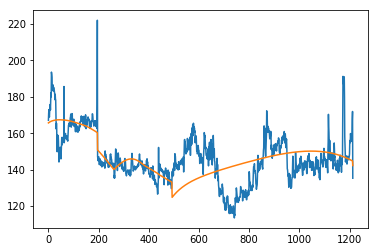


Iter: 5651, running avg elbo: -10941916.4102
Iter: 5652, running avg elbo: -10932299.6061
Iter: 5653, running avg elbo: -10922733.1401
Iter: 5654, running avg elbo: -10914329.6087
Iter: 5655, running avg elbo: -10906512.4526
Iter: 5656, running avg elbo: -10902781.4281
Iter: 5657, running avg elbo: -10894434.9338
Iter: 5658, running avg elbo: -10889867.6144
Iter: 5659, running avg elbo: -10880411.2983
Iter: 5660, running avg elbo: -10881157.3553
Iter: 5661, running avg elbo: -10873511.1618
Iter: 5662, running avg elbo: -10868537.1701
Iter: 5663, running avg elbo: -10859321.3584
Iter: 5664, running avg elbo: -10850517.1649
Iter: 5665, running avg elbo: -10864570.8332
Iter: 5666, running avg elbo: -10855867.9049
Iter: 5667, running avg elbo: -10878912.6558
Iter: 5668, running avg elbo: -10874841.2793
Iter: 5669, running avg elbo: -10868151.1365
Iter: 5670, running avg elbo: -10893651.3751
Iter: 5671, running avg elbo: -10884249.8314
Iter: 5672, running avg elbo: -10889541.8330
Iter: 567

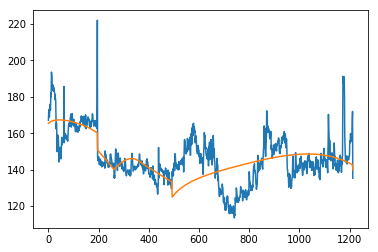


Iter: 5701, running avg elbo: -10713934.8705
Iter: 5702, running avg elbo: -10712307.1118
Iter: 5703, running avg elbo: -10703978.4506
Iter: 5704, running avg elbo: -10709124.8561
Iter: 5705, running avg elbo: -10700996.7876
Iter: 5706, running avg elbo: -10697846.6597
Iter: 5707, running avg elbo: -10690400.9231
Iter: 5708, running avg elbo: -10683609.2539
Iter: 5709, running avg elbo: -10675955.8013
Iter: 5710, running avg elbo: -10670680.2633
Iter: 5711, running avg elbo: -10662964.4607
Iter: 5712, running avg elbo: -10657293.0161
Iter: 5713, running avg elbo: -10655295.9559
Iter: 5714, running avg elbo: -10648209.5164
Iter: 5715, running avg elbo: -10666521.9412
Iter: 5716, running avg elbo: -10660493.3318
Iter: 5717, running avg elbo: -10654737.7185
Iter: 5718, running avg elbo: -10674535.2813
Iter: 5719, running avg elbo: -10666874.7185
Iter: 5720, running avg elbo: -10661422.0313
Iter: 5721, running avg elbo: -10665771.4210
Iter: 5722, running avg elbo: -10660412.8868
Iter: 572

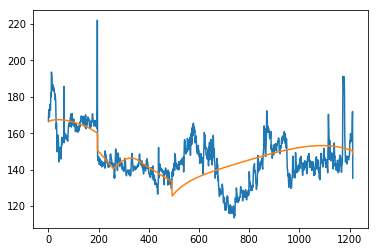


Iter: 5751, running avg elbo: -10640504.5004
Iter: 5752, running avg elbo: -10636354.3154
Iter: 5753, running avg elbo: -10628552.1122
Iter: 5754, running avg elbo: -10620923.9111
Iter: 5755, running avg elbo: -10613013.2720
Iter: 5756, running avg elbo: -10606431.8893
Iter: 5757, running avg elbo: -10598304.3104
Iter: 5758, running avg elbo: -10591019.3273
Iter: 5759, running avg elbo: -10585847.7140
Iter: 5760, running avg elbo: -10581045.1869
Iter: 5761, running avg elbo: -10574056.4250
Iter: 5762, running avg elbo: -10566700.7607
Iter: 5763, running avg elbo: -10561199.0531
Iter: 5764, running avg elbo: -10559599.7926
Iter: 5765, running avg elbo: -10554488.8447
Iter: 5766, running avg elbo: -10556075.0062
Iter: 5767, running avg elbo: -10551594.9262
Iter: 5768, running avg elbo: -10548324.8569
Iter: 5769, running avg elbo: -10546882.8783
Iter: 5770, running avg elbo: -10541371.0396
Iter: 5771, running avg elbo: -10557807.2892
Iter: 5772, running avg elbo: -10552886.6263
Iter: 577

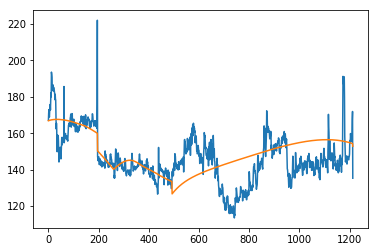


Iter: 5801, running avg elbo: -10471713.2164
Iter: 5802, running avg elbo: -10467108.0742
Iter: 5803, running avg elbo: -10474739.3735
Iter: 5804, running avg elbo: -10467640.4598
Iter: 5805, running avg elbo: -10476307.1652
Iter: 5806, running avg elbo: -10474989.2835
Iter: 5807, running avg elbo: -10476650.9907
Iter: 5808, running avg elbo: -10471727.0508
Iter: 5809, running avg elbo: -10465090.0903
Iter: 5810, running avg elbo: -10471576.4794
Iter: 5811, running avg elbo: -10466209.1446
Iter: 5812, running avg elbo: -10462336.5131
Iter: 5813, running avg elbo: -10455623.6780
Iter: 5814, running avg elbo: -10450841.4212
Iter: 5815, running avg elbo: -10443869.4670
Iter: 5816, running avg elbo: -10438540.0123
Iter: 5817, running avg elbo: -10431481.0922
Iter: 5818, running avg elbo: -10427048.1113
Iter: 5819, running avg elbo: -10421605.8002
Iter: 5820, running avg elbo: -10439106.3822
Iter: 5821, running avg elbo: -10432370.5283
Iter: 5822, running avg elbo: -10432853.7531
Iter: 582

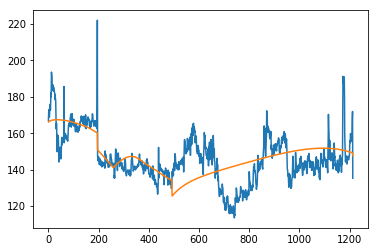


Iter: 5851, running avg elbo: -10492225.0560
Iter: 5852, running avg elbo: -10484737.1154
Iter: 5853, running avg elbo: -10482718.7443
Iter: 5854, running avg elbo: -10475633.6268
Iter: 5855, running avg elbo: -10470208.4505
Iter: 5856, running avg elbo: -10464132.5460
Iter: 5857, running avg elbo: -10456435.4006
Iter: 5858, running avg elbo: -10454576.1766
Iter: 5859, running avg elbo: -10450500.4248
Iter: 5860, running avg elbo: -10447185.1606
Iter: 5861, running avg elbo: -10444556.1090
Iter: 5862, running avg elbo: -10437535.8279
Iter: 5863, running avg elbo: -10434223.1796
Iter: 5864, running avg elbo: -10429610.3978
Iter: 5865, running avg elbo: -10422476.7438
Iter: 5866, running avg elbo: -10415751.5564
Iter: 5867, running avg elbo: -10413917.5008
Iter: 5868, running avg elbo: -10410445.9058
Iter: 5869, running avg elbo: -10405700.1767
Iter: 5870, running avg elbo: -10398037.9350
Iter: 5871, running avg elbo: -10391002.2256
Iter: 5872, running avg elbo: -10386182.7534
Iter: 587

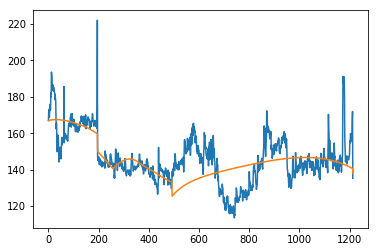


Iter: 5901, running avg elbo: -10308982.4807
Iter: 5902, running avg elbo: -10305330.6759
Iter: 5903, running avg elbo: -10299337.0291
Iter: 5904, running avg elbo: -10292770.3588
Iter: 5905, running avg elbo: -10290881.9952
Iter: 5906, running avg elbo: -10284076.4653
Iter: 5907, running avg elbo: -10281536.4106
Iter: 5908, running avg elbo: -10276835.5165
Iter: 5909, running avg elbo: -10271921.6513
Iter: 5910, running avg elbo: -10268414.7548
Iter: 5911, running avg elbo: -10264340.8773
Iter: 5912, running avg elbo: -10258097.4985
Iter: 5913, running avg elbo: -10265721.5535
Iter: 5914, running avg elbo: -10271871.6580
Iter: 5915, running avg elbo: -10274647.7914
Iter: 5916, running avg elbo: -10285742.5435
Iter: 5917, running avg elbo: -10283818.5881
Iter: 5918, running avg elbo: -10294727.0922
Iter: 5919, running avg elbo: -10294356.7313
Iter: 5920, running avg elbo: -10295804.5839
Iter: 5921, running avg elbo: -10309758.2781
Iter: 5922, running avg elbo: -10324874.1853
Iter: 592

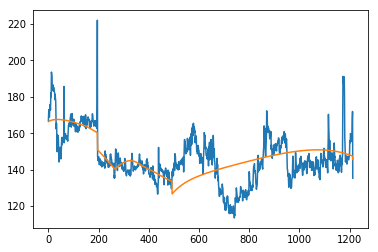


Iter: 5951, running avg elbo: -10436188.6962
Iter: 5952, running avg elbo: -10429148.8792
Iter: 5953, running avg elbo: -10423807.6204
Iter: 5954, running avg elbo: -10416701.5342
Iter: 5955, running avg elbo: -10408046.2689
Iter: 5956, running avg elbo: -10399203.9962
Iter: 5957, running avg elbo: -10398922.2562
Iter: 5958, running avg elbo: -10390183.0736
Iter: 5959, running avg elbo: -10384166.8929
Iter: 5960, running avg elbo: -10376764.0840
Iter: 5961, running avg elbo: -10368299.9831
Iter: 5962, running avg elbo: -10365042.2033
Iter: 5963, running avg elbo: -10358067.4513
Iter: 5964, running avg elbo: -10353351.6968
Iter: 5965, running avg elbo: -10346506.8398
Iter: 5966, running avg elbo: -10338023.9614
Iter: 5967, running avg elbo: -10339280.8618
Iter: 5968, running avg elbo: -10330975.2832
Iter: 5969, running avg elbo: -10325669.8703
Iter: 5970, running avg elbo: -10318080.5016
Iter: 5971, running avg elbo: -10310385.5266
Iter: 5972, running avg elbo: -10305205.3214
Iter: 597

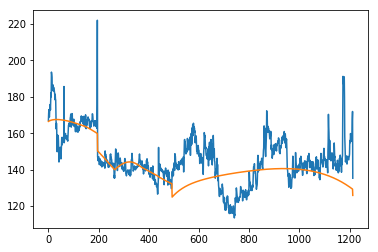


Iter: 6001, running avg elbo: -10491889.9212
Iter: 6002, running avg elbo: -10482888.3420
Iter: 6003, running avg elbo: -10476928.9086
Iter: 6004, running avg elbo: -10500422.6995
Iter: 6005, running avg elbo: -10492517.2925
Iter: 6006, running avg elbo: -10502920.1096
Iter: 6007, running avg elbo: -10555919.7085
Iter: 6008, running avg elbo: -10550257.2514
Iter: 6009, running avg elbo: -10608429.0789
Iter: 6010, running avg elbo: -10608027.0581
Iter: 6011, running avg elbo: -10635584.1475
Iter: 6012, running avg elbo: -10645558.9861
Iter: 6013, running avg elbo: -10637551.5262
Iter: 6014, running avg elbo: -10690625.1509
Iter: 6015, running avg elbo: -10689903.7094
Iter: 6016, running avg elbo: -10685968.4023
Iter: 6017, running avg elbo: -10710623.6683
Iter: 6018, running avg elbo: -10707063.1816
Iter: 6019, running avg elbo: -10715972.3398
Iter: 6020, running avg elbo: -10742323.3964
Iter: 6021, running avg elbo: -10732322.2725
Iter: 6022, running avg elbo: -10757782.1897
Iter: 602

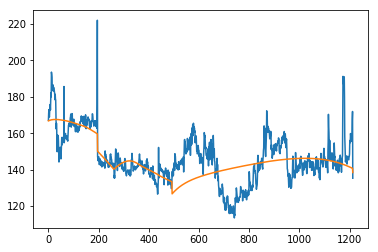


Iter: 6051, running avg elbo: -10662933.3682
Iter: 6052, running avg elbo: -10661514.8045
Iter: 6053, running avg elbo: -10650892.3965
Iter: 6054, running avg elbo: -10647064.6425
Iter: 6055, running avg elbo: -10644129.6061
Iter: 6056, running avg elbo: -10635519.0500
Iter: 6057, running avg elbo: -10631567.8195
Iter: 6058, running avg elbo: -10622085.9313
Iter: 6059, running avg elbo: -10620258.9520
Iter: 6060, running avg elbo: -10612486.7125
Iter: 6061, running avg elbo: -10600149.3954
Iter: 6062, running avg elbo: -10603883.2814
Iter: 6063, running avg elbo: -10595992.6286
Iter: 6064, running avg elbo: -10598765.1323
Iter: 6065, running avg elbo: -10594622.8510
Iter: 6066, running avg elbo: -10582386.9425
Iter: 6067, running avg elbo: -10580487.9531
Iter: 6068, running avg elbo: -10580618.3335
Iter: 6069, running avg elbo: -10574770.9002
Iter: 6070, running avg elbo: -10574636.5812
Iter: 6071, running avg elbo: -10563801.3254
Iter: 6072, running avg elbo: -10559244.6021
Iter: 607

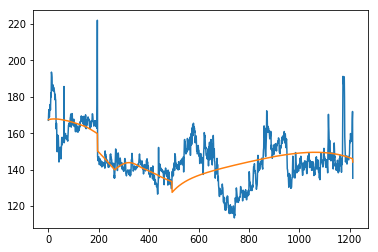


Iter: 6101, running avg elbo: -10463497.5254
Iter: 6102, running avg elbo: -10465279.4201
Iter: 6103, running avg elbo: -10464974.6259
Iter: 6104, running avg elbo: -10457912.7197
Iter: 6105, running avg elbo: -10451155.5825
Iter: 6106, running avg elbo: -10444084.5067
Iter: 6107, running avg elbo: -10433850.4616
Iter: 6108, running avg elbo: -10424690.4370
Iter: 6109, running avg elbo: -10414691.8326
Iter: 6110, running avg elbo: -10405632.5443
Iter: 6111, running avg elbo: -10396163.7788
Iter: 6112, running avg elbo: -10385772.1910
Iter: 6113, running avg elbo: -10375472.6991
Iter: 6114, running avg elbo: -10364998.4221
Iter: 6115, running avg elbo: -10354402.1379
Iter: 6116, running avg elbo: -10348470.6465
Iter: 6117, running avg elbo: -10338514.8201
Iter: 6118, running avg elbo: -10336835.8219
Iter: 6119, running avg elbo: -10327259.4337
Iter: 6120, running avg elbo: -10334255.6093
Iter: 6121, running avg elbo: -10325633.3132
Iter: 6122, running avg elbo: -10318661.2701
Iter: 612

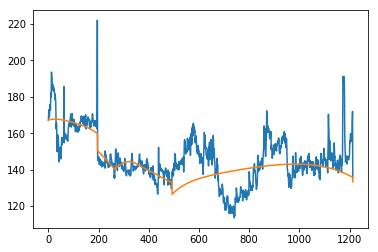


Iter: 6151, running avg elbo: -10416169.1361
Iter: 6152, running avg elbo: -10429584.1647
Iter: 6153, running avg elbo: -10426466.4031
Iter: 6154, running avg elbo: -10423445.0490
Iter: 6155, running avg elbo: -10439376.0585
Iter: 6156, running avg elbo: -10428674.9980
Iter: 6157, running avg elbo: -10432304.2780
Iter: 6158, running avg elbo: -10422051.9452
Iter: 6159, running avg elbo: -10410942.0857
Iter: 6160, running avg elbo: -10412340.6549
Iter: 6161, running avg elbo: -10402548.6183
Iter: 6162, running avg elbo: -10395808.5122
Iter: 6163, running avg elbo: -10398779.3970
Iter: 6164, running avg elbo: -10389668.7331
Iter: 6165, running avg elbo: -10392473.7357
Iter: 6166, running avg elbo: -10381267.7184
Iter: 6167, running avg elbo: -10372644.0112
Iter: 6168, running avg elbo: -10364711.9411
Iter: 6169, running avg elbo: -10353669.2217
Iter: 6170, running avg elbo: -10350288.8295
Iter: 6171, running avg elbo: -10339451.2512
Iter: 6172, running avg elbo: -10329494.5986
Iter: 617

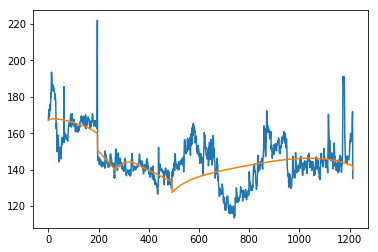


Iter: 6201, running avg elbo: -10122707.6989
Iter: 6202, running avg elbo: -10113816.0219
Iter: 6203, running avg elbo: -10110002.3517
Iter: 6204, running avg elbo: -10101082.1981
Iter: 6205, running avg elbo: -10097124.0962
Iter: 6206, running avg elbo: -10095223.4352
Iter: 6207, running avg elbo: -10090587.7209
Iter: 6208, running avg elbo: -10086997.8736
Iter: 6209, running avg elbo: -10078341.9749
Iter: 6210, running avg elbo: -10074738.6952
Iter: 6211, running avg elbo: -10065630.9482
Iter: 6212, running avg elbo: -10056889.4787
Iter: 6213, running avg elbo: -10048577.1139
Iter: 6214, running avg elbo: -10042112.4628
Iter: 6215, running avg elbo: -10033729.5282
Iter: 6216, running avg elbo: -10035330.2629
Iter: 6217, running avg elbo: -10027131.7603
Iter: 6218, running avg elbo: -10018905.3627
Iter: 6219, running avg elbo: -10012120.1790
Iter: 6220, running avg elbo: -10003942.3372
Iter: 6221, running avg elbo: -10004848.7439
Iter: 6222, running avg elbo: -9996359.0564
Iter: 6223

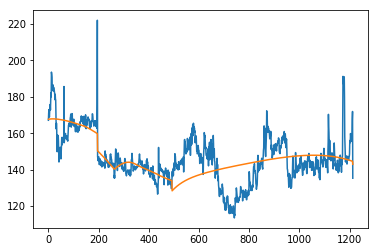


Iter: 6251, running avg elbo: -9874341.4322
Iter: 6252, running avg elbo: -9867756.5279
Iter: 6253, running avg elbo: -9862146.4926
Iter: 6254, running avg elbo: -9855759.8677
Iter: 6255, running avg elbo: -9849968.5390
Iter: 6256, running avg elbo: -9843256.2536
Iter: 6257, running avg elbo: -9836158.1211
Iter: 6258, running avg elbo: -9829661.2899
Iter: 6259, running avg elbo: -9824225.4670
Iter: 6260, running avg elbo: -9819805.9423
Iter: 6261, running avg elbo: -9820550.7729
Iter: 6262, running avg elbo: -9821047.3952
Iter: 6263, running avg elbo: -9818446.0012
Iter: 6264, running avg elbo: -9814823.9612
Iter: 6265, running avg elbo: -9813679.2016
Iter: 6266, running avg elbo: -9809269.3896
Iter: 6267, running avg elbo: -9804134.3457
Iter: 6268, running avg elbo: -9797980.7022
Iter: 6269, running avg elbo: -9795407.8352
Iter: 6270, running avg elbo: -9788491.6568
Iter: 6271, running avg elbo: -9781720.5803
Iter: 6272, running avg elbo: -9775076.5945
Iter: 6273, running avg elbo: -

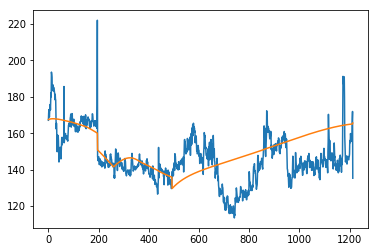


Iter: 6301, running avg elbo: -9873616.0498
Iter: 6302, running avg elbo: -9888260.6193
Iter: 6303, running avg elbo: -9907147.6731
Iter: 6304, running avg elbo: -9902734.7664
Iter: 6305, running avg elbo: -9916535.4287
Iter: 6306, running avg elbo: -9912579.1244
Iter: 6307, running avg elbo: -9926205.9532
Iter: 6308, running avg elbo: -9927297.4937
Iter: 6309, running avg elbo: -9932763.5987
Iter: 6310, running avg elbo: -9933511.0227
Iter: 6311, running avg elbo: -9932036.7525
Iter: 6312, running avg elbo: -9936673.4550
Iter: 6313, running avg elbo: -9931956.4504
Iter: 6314, running avg elbo: -9927979.9359
Iter: 6315, running avg elbo: -9925154.7766
Iter: 6316, running avg elbo: -9923457.6588
Iter: 6317, running avg elbo: -9924228.6822
Iter: 6318, running avg elbo: -9916277.7054
Iter: 6319, running avg elbo: -9913097.7683
Iter: 6320, running avg elbo: -9910681.1107
Iter: 6321, running avg elbo: -9909811.2896
Iter: 6322, running avg elbo: -9902136.1067
Iter: 6323, running avg elbo: -

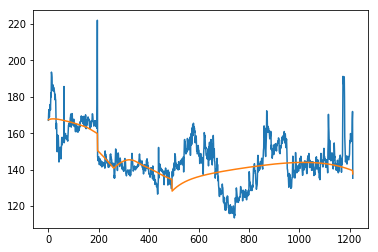


Iter: 6351, running avg elbo: -9745609.0629
Iter: 6352, running avg elbo: -9744269.5323
Iter: 6353, running avg elbo: -9741436.0069
Iter: 6354, running avg elbo: -9733866.0369
Iter: 6355, running avg elbo: -9741948.6665
Iter: 6356, running avg elbo: -9735790.8098
Iter: 6357, running avg elbo: -9738074.1317
Iter: 6358, running avg elbo: -9748860.1504
Iter: 6359, running avg elbo: -9743842.0989
Iter: 6360, running avg elbo: -9786521.5279
Iter: 6361, running avg elbo: -9780008.8026
Iter: 6362, running avg elbo: -9791553.4946
Iter: 6363, running avg elbo: -9786158.5497
Iter: 6364, running avg elbo: -9778452.6742
Iter: 6365, running avg elbo: -9785557.4374
Iter: 6366, running avg elbo: -9781049.6931
Iter: 6367, running avg elbo: -9779467.0361
Iter: 6368, running avg elbo: -9783103.2258
Iter: 6369, running avg elbo: -9775514.2835
Iter: 6370, running avg elbo: -9789760.4907
Iter: 6371, running avg elbo: -9782402.1258
Iter: 6372, running avg elbo: -9782567.2045
Iter: 6373, running avg elbo: -

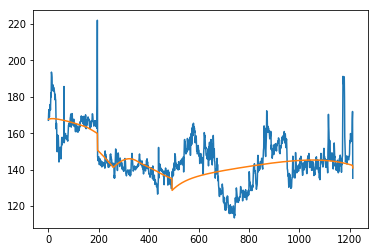


Iter: 6401, running avg elbo: -9664912.6142
Iter: 6402, running avg elbo: -9659177.0781
Iter: 6403, running avg elbo: -9652666.7173
Iter: 6404, running avg elbo: -9647834.9301
Iter: 6405, running avg elbo: -9641397.4808
Iter: 6406, running avg elbo: -9634878.4260
Iter: 6407, running avg elbo: -9628385.5418
Iter: 6408, running avg elbo: -9623135.5163
Iter: 6409, running avg elbo: -9616584.7012
Iter: 6410, running avg elbo: -9610347.2442
Iter: 6411, running avg elbo: -9603715.5117
Iter: 6412, running avg elbo: -9597527.2466
Iter: 6413, running avg elbo: -9590756.5141
Iter: 6414, running avg elbo: -9584268.6590
Iter: 6415, running avg elbo: -9578753.2624
Iter: 6416, running avg elbo: -9572822.0798
Iter: 6417, running avg elbo: -9566414.7890
Iter: 6418, running avg elbo: -9560341.0611
Iter: 6419, running avg elbo: -9554465.0205
Iter: 6420, running avg elbo: -9548028.2603
Iter: 6421, running avg elbo: -9541995.2677
Iter: 6422, running avg elbo: -9537945.6350
Iter: 6423, running avg elbo: -

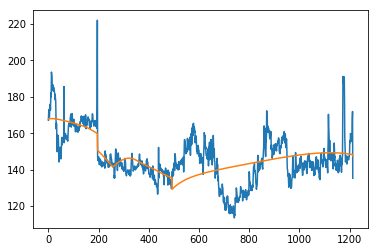


Iter: 6451, running avg elbo: -9517003.3009
Iter: 6452, running avg elbo: -9518128.9379
Iter: 6453, running avg elbo: -9511994.1485
Iter: 6454, running avg elbo: -9507511.5670
Iter: 6455, running avg elbo: -9504132.9814
Iter: 6456, running avg elbo: -9497837.2016
Iter: 6457, running avg elbo: -9496833.2295
Iter: 6458, running avg elbo: -9491950.7572
Iter: 6459, running avg elbo: -9490276.2197
Iter: 6460, running avg elbo: -9484740.9575
Iter: 6461, running avg elbo: -9479285.8179
Iter: 6462, running avg elbo: -9481909.6097
Iter: 6463, running avg elbo: -9476195.1636
Iter: 6464, running avg elbo: -9472090.5520
Iter: 6465, running avg elbo: -9466216.0065
Iter: 6466, running avg elbo: -9460687.0764
Iter: 6467, running avg elbo: -9458727.9656
Iter: 6468, running avg elbo: -9456720.1860
Iter: 6469, running avg elbo: -9451332.7641
Iter: 6470, running avg elbo: -9446480.0965
Iter: 6471, running avg elbo: -9443992.8355
Iter: 6472, running avg elbo: -9439958.4572
Iter: 6473, running avg elbo: -

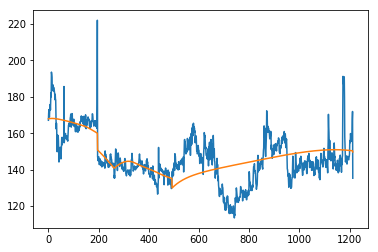


Iter: 6501, running avg elbo: -9331445.7051
Iter: 6502, running avg elbo: -9330423.7881
Iter: 6503, running avg elbo: -9326292.7502
Iter: 6504, running avg elbo: -9330540.8127
Iter: 6505, running avg elbo: -9325609.0445
Iter: 6506, running avg elbo: -9325657.7941
Iter: 6507, running avg elbo: -9324102.0062
Iter: 6508, running avg elbo: -9319933.0361
Iter: 6509, running avg elbo: -9328370.8957
Iter: 6510, running avg elbo: -9323852.8868
Iter: 6511, running avg elbo: -9323325.8179
Iter: 6512, running avg elbo: -9318421.9597
Iter: 6513, running avg elbo: -9313963.2301
Iter: 6514, running avg elbo: -9311330.2678
Iter: 6515, running avg elbo: -9307484.3552
Iter: 6516, running avg elbo: -9303067.8116
Iter: 6517, running avg elbo: -9301951.7735
Iter: 6518, running avg elbo: -9297474.4658
Iter: 6519, running avg elbo: -9297304.7911
Iter: 6520, running avg elbo: -9293689.7732
Iter: 6521, running avg elbo: -9289624.3755
Iter: 6522, running avg elbo: -9287037.7017
Iter: 6523, running avg elbo: -

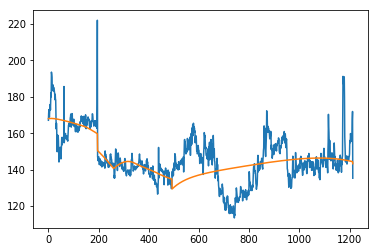


Iter: 6551, running avg elbo: -9380082.2756
Iter: 6552, running avg elbo: -9375475.7928
Iter: 6553, running avg elbo: -9379930.6849
Iter: 6554, running avg elbo: -9375344.8581
Iter: 6555, running avg elbo: -9369827.1995
Iter: 6556, running avg elbo: -9372932.1575
Iter: 6557, running avg elbo: -9367637.8059
Iter: 6558, running avg elbo: -9367549.2078
Iter: 6559, running avg elbo: -9364871.9558
Iter: 6560, running avg elbo: -9364226.4562
Iter: 6561, running avg elbo: -9361735.2316
Iter: 6562, running avg elbo: -9357297.5893
Iter: 6563, running avg elbo: -9352323.0834
Iter: 6564, running avg elbo: -9346734.8726
Iter: 6565, running avg elbo: -9341693.5839
Iter: 6566, running avg elbo: -9336151.1880
Iter: 6567, running avg elbo: -9330812.8562
Iter: 6568, running avg elbo: -9326342.8276
Iter: 6569, running avg elbo: -9320747.1793
Iter: 6570, running avg elbo: -9318551.4675
Iter: 6571, running avg elbo: -9313098.9728
Iter: 6572, running avg elbo: -9308113.2731
Iter: 6573, running avg elbo: -

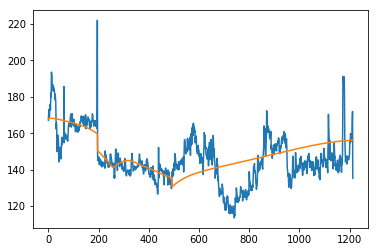


Iter: 6601, running avg elbo: -9228558.7272
Iter: 6602, running avg elbo: -9225980.3999
Iter: 6603, running avg elbo: -9221316.8659
Iter: 6604, running avg elbo: -9218771.2072
Iter: 6605, running avg elbo: -9216351.3752
Iter: 6606, running avg elbo: -9214142.3414
Iter: 6607, running avg elbo: -9210502.0680
Iter: 6608, running avg elbo: -9206858.4873
Iter: 6609, running avg elbo: -9202508.0524
Iter: 6610, running avg elbo: -9198564.2519
Iter: 6611, running avg elbo: -9197873.0694
Iter: 6612, running avg elbo: -9193714.3887
Iter: 6613, running avg elbo: -9188938.4748
Iter: 6614, running avg elbo: -9185804.1501
Iter: 6615, running avg elbo: -9181077.6986
Iter: 6616, running avg elbo: -9177532.4116
Iter: 6617, running avg elbo: -9173208.5675
Iter: 6618, running avg elbo: -9168633.8218
Iter: 6619, running avg elbo: -9164371.0236
Iter: 6620, running avg elbo: -9159625.2433
Iter: 6621, running avg elbo: -9155034.7709
Iter: 6622, running avg elbo: -9151186.1032
Iter: 6623, running avg elbo: -

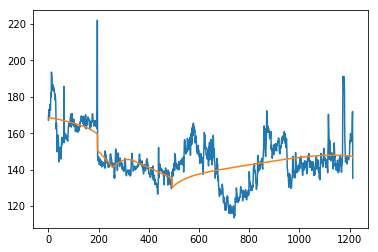


Iter: 6651, running avg elbo: -9071803.2417
Iter: 6652, running avg elbo: -9068300.2993
Iter: 6653, running avg elbo: -9064687.3863
Iter: 6654, running avg elbo: -9061040.6124
Iter: 6655, running avg elbo: -9058944.7163
Iter: 6656, running avg elbo: -9071011.4692
Iter: 6657, running avg elbo: -9078110.9645
Iter: 6658, running avg elbo: -9078503.8648
Iter: 6659, running avg elbo: -9077485.7062
Iter: 6660, running avg elbo: -9085814.4991
Iter: 6661, running avg elbo: -9081937.0041
Iter: 6662, running avg elbo: -9101535.1441
Iter: 6663, running avg elbo: -9097652.8226
Iter: 6664, running avg elbo: -9114166.6844
Iter: 6665, running avg elbo: -9113132.8176
Iter: 6666, running avg elbo: -9115148.5094
Iter: 6667, running avg elbo: -9124910.3543
Iter: 6668, running avg elbo: -9122462.2308
Iter: 6669, running avg elbo: -9129569.7084
Iter: 6670, running avg elbo: -9125090.4714
Iter: 6671, running avg elbo: -9122141.5566
Iter: 6672, running avg elbo: -9125185.5411
Iter: 6673, running avg elbo: -

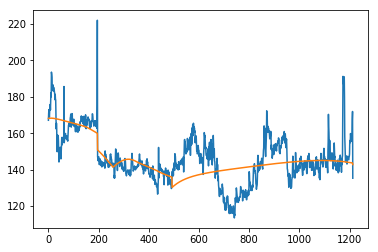


Iter: 6701, running avg elbo: -9060720.4276
Iter: 6702, running avg elbo: -9056957.6233
Iter: 6703, running avg elbo: -9060380.5371
Iter: 6704, running avg elbo: -9056521.4217
Iter: 6705, running avg elbo: -9058886.5375
Iter: 6706, running avg elbo: -9057768.7021
Iter: 6707, running avg elbo: -9070155.7951
Iter: 6708, running avg elbo: -9067706.5271
Iter: 6709, running avg elbo: -9071979.5219
Iter: 6710, running avg elbo: -9068883.2666
Iter: 6711, running avg elbo: -9066904.7140
Iter: 6712, running avg elbo: -9065520.2568
Iter: 6713, running avg elbo: -9062639.4243
Iter: 6714, running avg elbo: -9067105.6200
Iter: 6715, running avg elbo: -9064320.5438
Iter: 6716, running avg elbo: -9077397.7684
Iter: 6717, running avg elbo: -9073569.0207
Iter: 6718, running avg elbo: -9086351.1205
Iter: 6719, running avg elbo: -9081643.0193
Iter: 6720, running avg elbo: -9083747.2291
Iter: 6721, running avg elbo: -9080596.9068
Iter: 6722, running avg elbo: -9076382.3977
Iter: 6723, running avg elbo: -

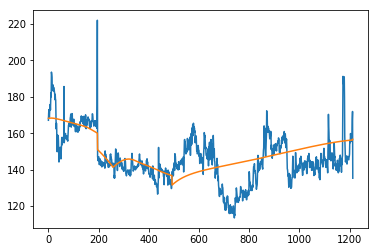


Iter: 6751, running avg elbo: -9006903.6800
Iter: 6752, running avg elbo: -9005758.8232
Iter: 6753, running avg elbo: -9013083.1450
Iter: 6754, running avg elbo: -9008898.3036
Iter: 6755, running avg elbo: -9019476.4805
Iter: 6756, running avg elbo: -9019419.9957
Iter: 6757, running avg elbo: -9029380.6258
Iter: 6758, running avg elbo: -9030537.7895
Iter: 6759, running avg elbo: -9029723.8316
Iter: 6760, running avg elbo: -9034125.2333
Iter: 6761, running avg elbo: -9029694.6710
Iter: 6762, running avg elbo: -9031315.8842
Iter: 6763, running avg elbo: -9029545.2654
Iter: 6764, running avg elbo: -9027485.1727
Iter: 6765, running avg elbo: -9031736.0910
Iter: 6766, running avg elbo: -9027206.6401
Iter: 6767, running avg elbo: -9047638.9837
Iter: 6768, running avg elbo: -9043299.0739
Iter: 6769, running avg elbo: -9050099.5431
Iter: 6770, running avg elbo: -9047538.3177
Iter: 6771, running avg elbo: -9047082.4645
Iter: 6772, running avg elbo: -9050809.6499
Iter: 6773, running avg elbo: -

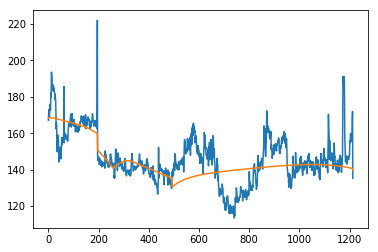


Iter: 6801, running avg elbo: -8948423.6408
Iter: 6802, running avg elbo: -8945291.8044
Iter: 6803, running avg elbo: -8941567.5563
Iter: 6804, running avg elbo: -8938103.4208
Iter: 6805, running avg elbo: -8934645.9265
Iter: 6806, running avg elbo: -8934189.2773
Iter: 6807, running avg elbo: -8930154.6745
Iter: 6808, running avg elbo: -8927158.5578
Iter: 6809, running avg elbo: -8926925.5822
Iter: 6810, running avg elbo: -8928700.6464
Iter: 6811, running avg elbo: -8925720.5299
Iter: 6812, running avg elbo: -8921715.1746
Iter: 6813, running avg elbo: -8924080.9529
Iter: 6814, running avg elbo: -8920699.3733
Iter: 6815, running avg elbo: -8932116.3396
Iter: 6816, running avg elbo: -8928141.7262
Iter: 6817, running avg elbo: -8934173.9389
Iter: 6818, running avg elbo: -8930322.6795
Iter: 6819, running avg elbo: -8929104.2927
Iter: 6820, running avg elbo: -8930132.4498
Iter: 6821, running avg elbo: -8931175.8753
Iter: 6822, running avg elbo: -8928510.1166
Iter: 6823, running avg elbo: -

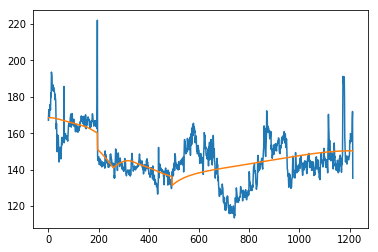


Iter: 6851, running avg elbo: -8909068.6525
Iter: 6852, running avg elbo: -8910851.2559
Iter: 6853, running avg elbo: -8908369.0934
Iter: 6854, running avg elbo: -8910479.9924
Iter: 6855, running avg elbo: -8914505.8525
Iter: 6856, running avg elbo: -8917937.3340
Iter: 6857, running avg elbo: -8920655.6507
Iter: 6858, running avg elbo: -8919094.5641
Iter: 6859, running avg elbo: -8921395.8085
Iter: 6860, running avg elbo: -8917589.9104
Iter: 6861, running avg elbo: -8915516.0913
Iter: 6862, running avg elbo: -8914635.8304
Iter: 6863, running avg elbo: -8911555.7221
Iter: 6864, running avg elbo: -8918512.2749
Iter: 6865, running avg elbo: -8914393.7021
Iter: 6866, running avg elbo: -8923771.6651
Iter: 6867, running avg elbo: -8920650.6585
Iter: 6868, running avg elbo: -8925425.7719
Iter: 6869, running avg elbo: -8925830.7342
Iter: 6870, running avg elbo: -8926014.5068
Iter: 6871, running avg elbo: -8941946.6617
Iter: 6872, running avg elbo: -8949776.8751
Iter: 6873, running avg elbo: -

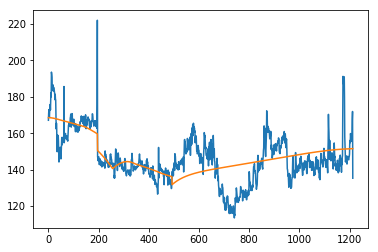


Iter: 6901, running avg elbo: -9011596.0807
Iter: 6902, running avg elbo: -9006109.6799
Iter: 6903, running avg elbo: -9017591.3931
Iter: 6904, running avg elbo: -9015390.4191
Iter: 6905, running avg elbo: -9022953.4249
Iter: 6906, running avg elbo: -9024876.2707
Iter: 6907, running avg elbo: -9023136.3880
Iter: 6908, running avg elbo: -9031387.4841
Iter: 6909, running avg elbo: -9026033.2093
Iter: 6910, running avg elbo: -9035995.2672
Iter: 6911, running avg elbo: -9031771.8945
Iter: 6912, running avg elbo: -9037022.1756
Iter: 6913, running avg elbo: -9039053.0338
Iter: 6914, running avg elbo: -9037055.1235
Iter: 6915, running avg elbo: -9053831.7722
Iter: 6916, running avg elbo: -9047984.9645
Iter: 6917, running avg elbo: -9067507.7349
Iter: 6918, running avg elbo: -9062962.4875
Iter: 6919, running avg elbo: -9071748.7126
Iter: 6920, running avg elbo: -9072708.5855
Iter: 6921, running avg elbo: -9069501.9297
Iter: 6922, running avg elbo: -9080090.0104
Iter: 6923, running avg elbo: -

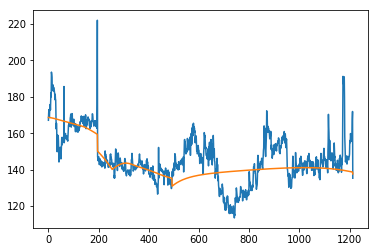


Iter: 6951, running avg elbo: -9012017.3758
Iter: 6952, running avg elbo: -9009217.8221
Iter: 6953, running avg elbo: -9011880.2438
Iter: 6954, running avg elbo: -9009366.1614
Iter: 6955, running avg elbo: -9013923.0698
Iter: 6956, running avg elbo: -9008813.1391
Iter: 6957, running avg elbo: -9010849.8777
Iter: 6958, running avg elbo: -9005466.5389
Iter: 6959, running avg elbo: -9009883.5735
Iter: 6960, running avg elbo: -9004099.9978
Iter: 6961, running avg elbo: -9003567.8978
Iter: 6962, running avg elbo: -8999079.2888
Iter: 6963, running avg elbo: -8997478.6460
Iter: 6964, running avg elbo: -8998663.1295
Iter: 6965, running avg elbo: -8996720.6282
Iter: 6966, running avg elbo: -9001607.0519
Iter: 6967, running avg elbo: -8995978.3914
Iter: 6968, running avg elbo: -9016718.6475
Iter: 6969, running avg elbo: -9014411.8210
Iter: 6970, running avg elbo: -9016767.3328
Iter: 6971, running avg elbo: -9011099.2495
Iter: 6972, running avg elbo: -9032951.4570
Iter: 6973, running avg elbo: -

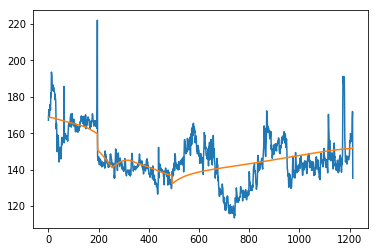


Iter: 7001, running avg elbo: -8947275.4853
Iter: 7002, running avg elbo: -8943418.5805
Iter: 7003, running avg elbo: -8949077.1647
Iter: 7004, running avg elbo: -8944086.2730
Iter: 7005, running avg elbo: -8956845.2203
Iter: 7006, running avg elbo: -8951723.0481
Iter: 7007, running avg elbo: -8954897.2776
Iter: 7008, running avg elbo: -8949298.8748
Iter: 7009, running avg elbo: -8946309.5661
Iter: 7010, running avg elbo: -8946266.1004
Iter: 7011, running avg elbo: -8942533.6894
Iter: 7012, running avg elbo: -8942082.6225
Iter: 7013, running avg elbo: -8937250.9163
Iter: 7014, running avg elbo: -8934017.5771
Iter: 7015, running avg elbo: -8928360.5014
Iter: 7016, running avg elbo: -8927982.5263
Iter: 7017, running avg elbo: -8926422.1911
Iter: 7018, running avg elbo: -8933482.2792
Iter: 7019, running avg elbo: -8934727.9564
Iter: 7020, running avg elbo: -8941168.6068
Iter: 7021, running avg elbo: -8945174.6307
Iter: 7022, running avg elbo: -8945970.3244
Iter: 7023, running avg elbo: -

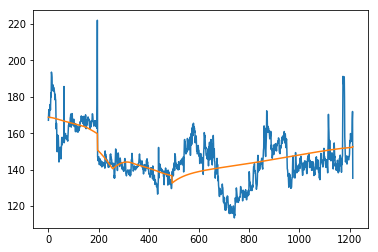


Iter: 7051, running avg elbo: -8854831.7123
Iter: 7052, running avg elbo: -8849907.1202
Iter: 7053, running avg elbo: -8844609.9640
Iter: 7054, running avg elbo: -8840164.6443
Iter: 7055, running avg elbo: -8838465.1379
Iter: 7056, running avg elbo: -8834876.5665
Iter: 7057, running avg elbo: -8830176.5858
Iter: 7058, running avg elbo: -8825144.6950
Iter: 7059, running avg elbo: -8822891.7280
Iter: 7060, running avg elbo: -8820650.9008
Iter: 7061, running avg elbo: -8817614.4818
Iter: 7062, running avg elbo: -8814495.8069
Iter: 7063, running avg elbo: -8814583.6789
Iter: 7064, running avg elbo: -8811745.4021
Iter: 7065, running avg elbo: -8812548.2481
Iter: 7066, running avg elbo: -8807585.8506
Iter: 7067, running avg elbo: -8815903.7521
Iter: 7068, running avg elbo: -8812045.5745
Iter: 7069, running avg elbo: -8817252.8388
Iter: 7070, running avg elbo: -8814063.3004
Iter: 7071, running avg elbo: -8813422.4874
Iter: 7072, running avg elbo: -8808838.4675
Iter: 7073, running avg elbo: -

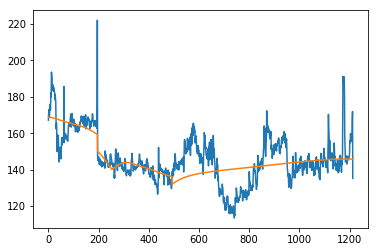


Iter: 7101, running avg elbo: -8785679.7418
Iter: 7102, running avg elbo: -8783597.2844
Iter: 7103, running avg elbo: -8781058.3815
Iter: 7104, running avg elbo: -8777612.6277
Iter: 7105, running avg elbo: -8776294.3514
Iter: 7106, running avg elbo: -8773861.0479
Iter: 7107, running avg elbo: -8771792.5874
Iter: 7108, running avg elbo: -8769392.6016
Iter: 7109, running avg elbo: -8765094.3105
Iter: 7110, running avg elbo: -8760823.1874
Iter: 7111, running avg elbo: -8756858.3206
Iter: 7112, running avg elbo: -8754460.3574
Iter: 7113, running avg elbo: -8751689.8138
Iter: 7114, running avg elbo: -8749057.7557
Iter: 7115, running avg elbo: -8748465.9581
Iter: 7116, running avg elbo: -8744766.7085
Iter: 7117, running avg elbo: -8740573.1164
Iter: 7118, running avg elbo: -8736797.0553
Iter: 7119, running avg elbo: -8732525.7347
Iter: 7120, running avg elbo: -8732316.8774
Iter: 7121, running avg elbo: -8732157.5386
Iter: 7122, running avg elbo: -8729424.1232
Iter: 7123, running avg elbo: -

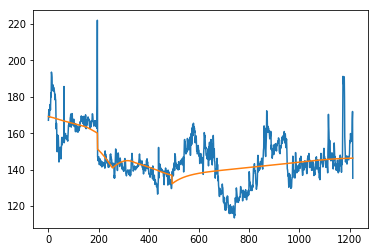


Iter: 7151, running avg elbo: -8691059.5043
Iter: 7152, running avg elbo: -8689790.7293
Iter: 7153, running avg elbo: -8686058.2870
Iter: 7154, running avg elbo: -8690140.1741
Iter: 7155, running avg elbo: -8687224.0224
Iter: 7156, running avg elbo: -8691057.3121
Iter: 7157, running avg elbo: -8688008.9940
Iter: 7158, running avg elbo: -8687261.0241
Iter: 7159, running avg elbo: -8683226.2338
Iter: 7160, running avg elbo: -8680969.7715
Iter: 7161, running avg elbo: -8678013.7938
Iter: 7162, running avg elbo: -8674045.9608
Iter: 7163, running avg elbo: -8676668.3512
Iter: 7164, running avg elbo: -8673172.9527
Iter: 7165, running avg elbo: -8671235.1532
Iter: 7166, running avg elbo: -8667250.6317
Iter: 7167, running avg elbo: -8666225.4054
Iter: 7168, running avg elbo: -8667108.1713
Iter: 7169, running avg elbo: -8672720.1496
Iter: 7170, running avg elbo: -8673478.0281
Iter: 7171, running avg elbo: -8681136.5878
Iter: 7172, running avg elbo: -8679319.7719
Iter: 7173, running avg elbo: -

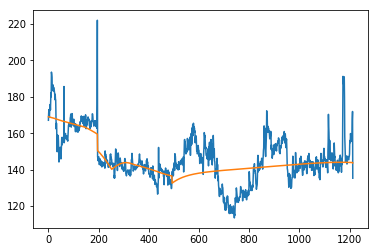


Iter: 7201, running avg elbo: -8616639.7098
Iter: 7202, running avg elbo: -8615127.1427
Iter: 7203, running avg elbo: -8611358.2563
Iter: 7204, running avg elbo: -8607677.4237
Iter: 7205, running avg elbo: -8603740.7695
Iter: 7206, running avg elbo: -8600888.2768
Iter: 7207, running avg elbo: -8597218.8640
Iter: 7208, running avg elbo: -8594421.2854
Iter: 7209, running avg elbo: -8591083.2925
Iter: 7210, running avg elbo: -8587583.9096
Iter: 7211, running avg elbo: -8583943.9555
Iter: 7212, running avg elbo: -8580059.0060
Iter: 7213, running avg elbo: -8581225.8159
Iter: 7214, running avg elbo: -8588031.0877
Iter: 7215, running avg elbo: -8584417.9419
Iter: 7216, running avg elbo: -8588645.5224
Iter: 7217, running avg elbo: -8585346.2672
Iter: 7218, running avg elbo: -8591454.0345
Iter: 7219, running avg elbo: -8587846.0942
Iter: 7220, running avg elbo: -8593439.5333
Iter: 7221, running avg elbo: -8592452.6679
Iter: 7222, running avg elbo: -8609294.2412
Iter: 7223, running avg elbo: -

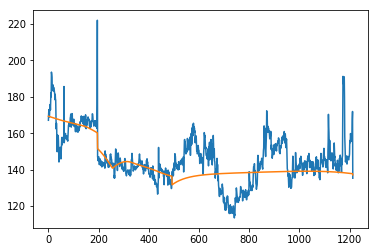


Iter: 7251, running avg elbo: -8755745.8168
Iter: 7252, running avg elbo: -8769202.7286
Iter: 7253, running avg elbo: -8767496.8813
Iter: 7254, running avg elbo: -8770657.6025
Iter: 7255, running avg elbo: -8771755.6865
Iter: 7256, running avg elbo: -8770270.2596
Iter: 7257, running avg elbo: -8774175.7770
Iter: 7258, running avg elbo: -8769619.4443
Iter: 7259, running avg elbo: -8773069.9598
Iter: 7260, running avg elbo: -8768096.3402
Iter: 7261, running avg elbo: -8764855.5968
Iter: 7262, running avg elbo: -8759931.0208
Iter: 7263, running avg elbo: -8757964.3506
Iter: 7264, running avg elbo: -8754278.2971
Iter: 7265, running avg elbo: -8752043.0542
Iter: 7266, running avg elbo: -8750828.5636
Iter: 7267, running avg elbo: -8750331.2780
Iter: 7268, running avg elbo: -8748072.6652
Iter: 7269, running avg elbo: -8746761.4185
Iter: 7270, running avg elbo: -8743151.3444
Iter: 7271, running avg elbo: -8739782.8809
Iter: 7272, running avg elbo: -8735089.8721
Iter: 7273, running avg elbo: -

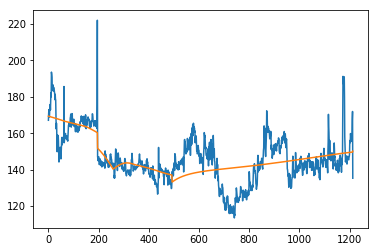


Iter: 7301, running avg elbo: -8660832.3379
Iter: 7302, running avg elbo: -8655915.2595
Iter: 7303, running avg elbo: -8652703.0719
Iter: 7304, running avg elbo: -8651663.5112
Iter: 7305, running avg elbo: -8652222.9761
Iter: 7306, running avg elbo: -8647835.2463
Iter: 7307, running avg elbo: -8644186.5039
Iter: 7308, running avg elbo: -8642935.2088
Iter: 7309, running avg elbo: -8640174.8267
Iter: 7310, running avg elbo: -8639418.2585
Iter: 7311, running avg elbo: -8636227.8359
Iter: 7312, running avg elbo: -8633090.7325
Iter: 7313, running avg elbo: -8629067.7002
Iter: 7314, running avg elbo: -8624594.0432
Iter: 7315, running avg elbo: -8620779.8278
Iter: 7316, running avg elbo: -8618019.3145
Iter: 7317, running avg elbo: -8613991.6463
Iter: 7318, running avg elbo: -8609766.0549
Iter: 7319, running avg elbo: -8605788.9593
Iter: 7320, running avg elbo: -8601671.9197
Iter: 7321, running avg elbo: -8598141.9455
Iter: 7322, running avg elbo: -8594640.5261
Iter: 7323, running avg elbo: -

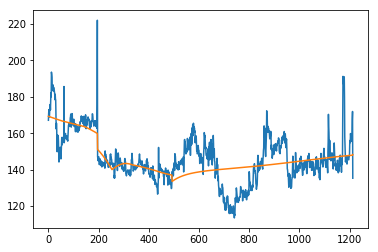


Iter: 7351, running avg elbo: -8502503.0946
Iter: 7352, running avg elbo: -8499353.9387
Iter: 7353, running avg elbo: -8497388.5093
Iter: 7354, running avg elbo: -8497030.3742
Iter: 7355, running avg elbo: -8498889.0705
Iter: 7356, running avg elbo: -8497929.6298
Iter: 7357, running avg elbo: -8501579.6335
Iter: 7358, running avg elbo: -8501193.4771
Iter: 7359, running avg elbo: -8505327.6824
Iter: 7360, running avg elbo: -8506577.3955
Iter: 7361, running avg elbo: -8515132.8616
Iter: 7362, running avg elbo: -8512733.1030
Iter: 7363, running avg elbo: -8513947.8619
Iter: 7364, running avg elbo: -8511991.1883
Iter: 7365, running avg elbo: -8510027.3664
Iter: 7366, running avg elbo: -8508781.6178
Iter: 7367, running avg elbo: -8505360.5616
Iter: 7368, running avg elbo: -8506591.4360
Iter: 7369, running avg elbo: -8504054.8416
Iter: 7370, running avg elbo: -8502828.8982
Iter: 7371, running avg elbo: -8499382.6242
Iter: 7372, running avg elbo: -8499471.2380
Iter: 7373, running avg elbo: -

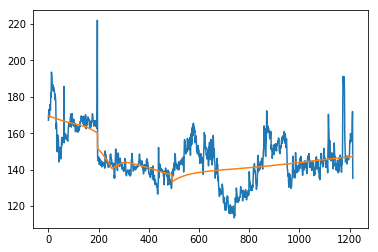


Iter: 7401, running avg elbo: -8523171.2229
Iter: 7402, running avg elbo: -8521169.4457
Iter: 7403, running avg elbo: -8518256.0212
Iter: 7404, running avg elbo: -8514145.7760
Iter: 7405, running avg elbo: -8513406.7583
Iter: 7406, running avg elbo: -8509601.9107
Iter: 7407, running avg elbo: -8509359.8616
Iter: 7408, running avg elbo: -8505446.5280
Iter: 7409, running avg elbo: -8505058.8127
Iter: 7410, running avg elbo: -8501497.9496
Iter: 7411, running avg elbo: -8506608.4101
Iter: 7412, running avg elbo: -8503038.6510
Iter: 7413, running avg elbo: -8508576.7945
Iter: 7414, running avg elbo: -8506304.1515
Iter: 7415, running avg elbo: -8509988.1300
Iter: 7416, running avg elbo: -8507565.1937
Iter: 7417, running avg elbo: -8511567.5718
Iter: 7418, running avg elbo: -8508358.4310
Iter: 7419, running avg elbo: -8525978.9267
Iter: 7420, running avg elbo: -8522080.0525
Iter: 7421, running avg elbo: -8538864.0319
Iter: 7422, running avg elbo: -8534432.3666
Iter: 7423, running avg elbo: -

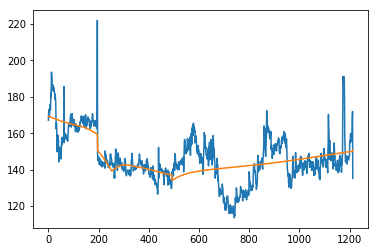


Iter: 7451, running avg elbo: -8558991.3189
Iter: 7452, running avg elbo: -8555165.7707
Iter: 7453, running avg elbo: -8562945.0630
Iter: 7454, running avg elbo: -8558530.3473
Iter: 7455, running avg elbo: -8562447.5339
Iter: 7456, running avg elbo: -8558084.3985
Iter: 7457, running avg elbo: -8556964.8545
Iter: 7458, running avg elbo: -8558224.4060
Iter: 7459, running avg elbo: -8561752.3019
Iter: 7460, running avg elbo: -8561105.3989
Iter: 7461, running avg elbo: -8562910.5849
Iter: 7462, running avg elbo: -8562315.4891
Iter: 7463, running avg elbo: -8561153.2242
Iter: 7464, running avg elbo: -8565835.8520
Iter: 7465, running avg elbo: -8566380.6834
Iter: 7466, running avg elbo: -8571596.2966
Iter: 7467, running avg elbo: -8568171.8636
Iter: 7468, running avg elbo: -8582033.9750
Iter: 7469, running avg elbo: -8580077.3802
Iter: 7470, running avg elbo: -8589273.6264
Iter: 7471, running avg elbo: -8585397.3702
Iter: 7472, running avg elbo: -8591028.0265
Iter: 7473, running avg elbo: -

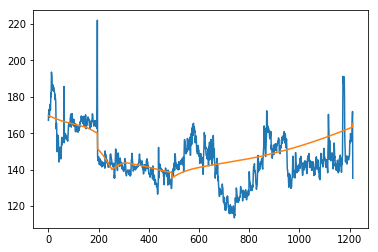


Iter: 7501, running avg elbo: -8653573.9440
Iter: 7502, running avg elbo: -8673545.2445
Iter: 7503, running avg elbo: -8668731.2121
Iter: 7504, running avg elbo: -8689871.9800
Iter: 7505, running avg elbo: -8685349.9452
Iter: 7506, running avg elbo: -8691251.1857
Iter: 7507, running avg elbo: -8686734.2589
Iter: 7508, running avg elbo: -8698350.9563
Iter: 7509, running avg elbo: -8695801.8267
Iter: 7510, running avg elbo: -8712406.5484
Iter: 7511, running avg elbo: -8707864.1430
Iter: 7512, running avg elbo: -8718577.1615
Iter: 7513, running avg elbo: -8713220.5949
Iter: 7514, running avg elbo: -8712153.4690
Iter: 7515, running avg elbo: -8713049.5143
Iter: 7516, running avg elbo: -8712828.5191
Iter: 7517, running avg elbo: -8719024.5439
Iter: 7518, running avg elbo: -8719351.0885
Iter: 7519, running avg elbo: -8721500.2976
Iter: 7520, running avg elbo: -8717280.5046
Iter: 7521, running avg elbo: -8717317.1196
Iter: 7522, running avg elbo: -8711050.9784
Iter: 7523, running avg elbo: -

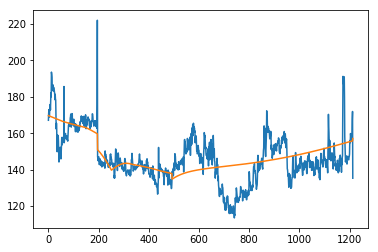


Iter: 7551, running avg elbo: -8607181.5799
Iter: 7552, running avg elbo: -8605647.3441
Iter: 7553, running avg elbo: -8600423.5406
Iter: 7554, running avg elbo: -8597361.7052
Iter: 7555, running avg elbo: -8591895.1082
Iter: 7556, running avg elbo: -8586424.5621
Iter: 7557, running avg elbo: -8581076.8965
Iter: 7558, running avg elbo: -8575639.5825
Iter: 7559, running avg elbo: -8570561.1917
Iter: 7560, running avg elbo: -8565692.4498
Iter: 7561, running avg elbo: -8560697.6003
Iter: 7562, running avg elbo: -8556047.9093
Iter: 7563, running avg elbo: -8550904.5602
Iter: 7564, running avg elbo: -8545968.0646
Iter: 7565, running avg elbo: -8541828.5439
Iter: 7566, running avg elbo: -8537278.8485
Iter: 7567, running avg elbo: -8535119.0400
Iter: 7568, running avg elbo: -8535710.7896
Iter: 7569, running avg elbo: -8530571.9467
Iter: 7570, running avg elbo: -8528038.0372
Iter: 7571, running avg elbo: -8523770.5119
Iter: 7572, running avg elbo: -8520321.8967
Iter: 7573, running avg elbo: -

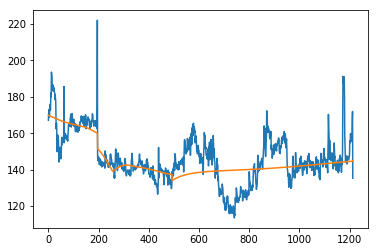


Iter: 7601, running avg elbo: -8456104.9185
Iter: 7602, running avg elbo: -8457485.0793
Iter: 7603, running avg elbo: -8455911.9535
Iter: 7604, running avg elbo: -8454750.2340
Iter: 7605, running avg elbo: -8452665.2516
Iter: 7606, running avg elbo: -8452689.4091
Iter: 7607, running avg elbo: -8455252.5350
Iter: 7608, running avg elbo: -8453137.3947
Iter: 7609, running avg elbo: -8458160.9107
Iter: 7610, running avg elbo: -8454702.5616
Iter: 7611, running avg elbo: -8459070.8060
Iter: 7612, running avg elbo: -8455409.9329
Iter: 7613, running avg elbo: -8456293.5736
Iter: 7614, running avg elbo: -8452921.3179
Iter: 7615, running avg elbo: -8448977.1047
Iter: 7616, running avg elbo: -8445919.2536
Iter: 7617, running avg elbo: -8441625.2461
Iter: 7618, running avg elbo: -8438414.6936
Iter: 7619, running avg elbo: -8434147.8967
Iter: 7620, running avg elbo: -8430591.3227
Iter: 7621, running avg elbo: -8427029.3145
Iter: 7622, running avg elbo: -8424772.3864
Iter: 7623, running avg elbo: -

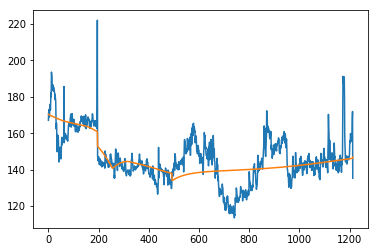


Iter: 7651, running avg elbo: -8348547.9223
Iter: 7652, running avg elbo: -8345169.0830
Iter: 7653, running avg elbo: -8342160.7122
Iter: 7654, running avg elbo: -8338637.7551
Iter: 7655, running avg elbo: -8335148.6575
Iter: 7656, running avg elbo: -8332280.8660
Iter: 7657, running avg elbo: -8329139.2723
Iter: 7658, running avg elbo: -8327436.4396
Iter: 7659, running avg elbo: -8327390.0452
Iter: 7660, running avg elbo: -8324210.1447
Iter: 7661, running avg elbo: -8320895.9483
Iter: 7662, running avg elbo: -8317620.9588
Iter: 7663, running avg elbo: -8314448.3042
Iter: 7664, running avg elbo: -8311189.3762
Iter: 7665, running avg elbo: -8308177.9624
Iter: 7666, running avg elbo: -8305195.8428
Iter: 7667, running avg elbo: -8302308.3844
Iter: 7668, running avg elbo: -8299325.1855
Iter: 7669, running avg elbo: -8297079.4287
Iter: 7670, running avg elbo: -8293962.8494
Iter: 7671, running avg elbo: -8292220.0609
Iter: 7672, running avg elbo: -8289549.5453
Iter: 7673, running avg elbo: -

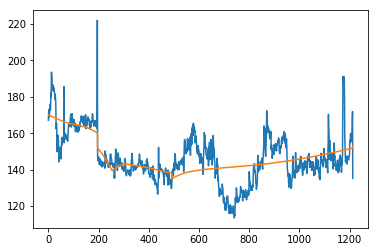


Iter: 7701, running avg elbo: -8248760.5917
Iter: 7702, running avg elbo: -8246267.7208
Iter: 7703, running avg elbo: -8248279.1936
Iter: 7704, running avg elbo: -8245464.3667
Iter: 7705, running avg elbo: -8244147.2580
Iter: 7706, running avg elbo: -8241917.5554
Iter: 7707, running avg elbo: -8241295.3149
Iter: 7708, running avg elbo: -8238916.4467
Iter: 7709, running avg elbo: -8238915.6522
Iter: 7710, running avg elbo: -8236147.3957
Iter: 7711, running avg elbo: -8234077.1918
Iter: 7712, running avg elbo: -8231744.3098
Iter: 7713, running avg elbo: -8230960.5767
Iter: 7714, running avg elbo: -8228328.1510
Iter: 7715, running avg elbo: -8225646.9995
Iter: 7716, running avg elbo: -8224391.9995
Iter: 7717, running avg elbo: -8223408.2495
Iter: 7718, running avg elbo: -8221017.9520
Iter: 7719, running avg elbo: -8219839.6925
Iter: 7720, running avg elbo: -8217425.3455
Iter: 7721, running avg elbo: -8215736.1621
Iter: 7722, running avg elbo: -8216585.9655
Iter: 7723, running avg elbo: -

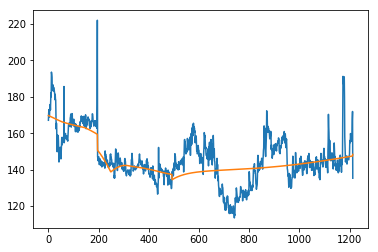


Iter: 7751, running avg elbo: -8201379.8411
Iter: 7752, running avg elbo: -8208445.7327
Iter: 7753, running avg elbo: -8207703.7954
Iter: 7754, running avg elbo: -8215578.6474
Iter: 7755, running avg elbo: -8222920.6610
Iter: 7756, running avg elbo: -8224057.6643
Iter: 7757, running avg elbo: -8230394.8377
Iter: 7758, running avg elbo: -8230370.8693
Iter: 7759, running avg elbo: -8237002.0106
Iter: 7760, running avg elbo: -8234599.9505
Iter: 7761, running avg elbo: -8232811.2910
Iter: 7762, running avg elbo: -8230311.3031
Iter: 7763, running avg elbo: -8227909.3651
Iter: 7764, running avg elbo: -8226062.2014
Iter: 7765, running avg elbo: -8225156.7044
Iter: 7766, running avg elbo: -8222528.2924
Iter: 7767, running avg elbo: -8223423.0244
Iter: 7768, running avg elbo: -8221736.3292
Iter: 7769, running avg elbo: -8225540.4359
Iter: 7770, running avg elbo: -8227916.6616
Iter: 7771, running avg elbo: -8228298.2699
Iter: 7772, running avg elbo: -8228937.0522
Iter: 7773, running avg elbo: -

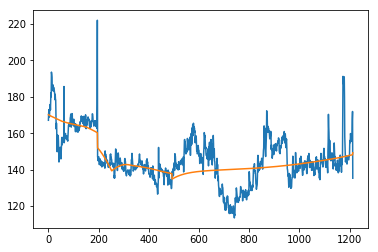


Iter: 7801, running avg elbo: -8188232.2179
Iter: 7802, running avg elbo: -8185681.8808
Iter: 7803, running avg elbo: -8183203.7420
Iter: 7804, running avg elbo: -8180658.7145
Iter: 7805, running avg elbo: -8179736.2924
Iter: 7806, running avg elbo: -8178391.5845
Iter: 7807, running avg elbo: -8175787.2786
Iter: 7808, running avg elbo: -8173536.8008
Iter: 7809, running avg elbo: -8171239.8378
Iter: 7810, running avg elbo: -8169478.4895
Iter: 7811, running avg elbo: -8167715.3446
Iter: 7812, running avg elbo: -8168144.3661
Iter: 7813, running avg elbo: -8165984.1575
Iter: 7814, running avg elbo: -8163611.3109
Iter: 7815, running avg elbo: -8163114.9128
Iter: 7816, running avg elbo: -8166373.0336
Iter: 7817, running avg elbo: -8163948.7683
Iter: 7818, running avg elbo: -8166382.1606
Iter: 7819, running avg elbo: -8164165.9090
Iter: 7820, running avg elbo: -8170385.1799
Iter: 7821, running avg elbo: -8167960.1681
Iter: 7822, running avg elbo: -8172742.4564
Iter: 7823, running avg elbo: -

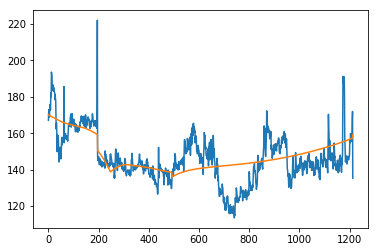


Iter: 7851, running avg elbo: -8189035.2909
Iter: 7852, running avg elbo: -8187323.8430
Iter: 7853, running avg elbo: -8186973.8246
Iter: 7854, running avg elbo: -8188397.8563
Iter: 7855, running avg elbo: -8197224.6877
Iter: 7856, running avg elbo: -8194478.7359
Iter: 7857, running avg elbo: -8199832.3885
Iter: 7858, running avg elbo: -8197091.0046
Iter: 7859, running avg elbo: -8200618.0746
Iter: 7860, running avg elbo: -8197925.8388
Iter: 7861, running avg elbo: -8203555.3704
Iter: 7862, running avg elbo: -8201721.9567
Iter: 7863, running avg elbo: -8202176.1822
Iter: 7864, running avg elbo: -8199834.8554
Iter: 7865, running avg elbo: -8198343.4768
Iter: 7866, running avg elbo: -8195310.4220
Iter: 7867, running avg elbo: -8193634.0578
Iter: 7868, running avg elbo: -8190826.7522
Iter: 7869, running avg elbo: -8188604.0997
Iter: 7870, running avg elbo: -8186679.1237
Iter: 7871, running avg elbo: -8185698.7475
Iter: 7872, running avg elbo: -8183109.7750
Iter: 7873, running avg elbo: -

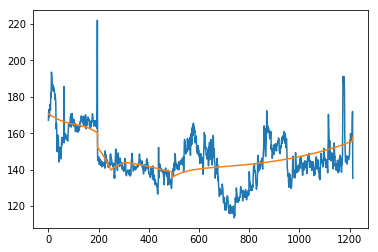


Iter: 7901, running avg elbo: -8194981.4028
Iter: 7902, running avg elbo: -8195591.7938
Iter: 7903, running avg elbo: -8197185.4908
Iter: 7904, running avg elbo: -8198473.7509
Iter: 7905, running avg elbo: -8206001.0534
Iter: 7906, running avg elbo: -8202937.3079
Iter: 7907, running avg elbo: -8204441.1298
Iter: 7908, running avg elbo: -8201729.2685
Iter: 7909, running avg elbo: -8203803.7658
Iter: 7910, running avg elbo: -8201066.1432
Iter: 7911, running avg elbo: -8203594.6217
Iter: 7912, running avg elbo: -8200391.0955
Iter: 7913, running avg elbo: -8205274.9145
Iter: 7914, running avg elbo: -8203560.8504
Iter: 7915, running avg elbo: -8202459.3619
Iter: 7916, running avg elbo: -8200007.2283
Iter: 7917, running avg elbo: -8197771.7110
Iter: 7918, running avg elbo: -8195122.3089
Iter: 7919, running avg elbo: -8192709.1208
Iter: 7920, running avg elbo: -8189964.7596
Iter: 7921, running avg elbo: -8189342.5820
Iter: 7922, running avg elbo: -8190661.8912
Iter: 7923, running avg elbo: -

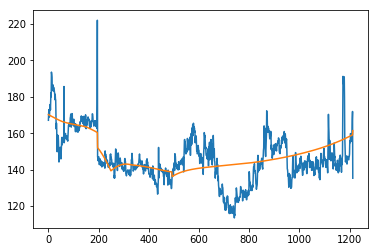


Iter: 7951, running avg elbo: -8163459.9451
Iter: 7952, running avg elbo: -8162532.3857
Iter: 7953, running avg elbo: -8160855.8968
Iter: 7954, running avg elbo: -8158257.0829
Iter: 7955, running avg elbo: -8156397.0470
Iter: 7956, running avg elbo: -8153982.7766
Iter: 7957, running avg elbo: -8151554.6338
Iter: 7958, running avg elbo: -8148470.2925
Iter: 7959, running avg elbo: -8145832.1195
Iter: 7960, running avg elbo: -8143056.1983
Iter: 7961, running avg elbo: -8140050.3313
Iter: 7962, running avg elbo: -8137220.6080
Iter: 7963, running avg elbo: -8134933.9220
Iter: 7964, running avg elbo: -8134328.0427
Iter: 7965, running avg elbo: -8134018.0823
Iter: 7966, running avg elbo: -8131924.7965
Iter: 7967, running avg elbo: -8135020.9285
Iter: 7968, running avg elbo: -8132234.5692
Iter: 7969, running avg elbo: -8135830.1335
Iter: 7970, running avg elbo: -8137243.0022
Iter: 7971, running avg elbo: -8135781.8572
Iter: 7972, running avg elbo: -8138057.5786
Iter: 7973, running avg elbo: -

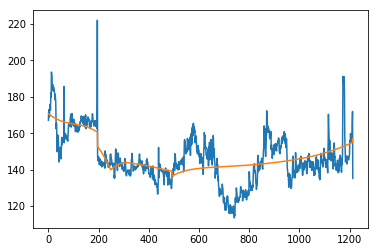

In [ ]:
niters = 8000
for itr in range(1, niters+1):
    optimizer.zero_grad()
    
    h = rec.initHidden() # for recurrent nn
    for t in reversed(range(orig_tt.size(1))):
        obs = orig_tt[:,t, :]
        out, h = rec.forward(obs, h) # init forward pass to start rnn (create batch_y0 for training)
        
        
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    #torch.manual_seed(seed)
    epsilon = torch.randn(qz0_mean.size())
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
    
    
    # forward in time and solve ode for reconstructions
    pred_z = odeint(func,z0,orig_ts,method='euler').permute(1, 0, 2)
    pred_x = dec(pred_z) #decoder
    
    # compute loss
    noise_std_ = torch.zeros(pred_x.size()) + noise_std
    noise_logvar = 2. * torch.log(noise_std_)
    logpx = log_normal_pdf(orig_tt, pred_x, noise_logvar).sum(-1).sum(-1)
    pz0_mean = pz0_logvar = torch.zeros(z0.size())
    analytic_kl = normal_kl(qz0_mean, qz0_logvar,pz0_mean, pz0_logvar).sum(-1)
    loss = torch.mean(-logpx + analytic_kl, dim=0)
    
    loss.backward()
    optimizer.step()
    loss_meter.update(loss.item())
    print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -loss_meter.avg))
    
    if (itr % 50 == 0 or itr == 30):
        print()
        print("Figure --")
        plt.figure()
        plt.plot(orig_tt[0,:,:].detach().numpy())
        plt.plot(pred_x[0,:,:].detach().numpy())
        plt.show()
        print()

Iter: 1, running avg elbo: -78384101.4933
Iter: 2, running avg elbo: -78353110.1583
Iter: 3, running avg elbo: -78111398.8167
Iter: 4, running avg elbo: -78052948.2686
Iter: 5, running avg elbo: -77754692.1459
Iter: 6, running avg elbo: -77673812.6644
Iter: 7, running avg elbo: -77369938.2978
Iter: 8, running avg elbo: -77190958.5548
Iter: 9, running avg elbo: -76895265.0093
Iter: 10, running avg elbo: -76658895.1592
Iter: 11, running avg elbo: -76374019.3276
Iter: 12, running avg elbo: -76150276.4943
Iter: 13, running avg elbo: -75942092.4093
Iter: 14, running avg elbo: -75674318.7653
Iter: 15, running avg elbo: -75471251.8576
Iter: 16, running avg elbo: -75229585.5390
Iter: 17, running avg elbo: -75028215.0836
Iter: 18, running avg elbo: -74767488.3728
Iter: 19, running avg elbo: -74601054.0891
Iter: 20, running avg elbo: -74418932.1082
Iter: 21, running avg elbo: -74287258.3871
Iter: 22, running avg elbo: -74612290.2832
Iter: 23, running avg elbo: -75138764.9004
Iter: 24, running av

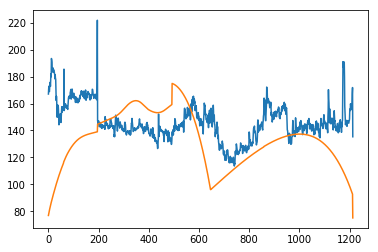


Iter: 31, running avg elbo: -76474792.4591
Iter: 32, running avg elbo: -76297168.4945
Iter: 33, running avg elbo: -76444575.6096
Iter: 34, running avg elbo: -76238083.0935
Iter: 35, running avg elbo: -76440523.0625
Iter: 36, running avg elbo: -76145135.7519
Iter: 37, running avg elbo: -76014795.3144
Iter: 38, running avg elbo: -75753573.1212
Iter: 39, running avg elbo: -75559196.2700
Iter: 40, running avg elbo: -75345197.0673
Iter: 41, running avg elbo: -75187491.9367
Iter: 42, running avg elbo: -74969232.4573
Iter: 43, running avg elbo: -74717703.8927
Iter: 44, running avg elbo: -74483509.9738
Iter: 45, running avg elbo: -74294939.6740
Iter: 46, running avg elbo: -74185619.3573
Iter: 47, running avg elbo: -73977146.0837
Iter: 48, running avg elbo: -73785796.1029
Iter: 49, running avg elbo: -73529694.5819
Iter: 50, running avg elbo: -73353723.4760

Figure --


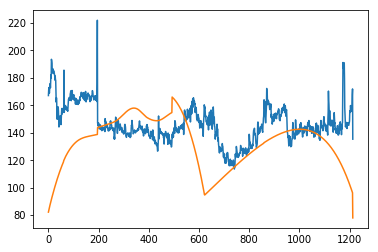


Iter: 51, running avg elbo: -73110259.2413
Iter: 52, running avg elbo: -73210914.4889
Iter: 53, running avg elbo: -73216362.7840
Iter: 54, running avg elbo: -72981742.8761
Iter: 55, running avg elbo: -72952118.0874
Iter: 56, running avg elbo: -72722023.2265
Iter: 57, running avg elbo: -72751312.3542
Iter: 58, running avg elbo: -72514063.1907
Iter: 59, running avg elbo: -72525812.1588
Iter: 60, running avg elbo: -72363058.1972
Iter: 61, running avg elbo: -72261725.5352
Iter: 62, running avg elbo: -72157463.6399
Iter: 63, running avg elbo: -71914916.2035
Iter: 64, running avg elbo: -71775268.5214
Iter: 65, running avg elbo: -71578454.8762
Iter: 66, running avg elbo: -71342813.3275
Iter: 67, running avg elbo: -71084182.6742
Iter: 68, running avg elbo: -70870998.2475
Iter: 69, running avg elbo: -70667580.5450
Iter: 70, running avg elbo: -70448507.0595
Iter: 71, running avg elbo: -70238248.2289
Iter: 72, running avg elbo: -69980680.5466
Iter: 73, running avg elbo: -69753877.4212
Iter: 74, 

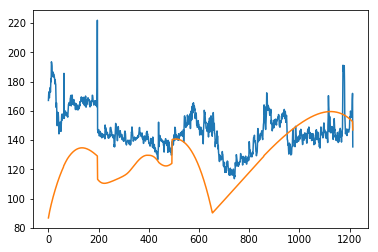


Iter: 101, running avg elbo: -66225657.8913
Iter: 102, running avg elbo: -66199626.1924
Iter: 103, running avg elbo: -66070268.7705
Iter: 104, running avg elbo: -66041321.7228
Iter: 105, running avg elbo: -65989507.3855
Iter: 106, running avg elbo: -65853325.1117
Iter: 107, running avg elbo: -65685993.1806
Iter: 108, running avg elbo: -65605048.2888
Iter: 109, running avg elbo: -65362028.7259
Iter: 110, running avg elbo: -65284442.9586
Iter: 111, running avg elbo: -65103388.0490
Iter: 112, running avg elbo: -64873512.1685
Iter: 113, running avg elbo: -64707790.9668
Iter: 114, running avg elbo: -64479116.1772
Iter: 115, running avg elbo: -64282526.8154
Iter: 116, running avg elbo: -64032678.8272
Iter: 117, running avg elbo: -63796986.7590
Iter: 118, running avg elbo: -63772919.8114
Iter: 119, running avg elbo: -63638425.3733
Iter: 120, running avg elbo: -63458076.9995
Iter: 121, running avg elbo: -63313802.7495
Iter: 122, running avg elbo: -63172302.2420
Iter: 123, running avg elbo: -6

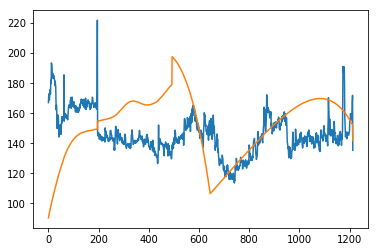


Iter: 151, running avg elbo: -63796161.4287
Iter: 152, running avg elbo: -63590130.4944
Iter: 153, running avg elbo: -63621805.9095
Iter: 154, running avg elbo: -63486282.1304
Iter: 155, running avg elbo: -63464061.0691
Iter: 156, running avg elbo: -63292977.4984
Iter: 157, running avg elbo: -63268233.1634
Iter: 158, running avg elbo: -63179231.8718
Iter: 159, running avg elbo: -63020760.9131
Iter: 160, running avg elbo: -62867027.4239
Iter: 161, running avg elbo: -62624997.1897
Iter: 162, running avg elbo: -62624084.5378
Iter: 163, running avg elbo: -62545446.3724
Iter: 164, running avg elbo: -62478500.7887
Iter: 165, running avg elbo: -62265600.3008
Iter: 166, running avg elbo: -62224358.9378
Iter: 167, running avg elbo: -62037070.6284
Iter: 168, running avg elbo: -62099611.0421
Iter: 169, running avg elbo: -61900449.4917
Iter: 170, running avg elbo: -61736366.8768
Iter: 171, running avg elbo: -61550468.2880
Iter: 172, running avg elbo: -61391072.0852
Iter: 173, running avg elbo: -6

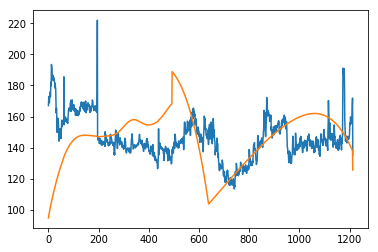


Iter: 201, running avg elbo: -57984689.3738
Iter: 202, running avg elbo: -57835720.7600
Iter: 203, running avg elbo: -57750111.4324
Iter: 204, running avg elbo: -57535234.4781
Iter: 205, running avg elbo: -57387396.2133
Iter: 206, running avg elbo: -57232268.9312
Iter: 207, running avg elbo: -57123768.9219
Iter: 208, running avg elbo: -56961896.7927
Iter: 209, running avg elbo: -56745250.1847
Iter: 210, running avg elbo: -56515613.8029
Iter: 211, running avg elbo: -56393160.6249
Iter: 212, running avg elbo: -56210203.9786
Iter: 213, running avg elbo: -56072141.2188
Iter: 214, running avg elbo: -55893807.3666
Iter: 215, running avg elbo: -55739719.6530
Iter: 216, running avg elbo: -55609015.5764
Iter: 217, running avg elbo: -55515548.3007
Iter: 218, running avg elbo: -55366012.4177
Iter: 219, running avg elbo: -55184590.3335
Iter: 220, running avg elbo: -54981265.8701
Iter: 221, running avg elbo: -54871236.1314
Iter: 222, running avg elbo: -54771318.6501
Iter: 223, running avg elbo: -5

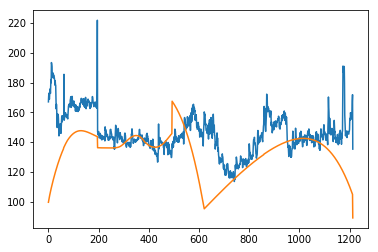


Iter: 251, running avg elbo: -51372072.4716
Iter: 252, running avg elbo: -51262765.1068
Iter: 253, running avg elbo: -51095497.2958
Iter: 254, running avg elbo: -50948342.2828
Iter: 255, running avg elbo: -50781488.2600
Iter: 256, running avg elbo: -50687313.0574
Iter: 257, running avg elbo: -50523108.5268
Iter: 258, running avg elbo: -50540892.3615
Iter: 259, running avg elbo: -50353285.1379
Iter: 260, running avg elbo: -50336962.5665
Iter: 261, running avg elbo: -50145301.4209
Iter: 262, running avg elbo: -50050752.0067
Iter: 263, running avg elbo: -49862121.4266
Iter: 264, running avg elbo: -49722369.0523
Iter: 265, running avg elbo: -49534763.5618
Iter: 266, running avg elbo: -49402395.0062
Iter: 267, running avg elbo: -49217648.8161
Iter: 268, running avg elbo: -49082948.0480
Iter: 269, running avg elbo: -49040310.0075
Iter: 270, running avg elbo: -48950403.8674
Iter: 271, running avg elbo: -48854854.5087
Iter: 272, running avg elbo: -48770051.4037
Iter: 273, running avg elbo: -4

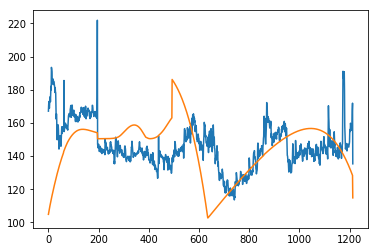


Iter: 301, running avg elbo: -47243378.4485
Iter: 302, running avg elbo: -47139369.9040
Iter: 303, running avg elbo: -47179869.8049
Iter: 304, running avg elbo: -47235798.7069
Iter: 305, running avg elbo: -47041063.1398
Iter: 306, running avg elbo: -47067653.9484
Iter: 307, running avg elbo: -46908035.9289
Iter: 308, running avg elbo: -46895838.4497
Iter: 309, running avg elbo: -46755639.4052
Iter: 310, running avg elbo: -46736807.2111
Iter: 311, running avg elbo: -46607211.7790
Iter: 312, running avg elbo: -46513118.9012
Iter: 313, running avg elbo: -46452599.6322
Iter: 314, running avg elbo: -46283181.5159
Iter: 315, running avg elbo: -46209263.4207
Iter: 316, running avg elbo: -46059021.7065
Iter: 317, running avg elbo: -46209100.2094
Iter: 318, running avg elbo: -46069177.7673
Iter: 319, running avg elbo: -46080722.3897
Iter: 320, running avg elbo: -45994632.9658
Iter: 321, running avg elbo: -45970329.0361
Iter: 322, running avg elbo: -46045857.8258
Iter: 323, running avg elbo: -4

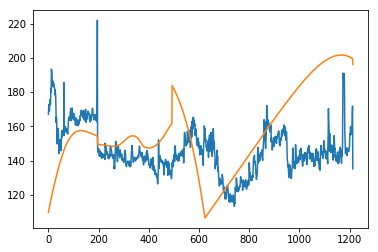


Iter: 351, running avg elbo: -45978713.7654
Iter: 352, running avg elbo: -46212509.9878
Iter: 353, running avg elbo: -46091675.0479
Iter: 354, running avg elbo: -46028990.3774
Iter: 355, running avg elbo: -46036667.1536
Iter: 356, running avg elbo: -45897446.8821
Iter: 357, running avg elbo: -45918631.3333
Iter: 358, running avg elbo: -45714743.6199
Iter: 359, running avg elbo: -45791482.9837
Iter: 360, running avg elbo: -45615739.4939
Iter: 361, running avg elbo: -45630631.1390
Iter: 362, running avg elbo: -45479090.7876
Iter: 363, running avg elbo: -45389413.8797
Iter: 364, running avg elbo: -45242442.2409
Iter: 365, running avg elbo: -45089241.7785
Iter: 366, running avg elbo: -44951925.6607
Iter: 367, running avg elbo: -44776008.2641
Iter: 368, running avg elbo: -44677252.1415
Iter: 369, running avg elbo: -44540742.4201
Iter: 370, running avg elbo: -44850170.9159
Iter: 371, running avg elbo: -44692270.0267
Iter: 372, running avg elbo: -44601585.4064
Iter: 373, running avg elbo: -4

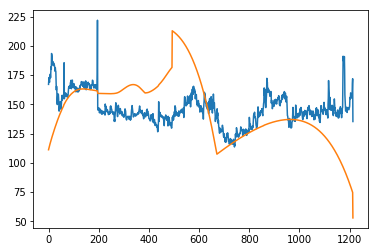


Iter: 401, running avg elbo: -42227043.9786
Iter: 402, running avg elbo: -42408723.6188
Iter: 403, running avg elbo: -42333977.5026
Iter: 404, running avg elbo: -42388097.8876
Iter: 405, running avg elbo: -42810567.1487
Iter: 406, running avg elbo: -42967079.5172
Iter: 407, running avg elbo: -43253329.2821
Iter: 408, running avg elbo: -43228948.1892
Iter: 409, running avg elbo: -43556548.7873
Iter: 410, running avg elbo: -43397299.1795
Iter: 411, running avg elbo: -43834289.5477
Iter: 412, running avg elbo: -43657947.9322
Iter: 413, running avg elbo: -43873414.3329
Iter: 414, running avg elbo: -43800057.7496
Iter: 415, running avg elbo: -43971938.2921
Iter: 416, running avg elbo: -43960211.1091
Iter: 417, running avg elbo: -44117936.5980
Iter: 418, running avg elbo: -44085114.7521
Iter: 419, running avg elbo: -44120575.0445
Iter: 420, running avg elbo: -44187112.8141
Iter: 421, running avg elbo: -44099638.0860
Iter: 422, running avg elbo: -44207316.3051
Iter: 423, running avg elbo: -4

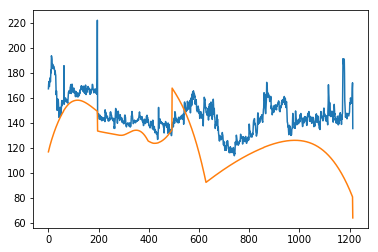


Iter: 451, running avg elbo: -45835804.2282
Iter: 452, running avg elbo: -45965483.1459
Iter: 453, running avg elbo: -45751885.7144
Iter: 454, running avg elbo: -45686533.3373
Iter: 455, running avg elbo: -45534245.1239
Iter: 456, running avg elbo: -45435982.7127
Iter: 457, running avg elbo: -45279121.7856
Iter: 458, running avg elbo: -45079545.6677
Iter: 459, running avg elbo: -45008010.1310
Iter: 460, running avg elbo: -44804468.2297
Iter: 461, running avg elbo: -44709665.8674
Iter: 462, running avg elbo: -44581769.2887
Iter: 463, running avg elbo: -44429857.4158
Iter: 464, running avg elbo: -44418503.2417
Iter: 465, running avg elbo: -44252036.5893
Iter: 466, running avg elbo: -44228033.3434
Iter: 467, running avg elbo: -44060203.5099
Iter: 468, running avg elbo: -43977951.1948
Iter: 469, running avg elbo: -43838736.9829
Iter: 470, running avg elbo: -43686547.4931
Iter: 471, running avg elbo: -43524937.6181
Iter: 472, running avg elbo: -43319718.5020
Iter: 473, running avg elbo: -4

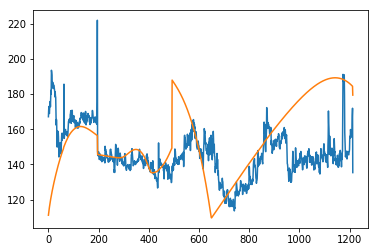


Iter: 501, running avg elbo: -41377215.7314
Iter: 502, running avg elbo: -41610645.4941
Iter: 503, running avg elbo: -41497524.6792
Iter: 504, running avg elbo: -41532901.5524
Iter: 505, running avg elbo: -41590696.7369
Iter: 506, running avg elbo: -41544461.3695
Iter: 507, running avg elbo: -41654319.7158
Iter: 508, running avg elbo: -41526327.5786
Iter: 509, running avg elbo: -41623452.7429
Iter: 510, running avg elbo: -41609857.5354
Iter: 511, running avg elbo: -41814977.1201
Iter: 512, running avg elbo: -41720144.1089
Iter: 513, running avg elbo: -41726753.7478
Iter: 514, running avg elbo: -41816101.8103
Iter: 515, running avg elbo: -41726138.5522
Iter: 516, running avg elbo: -41834318.8067
Iter: 517, running avg elbo: -42064559.9386
Iter: 518, running avg elbo: -42556111.2192
Iter: 519, running avg elbo: -42485706.8270
Iter: 520, running avg elbo: -42566533.0388
Iter: 521, running avg elbo: -42700549.9484
Iter: 522, running avg elbo: -42776080.9289
Iter: 523, running avg elbo: -4

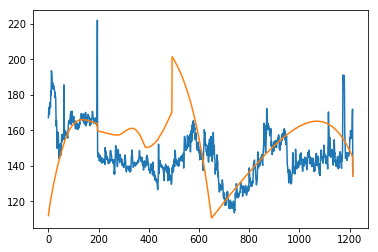


Iter: 551, running avg elbo: -42453190.5762
Iter: 552, running avg elbo: -42386568.2704
Iter: 553, running avg elbo: -42535920.0277
Iter: 554, running avg elbo: -42430434.8674
Iter: 555, running avg elbo: -42414574.0787
Iter: 556, running avg elbo: -42411025.0180
Iter: 557, running avg elbo: -42577172.4078
Iter: 558, running avg elbo: -42725757.4437
Iter: 559, running avg elbo: -42945835.2693
Iter: 560, running avg elbo: -43081430.1166
Iter: 561, running avg elbo: -43255254.1354
Iter: 562, running avg elbo: -43380487.6741
Iter: 563, running avg elbo: -43511897.7973
Iter: 564, running avg elbo: -43442312.8193
Iter: 565, running avg elbo: -43326890.7711
Iter: 566, running avg elbo: -43165090.8034
Iter: 567, running avg elbo: -42958636.8754
Iter: 568, running avg elbo: -43004495.6266
Iter: 569, running avg elbo: -43180763.7504
Iter: 570, running avg elbo: -43178862.1929
Iter: 571, running avg elbo: -43110097.2909
Iter: 572, running avg elbo: -43143057.0780
Iter: 573, running avg elbo: -4

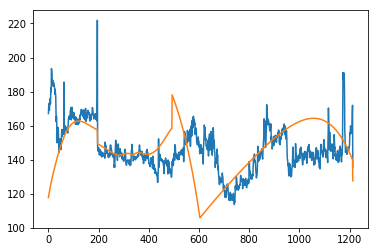


Iter: 601, running avg elbo: -42305448.6959
Iter: 602, running avg elbo: -42158292.9490
Iter: 603, running avg elbo: -42035719.7395
Iter: 604, running avg elbo: -41938282.2621
Iter: 605, running avg elbo: -41786750.0594
Iter: 606, running avg elbo: -41613307.0589
Iter: 607, running avg elbo: -41521694.8883
Iter: 608, running avg elbo: -41412889.1394
Iter: 609, running avg elbo: -41258402.6080
Iter: 610, running avg elbo: -41098836.9819
Iter: 611, running avg elbo: -40937861.1121
Iter: 612, running avg elbo: -40764518.4610
Iter: 613, running avg elbo: -40600027.7564
Iter: 614, running avg elbo: -40443063.4788
Iter: 615, running avg elbo: -40263339.4040
Iter: 616, running avg elbo: -40121830.4900
Iter: 617, running avg elbo: -39957558.0251
Iter: 618, running avg elbo: -39823685.1248
Iter: 619, running avg elbo: -39663671.6136
Iter: 620, running avg elbo: -39534125.8174
Iter: 621, running avg elbo: -39423378.8593
Iter: 622, running avg elbo: -39328500.3107
Iter: 623, running avg elbo: -3

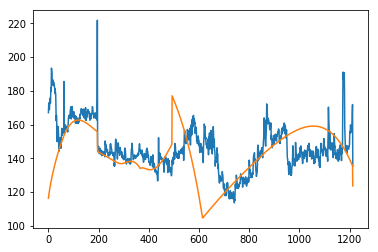


Iter: 651, running avg elbo: -36206681.5593
Iter: 652, running avg elbo: -36183325.8637
Iter: 653, running avg elbo: -36149355.5851
Iter: 654, running avg elbo: -36049841.8492
Iter: 655, running avg elbo: -36027477.9907
Iter: 656, running avg elbo: -35919838.0908
Iter: 657, running avg elbo: -35801061.0699
Iter: 658, running avg elbo: -35721079.1192
Iter: 659, running avg elbo: -35577169.9080
Iter: 660, running avg elbo: -35492526.6489
Iter: 661, running avg elbo: -35356282.2224
Iter: 662, running avg elbo: -35296636.5202
Iter: 663, running avg elbo: -35223940.7550
Iter: 664, running avg elbo: -35458867.2275
Iter: 665, running avg elbo: -35687366.0752
Iter: 666, running avg elbo: -35633553.4944
Iter: 667, running avg elbo: -35545353.2195
Iter: 668, running avg elbo: -35492021.5473
Iter: 669, running avg elbo: -35376570.1118
Iter: 670, running avg elbo: -35259097.2707
Iter: 671, running avg elbo: -35134493.7980
Iter: 672, running avg elbo: -35004865.3800
Iter: 673, running avg elbo: -3

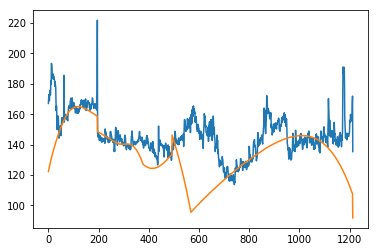


Iter: 701, running avg elbo: -33113417.3516
Iter: 702, running avg elbo: -33029331.2381
Iter: 703, running avg elbo: -32921916.8257
Iter: 704, running avg elbo: -32801935.6575
Iter: 705, running avg elbo: -32828543.1009
Iter: 706, running avg elbo: -32883113.8299
Iter: 707, running avg elbo: -32797163.9716
Iter: 708, running avg elbo: -32768415.7119
Iter: 709, running avg elbo: -32800969.3948
Iter: 710, running avg elbo: -32766752.1608
Iter: 711, running avg elbo: -32864133.7192
Iter: 712, running avg elbo: -32827699.2020
Iter: 713, running avg elbo: -32799596.0700
Iter: 714, running avg elbo: -32680935.8293
Iter: 715, running avg elbo: -32623015.0310
Iter: 716, running avg elbo: -32617999.0407
Iter: 717, running avg elbo: -32663040.5303
Iter: 718, running avg elbo: -32573966.5850
Iter: 719, running avg elbo: -32551454.9591
Iter: 720, running avg elbo: -32604247.5295
Iter: 721, running avg elbo: -32680603.9743
Iter: 722, running avg elbo: -32736426.2545
Iter: 723, running avg elbo: -3

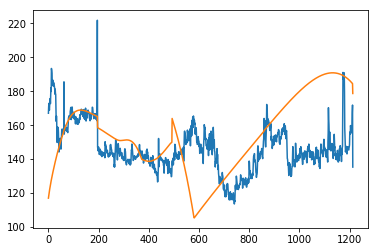


Iter: 751, running avg elbo: -33461783.8581
Iter: 752, running avg elbo: -33661103.0995
Iter: 753, running avg elbo: -33565324.8285
Iter: 754, running avg elbo: -33612365.3402
Iter: 755, running avg elbo: -33622785.4468
Iter: 756, running avg elbo: -33628308.2323
Iter: 757, running avg elbo: -33920871.5900
Iter: 758, running avg elbo: -33814832.9541
Iter: 759, running avg elbo: -33905688.4646
Iter: 760, running avg elbo: -33807466.2399
Iter: 761, running avg elbo: -33867531.4575
Iter: 762, running avg elbo: -33810257.8230
Iter: 763, running avg elbo: -33708483.7847
Iter: 764, running avg elbo: -33983380.5069
Iter: 765, running avg elbo: -33920085.9218
Iter: 766, running avg elbo: -34106351.0626
Iter: 767, running avg elbo: -34016970.1720
Iter: 768, running avg elbo: -34212893.9103
Iter: 769, running avg elbo: -34122630.9111
Iter: 770, running avg elbo: -34250414.0820
Iter: 771, running avg elbo: -34202615.5012
Iter: 772, running avg elbo: -34120294.6662
Iter: 773, running avg elbo: -3

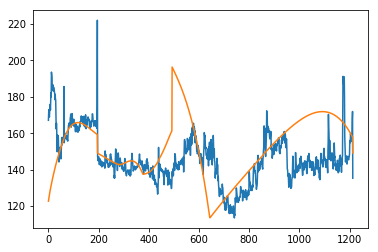


Iter: 801, running avg elbo: -32936104.7373
Iter: 802, running avg elbo: -32861452.8699
Iter: 803, running avg elbo: -32743343.5212
Iter: 804, running avg elbo: -32616992.0660
Iter: 805, running avg elbo: -32499242.4254
Iter: 806, running avg elbo: -32407721.6611
Iter: 807, running avg elbo: -32390956.5845
Iter: 808, running avg elbo: -32395876.1187
Iter: 809, running avg elbo: -32521131.8375
Iter: 810, running avg elbo: -32390591.4991
Iter: 811, running avg elbo: -32466191.9841
Iter: 812, running avg elbo: -32425588.4643
Iter: 813, running avg elbo: -32342357.7996
Iter: 814, running avg elbo: -32234986.2416
Iter: 815, running avg elbo: -32134251.0592
Iter: 816, running avg elbo: -32140813.4886
Iter: 817, running avg elbo: -32091665.6737
Iter: 818, running avg elbo: -32028622.0370
Iter: 819, running avg elbo: -31935176.8966
Iter: 820, running avg elbo: -31860036.3277
Iter: 821, running avg elbo: -31764095.6044
Iter: 822, running avg elbo: -31673268.3883
Iter: 823, running avg elbo: -3

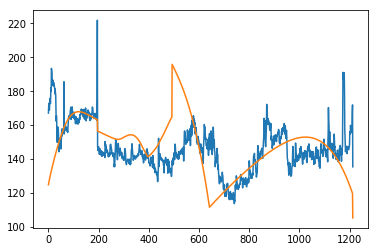


Iter: 851, running avg elbo: -29334824.2042
Iter: 852, running avg elbo: -29262287.1022
Iter: 853, running avg elbo: -29237573.1911
Iter: 854, running avg elbo: -29159241.8992
Iter: 855, running avg elbo: -29213030.9602
Iter: 856, running avg elbo: -29399803.3306
Iter: 857, running avg elbo: -29334398.2973
Iter: 858, running avg elbo: -29307676.0343
Iter: 859, running avg elbo: -29210999.3540
Iter: 860, running avg elbo: -29155935.3005
Iter: 861, running avg elbo: -29074081.6075
Iter: 862, running avg elbo: -29031785.5514
Iter: 863, running avg elbo: -28956325.6159
Iter: 864, running avg elbo: -28992090.4197
Iter: 865, running avg elbo: -28984952.9555
Iter: 866, running avg elbo: -28954197.4260
Iter: 867, running avg elbo: -28936745.4917
Iter: 868, running avg elbo: -28943504.7768
Iter: 869, running avg elbo: -28962407.6690
Iter: 870, running avg elbo: -28960883.9723
Iter: 871, running avg elbo: -28954519.5526
Iter: 872, running avg elbo: -28934162.6771
Iter: 873, running avg elbo: -2

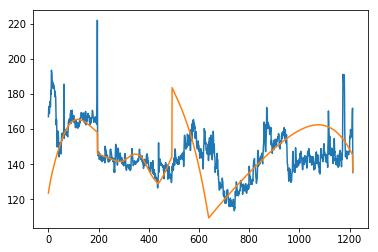


Iter: 901, running avg elbo: -28026122.6660
Iter: 902, running avg elbo: -27987695.0594
Iter: 903, running avg elbo: -27922359.2888
Iter: 904, running avg elbo: -27909793.9959
Iter: 905, running avg elbo: -27850915.3359
Iter: 906, running avg elbo: -27791952.9626
Iter: 907, running avg elbo: -27742732.7729
Iter: 908, running avg elbo: -27662329.4652
Iter: 909, running avg elbo: -27577308.0305
Iter: 910, running avg elbo: -27513530.2902
Iter: 911, running avg elbo: -27449506.8873
Iter: 912, running avg elbo: -27374665.9985
Iter: 913, running avg elbo: -27433183.2185
Iter: 914, running avg elbo: -27460944.5663
Iter: 915, running avg elbo: -27370335.0406
Iter: 916, running avg elbo: -27347191.1902
Iter: 917, running avg elbo: -27299159.6183
Iter: 918, running avg elbo: -27216926.9021
Iter: 919, running avg elbo: -27345897.5131
Iter: 920, running avg elbo: -27393271.3980
Iter: 921, running avg elbo: -27668295.3640
Iter: 922, running avg elbo: -27638622.9704
Iter: 923, running avg elbo: -2

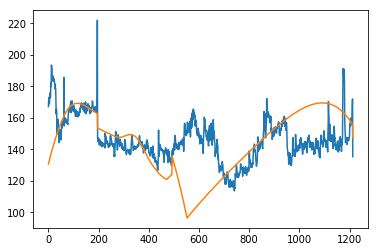


Iter: 951, running avg elbo: -29091076.4586
Iter: 952, running avg elbo: -29171916.4140
Iter: 953, running avg elbo: -29181321.8099
Iter: 954, running avg elbo: -29201693.7318
Iter: 955, running avg elbo: -29161634.6145
Iter: 956, running avg elbo: -29172032.8683
Iter: 957, running avg elbo: -29053117.8996
Iter: 958, running avg elbo: -29405001.2007
Iter: 959, running avg elbo: -29314779.8886
Iter: 960, running avg elbo: -29481506.1698
Iter: 961, running avg elbo: -29451460.1081
Iter: 962, running avg elbo: -29571758.5470
Iter: 963, running avg elbo: -29544029.0415
Iter: 964, running avg elbo: -29532673.0111
Iter: 965, running avg elbo: -29512798.4410
Iter: 966, running avg elbo: -29412264.4566
Iter: 967, running avg elbo: -29451444.8920
Iter: 968, running avg elbo: -29583043.9231
Iter: 969, running avg elbo: -29642576.6039
Iter: 970, running avg elbo: -29825464.1978
Iter: 971, running avg elbo: -29854714.5958
Iter: 972, running avg elbo: -29967898.1699
Iter: 973, running avg elbo: -3

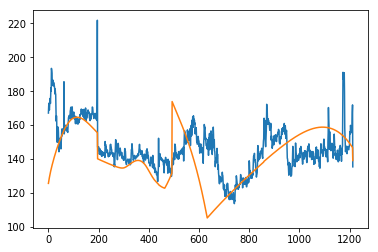


Iter: 1001, running avg elbo: -30896910.1994
Iter: 1002, running avg elbo: -31074008.9774
Iter: 1003, running avg elbo: -31159707.6876
Iter: 1004, running avg elbo: -31200587.5707
Iter: 1005, running avg elbo: -31290037.1750
Iter: 1006, running avg elbo: -31470120.9233
Iter: 1007, running avg elbo: -31524406.4740
Iter: 1008, running avg elbo: -31506860.2693
Iter: 1009, running avg elbo: -31616433.8266
Iter: 1010, running avg elbo: -32182118.7683
Iter: 1011, running avg elbo: -32153872.0406
Iter: 1012, running avg elbo: -32272891.2802
Iter: 1013, running avg elbo: -32356260.5674
Iter: 1014, running avg elbo: -32386237.0818
Iter: 1015, running avg elbo: -32616605.8709
Iter: 1016, running avg elbo: -32718329.4922
Iter: 1017, running avg elbo: -32675751.6973
Iter: 1018, running avg elbo: -32520104.5803
Iter: 1019, running avg elbo: -32800847.0945
Iter: 1020, running avg elbo: -32716957.9836
Iter: 1021, running avg elbo: -32845829.2838
Iter: 1022, running avg elbo: -32738997.2509
Iter: 102

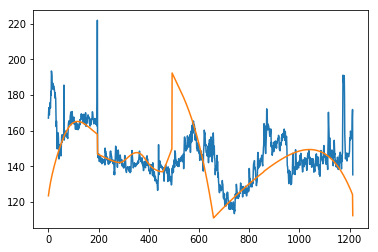


Iter: 1051, running avg elbo: -31707675.5299
Iter: 1052, running avg elbo: -31601123.4146
Iter: 1053, running avg elbo: -31464899.0404
Iter: 1054, running avg elbo: -31361632.7100
Iter: 1055, running avg elbo: -31234338.0229
Iter: 1056, running avg elbo: -31135323.6227
Iter: 1057, running avg elbo: -31069826.4865
Iter: 1058, running avg elbo: -30931921.9816
Iter: 1059, running avg elbo: -30924715.3218
Iter: 1060, running avg elbo: -30855666.8486
Iter: 1061, running avg elbo: -30727972.6201
Iter: 1062, running avg elbo: -30612247.3939
Iter: 1063, running avg elbo: -30498055.9199
Iter: 1064, running avg elbo: -30382402.5007
Iter: 1065, running avg elbo: -30265624.1557
Iter: 1066, running avg elbo: -30204625.7142
Iter: 1067, running avg elbo: -30147814.8370
Iter: 1068, running avg elbo: -30091381.6487
Iter: 1069, running avg elbo: -30089217.0522
Iter: 1070, running avg elbo: -29961206.9617
Iter: 1071, running avg elbo: -29901666.9320
Iter: 1072, running avg elbo: -29830348.5627
Iter: 107

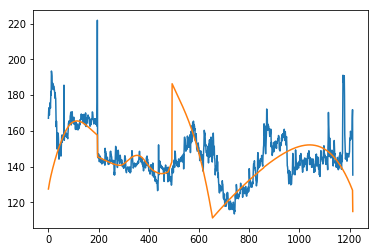


Iter: 1101, running avg elbo: -27766842.3816
Iter: 1102, running avg elbo: -27677667.8178
Iter: 1103, running avg elbo: -27588840.1996
Iter: 1104, running avg elbo: -27522645.6176
Iter: 1105, running avg elbo: -27474874.5814
Iter: 1106, running avg elbo: -27453391.8756
Iter: 1107, running avg elbo: -27475910.8169
Iter: 1108, running avg elbo: -27487952.8887
Iter: 1109, running avg elbo: -27450068.2998
Iter: 1110, running avg elbo: -27414826.0168
Iter: 1111, running avg elbo: -27385539.4567
Iter: 1112, running avg elbo: -27378551.0021
Iter: 1113, running avg elbo: -27328120.1721
Iter: 1114, running avg elbo: -27318420.4103
Iter: 1115, running avg elbo: -27210853.0362
Iter: 1116, running avg elbo: -27259563.1859
Iter: 1117, running avg elbo: -27151791.3640
Iter: 1118, running avg elbo: -27082068.5504
Iter: 1119, running avg elbo: -27002029.8449
Iter: 1120, running avg elbo: -26926802.5864
Iter: 1121, running avg elbo: -26847303.2806
Iter: 1122, running avg elbo: -26775781.6878
Iter: 112

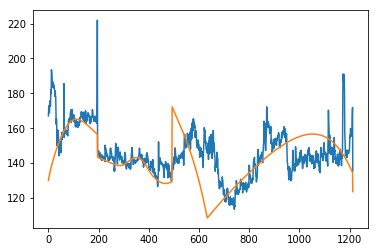


Iter: 1151, running avg elbo: -25054912.3688
Iter: 1152, running avg elbo: -24976175.4051
Iter: 1153, running avg elbo: -24885459.8010
Iter: 1154, running avg elbo: -24838203.5630
Iter: 1155, running avg elbo: -24787489.0474
Iter: 1156, running avg elbo: -24717006.6169
Iter: 1157, running avg elbo: -24652770.7908
Iter: 1158, running avg elbo: -24616510.1829
Iter: 1159, running avg elbo: -24545769.1410
Iter: 1160, running avg elbo: -24544146.7496
Iter: 1161, running avg elbo: -24539954.0021
Iter: 1162, running avg elbo: -24742685.1021
Iter: 1163, running avg elbo: -24776358.2911
Iter: 1164, running avg elbo: -24726278.6082
Iter: 1165, running avg elbo: -24748095.4021
Iter: 1166, running avg elbo: -24693534.6081
Iter: 1167, running avg elbo: -24665355.5820
Iter: 1168, running avg elbo: -24665911.3262
Iter: 1169, running avg elbo: -24664472.9129
Iter: 1170, running avg elbo: -24629818.5638
Iter: 1171, running avg elbo: -24551388.9981
Iter: 1172, running avg elbo: -24467385.5482
Iter: 117

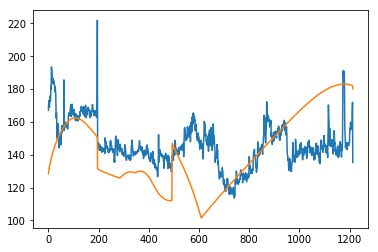


Iter: 1201, running avg elbo: -24490497.0770
Iter: 1202, running avg elbo: -24572881.0662
Iter: 1203, running avg elbo: -24724401.0555
Iter: 1204, running avg elbo: -24656349.8650
Iter: 1205, running avg elbo: -24678714.6063
Iter: 1206, running avg elbo: -24700003.7803
Iter: 1207, running avg elbo: -24711929.6225
Iter: 1208, running avg elbo: -24853902.3662
Iter: 1209, running avg elbo: -24902839.9626
Iter: 1210, running avg elbo: -24878216.9630
Iter: 1211, running avg elbo: -24803755.3733
Iter: 1212, running avg elbo: -24782506.1596
Iter: 1213, running avg elbo: -24708161.0380
Iter: 1214, running avg elbo: -24696462.0276
Iter: 1215, running avg elbo: -24615632.9773
Iter: 1216, running avg elbo: -24537954.9076
Iter: 1217, running avg elbo: -24478716.5185
Iter: 1218, running avg elbo: -24417454.6133
Iter: 1219, running avg elbo: -24355978.3672
Iter: 1220, running avg elbo: -24538448.6635
Iter: 1221, running avg elbo: -24746940.4169
Iter: 1222, running avg elbo: -24657648.8327
Iter: 122

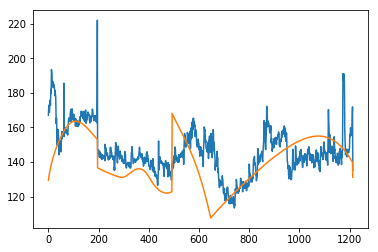


Iter: 1251, running avg elbo: -23593797.7932
Iter: 1252, running avg elbo: -23551865.7152
Iter: 1253, running avg elbo: -23543939.0981
Iter: 1254, running avg elbo: -23464417.0671
Iter: 1255, running avg elbo: -23426830.4364
Iter: 1256, running avg elbo: -23372373.2721
Iter: 1257, running avg elbo: -23303181.6194
Iter: 1258, running avg elbo: -23245023.7232
Iter: 1259, running avg elbo: -23183618.1259
Iter: 1260, running avg elbo: -23101269.6147
Iter: 1261, running avg elbo: -23061895.8385
Iter: 1262, running avg elbo: -22988574.2201
Iter: 1263, running avg elbo: -22916361.5379
Iter: 1264, running avg elbo: -22875741.9826
Iter: 1265, running avg elbo: -22835086.3027
Iter: 1266, running avg elbo: -22762211.5197
Iter: 1267, running avg elbo: -22717677.4445
Iter: 1268, running avg elbo: -22658084.5601
Iter: 1269, running avg elbo: -22745276.1145
Iter: 1270, running avg elbo: -22670420.2233
Iter: 1271, running avg elbo: -22670355.4811
Iter: 1272, running avg elbo: -22672435.8063
Iter: 127

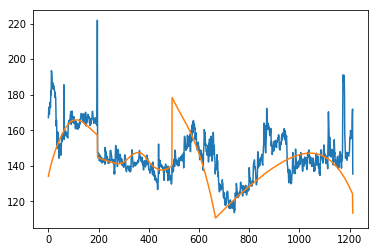


Iter: 1301, running avg elbo: -22363427.2876
Iter: 1302, running avg elbo: -22292064.4747
Iter: 1303, running avg elbo: -22225100.1100
Iter: 1304, running avg elbo: -22158626.9489
Iter: 1305, running avg elbo: -22089627.6594
Iter: 1306, running avg elbo: -22007653.4228
Iter: 1307, running avg elbo: -21957498.6486
Iter: 1308, running avg elbo: -21872732.9021
Iter: 1309, running avg elbo: -21814039.0830
Iter: 1310, running avg elbo: -21739427.4422
Iter: 1311, running avg elbo: -21665305.9678
Iter: 1312, running avg elbo: -21598811.1681
Iter: 1313, running avg elbo: -21572890.9364
Iter: 1314, running avg elbo: -21534928.6471
Iter: 1315, running avg elbo: -21487290.2906
Iter: 1316, running avg elbo: -21439628.2977
Iter: 1317, running avg elbo: -21387322.3247
Iter: 1318, running avg elbo: -21311463.7515
Iter: 1319, running avg elbo: -21252324.2040
Iter: 1320, running avg elbo: -21222238.8019
Iter: 1321, running avg elbo: -21222307.3939
Iter: 1322, running avg elbo: -21188886.5200
Iter: 132

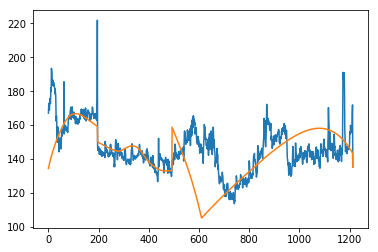


Iter: 1351, running avg elbo: -23114523.0295
Iter: 1352, running avg elbo: -23019096.9492
Iter: 1353, running avg elbo: -22964187.6797
Iter: 1354, running avg elbo: -22907465.7629
Iter: 1355, running avg elbo: -22838197.2753
Iter: 1356, running avg elbo: -22794039.2825
Iter: 1357, running avg elbo: -22748864.0697
Iter: 1358, running avg elbo: -22683298.9690
Iter: 1359, running avg elbo: -22623092.0293
Iter: 1360, running avg elbo: -22564023.4590
Iter: 1361, running avg elbo: -22537714.2844
Iter: 1362, running avg elbo: -22456523.6316
Iter: 1363, running avg elbo: -22389586.5553
Iter: 1364, running avg elbo: -22385928.8897
Iter: 1365, running avg elbo: -22327131.2308
Iter: 1366, running avg elbo: -22301058.6185
Iter: 1367, running avg elbo: -22232195.2123
Iter: 1368, running avg elbo: -22171126.1702
Iter: 1369, running avg elbo: -22086384.1185
Iter: 1370, running avg elbo: -22044054.7173
Iter: 1371, running avg elbo: -21965255.6401
Iter: 1372, running avg elbo: -21935235.5637
Iter: 137

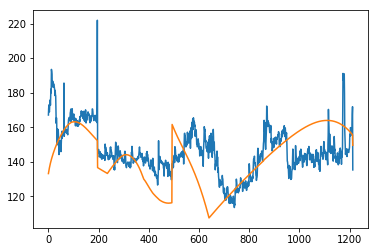


Iter: 1401, running avg elbo: -20667729.2090
Iter: 1402, running avg elbo: -20639007.9169
Iter: 1403, running avg elbo: -20766174.8578
Iter: 1404, running avg elbo: -20834477.2292
Iter: 1405, running avg elbo: -21252606.1369
Iter: 1406, running avg elbo: -21290678.5955
Iter: 1407, running avg elbo: -21770449.8096
Iter: 1408, running avg elbo: -21865242.5715
Iter: 1409, running avg elbo: -21990956.2258
Iter: 1410, running avg elbo: -22135566.3835
Iter: 1411, running avg elbo: -22094781.0597
Iter: 1412, running avg elbo: -22317364.5691
Iter: 1413, running avg elbo: -22270754.0634
Iter: 1414, running avg elbo: -22300902.3228
Iter: 1415, running avg elbo: -22316779.9395
Iter: 1416, running avg elbo: -22225224.8401
Iter: 1417, running avg elbo: -22212853.3917
Iter: 1418, running avg elbo: -22152224.8778
Iter: 1419, running avg elbo: -22107092.8490
Iter: 1420, running avg elbo: -22040893.4205
Iter: 1421, running avg elbo: -21961419.6463
Iter: 1422, running avg elbo: -22094886.5299
Iter: 142

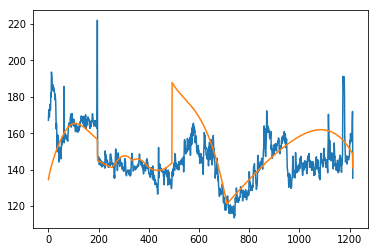


Iter: 1451, running avg elbo: -21027504.8353
Iter: 1452, running avg elbo: -21010639.7070
Iter: 1453, running avg elbo: -20955940.7499
Iter: 1454, running avg elbo: -20933576.1424
Iter: 1455, running avg elbo: -20854901.4910
Iter: 1456, running avg elbo: -20814777.8161
Iter: 1457, running avg elbo: -20725378.9279
Iter: 1458, running avg elbo: -20682020.5386
Iter: 1459, running avg elbo: -20704183.9332
Iter: 1460, running avg elbo: -20651899.8039
Iter: 1461, running avg elbo: -20734736.2259
Iter: 1462, running avg elbo: -20657525.1336
Iter: 1463, running avg elbo: -20698990.0423
Iter: 1464, running avg elbo: -20613153.8919
Iter: 1465, running avg elbo: -20577588.0529
Iter: 1466, running avg elbo: -20531268.0424
Iter: 1467, running avg elbo: -20448409.9420
Iter: 1468, running avg elbo: -20425099.3826
Iter: 1469, running avg elbo: -20350229.1487
Iter: 1470, running avg elbo: -20326758.9173
Iter: 1471, running avg elbo: -20242185.5481
Iter: 1472, running avg elbo: -20253156.7526
Iter: 147

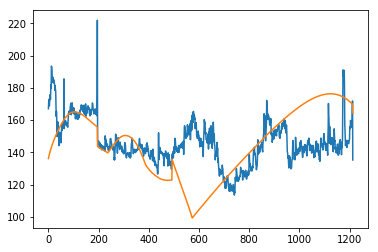


Iter: 1501, running avg elbo: -21024221.8821
Iter: 1502, running avg elbo: -21008535.0032
Iter: 1503, running avg elbo: -20919673.3332
Iter: 1504, running avg elbo: -20969655.1799
Iter: 1505, running avg elbo: -20884124.8581
Iter: 1506, running avg elbo: -20857349.3695
Iter: 1507, running avg elbo: -20825111.2158
Iter: 1508, running avg elbo: -20795927.5636
Iter: 1509, running avg elbo: -20737940.2280
Iter: 1510, running avg elbo: -20673163.7557
Iter: 1511, running avg elbo: -20579189.6282
Iter: 1512, running avg elbo: -20629327.2119
Iter: 1513, running avg elbo: -20557669.3698
Iter: 1514, running avg elbo: -20527622.1161
Iter: 1515, running avg elbo: -20530449.3749
Iter: 1516, running avg elbo: -20517013.0612
Iter: 1517, running avg elbo: -20469058.5206
Iter: 1518, running avg elbo: -20415899.8253
Iter: 1519, running avg elbo: -20363338.4671
Iter: 1520, running avg elbo: -20277642.8724
Iter: 1521, running avg elbo: -20205340.9437
Iter: 1522, running avg elbo: -20157546.1843
Iter: 152

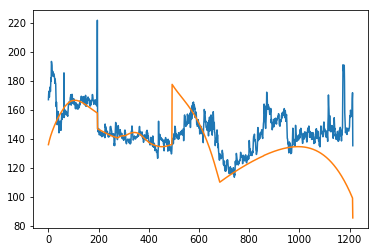


Iter: 1551, running avg elbo: -20356861.4629
Iter: 1552, running avg elbo: -20368165.0483
Iter: 1553, running avg elbo: -20296476.3878
Iter: 1554, running avg elbo: -20229586.8439
Iter: 1555, running avg elbo: -20173391.3955
Iter: 1556, running avg elbo: -20082764.5015
Iter: 1557, running avg elbo: -20029744.0365
Iter: 1558, running avg elbo: -19947885.3061
Iter: 1559, running avg elbo: -19883177.8131
Iter: 1560, running avg elbo: -19798624.8249
Iter: 1561, running avg elbo: -19728263.1367
Iter: 1562, running avg elbo: -19645505.6553
Iter: 1563, running avg elbo: -19557177.2488
Iter: 1564, running avg elbo: -19477681.3163
Iter: 1565, running avg elbo: -19394849.2431
Iter: 1566, running avg elbo: -19336763.6607
Iter: 1567, running avg elbo: -19280773.7641
Iter: 1568, running avg elbo: -19224110.1564
Iter: 1569, running avg elbo: -19176553.9649
Iter: 1570, running avg elbo: -19112926.5452
Iter: 1571, running avg elbo: -19046858.5698
Iter: 1572, running avg elbo: -18972370.4841
Iter: 157

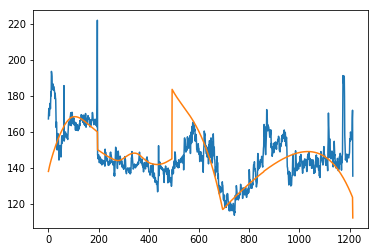


Iter: 1601, running avg elbo: -18679994.2437
Iter: 1602, running avg elbo: -18699488.0213
Iter: 1603, running avg elbo: -18745094.9011
Iter: 1604, running avg elbo: -18700789.5221
Iter: 1605, running avg elbo: -18648381.0568
Iter: 1606, running avg elbo: -18653327.5063
Iter: 1607, running avg elbo: -18577311.7112
Iter: 1608, running avg elbo: -18522056.7841
Iter: 1609, running avg elbo: -18469518.7663
Iter: 1610, running avg elbo: -18437275.8886
Iter: 1611, running avg elbo: -18362231.6497
Iter: 1612, running avg elbo: -18323116.5232
Iter: 1613, running avg elbo: -18263805.8780
Iter: 1614, running avg elbo: -18208057.2192
Iter: 1615, running avg elbo: -18180915.2170
Iter: 1616, running avg elbo: -18141774.1148
Iter: 1617, running avg elbo: -18075152.4237
Iter: 1618, running avg elbo: -18006226.0995
Iter: 1619, running avg elbo: -17965361.2085
Iter: 1620, running avg elbo: -17892505.2764
Iter: 1621, running avg elbo: -17867466.4136
Iter: 1622, running avg elbo: -17869422.9495
Iter: 162

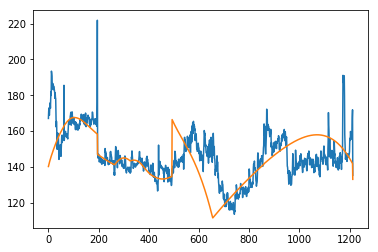


Iter: 1651, running avg elbo: -17602634.0717
Iter: 1652, running avg elbo: -17531892.2810
Iter: 1653, running avg elbo: -17481323.0481
Iter: 1654, running avg elbo: -17447987.6777
Iter: 1655, running avg elbo: -17398477.2809
Iter: 1656, running avg elbo: -17355029.2681
Iter: 1657, running avg elbo: -17409067.4954
Iter: 1658, running avg elbo: -17402099.0704
Iter: 1659, running avg elbo: -17408598.1797
Iter: 1660, running avg elbo: -17529679.6579
Iter: 1661, running avg elbo: -17686214.8414
Iter: 1662, running avg elbo: -17639195.8729
Iter: 1663, running avg elbo: -17698490.2542
Iter: 1664, running avg elbo: -17786113.2117
Iter: 1665, running avg elbo: -17979997.9596
Iter: 1666, running avg elbo: -18123738.1000
Iter: 1667, running avg elbo: -18214903.1990
Iter: 1668, running avg elbo: -18230781.3670
Iter: 1669, running avg elbo: -18197036.6933
Iter: 1670, running avg elbo: -18149410.2064
Iter: 1671, running avg elbo: -18132771.4743
Iter: 1672, running avg elbo: -18071318.6196
Iter: 167

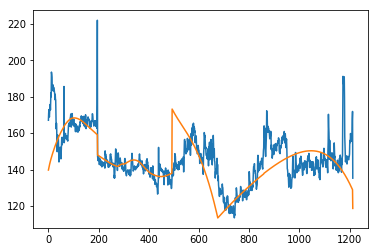


Iter: 1701, running avg elbo: -17224600.0889
Iter: 1702, running avg elbo: -17165877.0580
Iter: 1703, running avg elbo: -17138622.7374
Iter: 1704, running avg elbo: -17136386.8101
Iter: 1705, running avg elbo: -17084582.6120
Iter: 1706, running avg elbo: -17096514.2059
Iter: 1707, running avg elbo: -17032054.7938
Iter: 1708, running avg elbo: -17018815.2559
Iter: 1709, running avg elbo: -17025589.4233
Iter: 1710, running avg elbo: -17100145.9091
Iter: 1711, running avg elbo: -17049111.6100
Iter: 1712, running avg elbo: -16993582.2039
Iter: 1713, running avg elbo: -16964605.3318
Iter: 1714, running avg elbo: -16897105.1885
Iter: 1715, running avg elbo: -16942680.6366
Iter: 1716, running avg elbo: -16959494.8903
Iter: 1717, running avg elbo: -16957675.2214
Iter: 1718, running avg elbo: -17018765.5092
Iter: 1719, running avg elbo: -16974988.6341
Iter: 1720, running avg elbo: -16986165.2877
Iter: 1721, running avg elbo: -17001458.6748
Iter: 1722, running avg elbo: -16973447.8581
Iter: 172

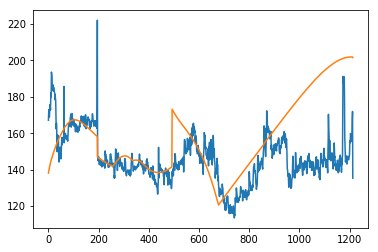


Iter: 1751, running avg elbo: -17088215.1082
Iter: 1752, running avg elbo: -17246489.2171
Iter: 1753, running avg elbo: -17226443.2649
Iter: 1754, running avg elbo: -17283915.1323
Iter: 1755, running avg elbo: -17295743.3810
Iter: 1756, running avg elbo: -17335301.5272
Iter: 1757, running avg elbo: -17341564.2919
Iter: 1758, running avg elbo: -17279548.4290
Iter: 1759, running avg elbo: -17719623.7047
Iter: 1760, running avg elbo: -17789225.1076
Iter: 1761, running avg elbo: -18211903.0966
Iter: 1762, running avg elbo: -18473910.2256
Iter: 1763, running avg elbo: -18907798.8433
Iter: 1764, running avg elbo: -19184808.1749
Iter: 1765, running avg elbo: -19602426.4931
Iter: 1766, running avg elbo: -19794395.0282
Iter: 1767, running avg elbo: -21327305.9579
Iter: 1768, running avg elbo: -22726339.6184
Iter: 1769, running avg elbo: -23567374.3822
Iter: 1770, running avg elbo: -24715173.2783
Iter: 1771, running avg elbo: -25929538.9856
Iter: 1772, running avg elbo: -26736369.1157
Iter: 177

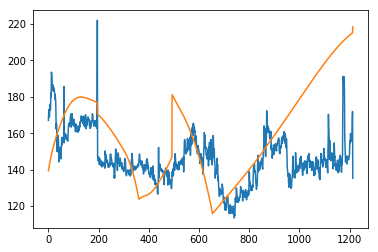


Iter: 1801, running avg elbo: -33524807.4249
Iter: 1802, running avg elbo: -33693518.7907
Iter: 1803, running avg elbo: -33678674.9628
Iter: 1804, running avg elbo: -33707380.4931
Iter: 1805, running avg elbo: -33711624.3682
Iter: 1806, running avg elbo: -33551550.9645
Iter: 1807, running avg elbo: -33708326.3349
Iter: 1808, running avg elbo: -33591139.2915
Iter: 1809, running avg elbo: -33583700.2586
Iter: 1810, running avg elbo: -33462310.5760
Iter: 1811, running avg elbo: -33304100.1503
Iter: 1812, running avg elbo: -33202390.9888
Iter: 1813, running avg elbo: -33074307.3189
Iter: 1814, running avg elbo: -32960565.9857
Iter: 1815, running avg elbo: -32883632.1058
Iter: 1816, running avg elbo: -32721633.4848
Iter: 1817, running avg elbo: -32663173.0099
Iter: 1818, running avg elbo: -32536081.0598
Iter: 1819, running avg elbo: -32464193.9892
Iter: 1820, running avg elbo: -32436761.0893
Iter: 1821, running avg elbo: -32300083.9784
Iter: 1822, running avg elbo: -32299145.8386
Iter: 182

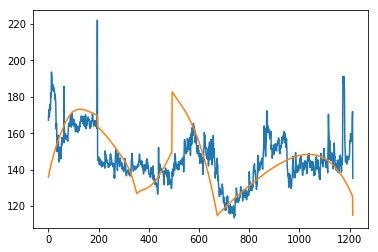


Iter: 1851, running avg elbo: -28921869.6795
Iter: 1852, running avg elbo: -28782822.1927
Iter: 1853, running avg elbo: -28673712.7308
Iter: 1854, running avg elbo: -28551018.0035
Iter: 1855, running avg elbo: -28409308.0135
Iter: 1856, running avg elbo: -28276312.2933
Iter: 1857, running avg elbo: -28139352.3404
Iter: 1858, running avg elbo: -28004825.4070
Iter: 1859, running avg elbo: -27875606.0729
Iter: 1860, running avg elbo: -27753601.1122
Iter: 1861, running avg elbo: -27627873.9411
Iter: 1862, running avg elbo: -27494278.3316
Iter: 1863, running avg elbo: -27363517.8983
Iter: 1864, running avg elbo: -27240233.8793
Iter: 1865, running avg elbo: -27110191.0706
Iter: 1866, running avg elbo: -27002627.5498
Iter: 1867, running avg elbo: -26964188.2944
Iter: 1868, running avg elbo: -26850185.5814
Iter: 1869, running avg elbo: -26731926.4456
Iter: 1870, running avg elbo: -26610681.7611
Iter: 1871, running avg elbo: -26486709.8335
Iter: 1872, running avg elbo: -26367274.2252
Iter: 187

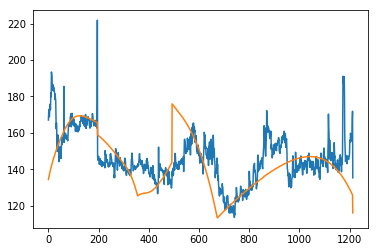


Iter: 1901, running avg elbo: -23763837.5844
Iter: 1902, running avg elbo: -23714695.9485
Iter: 1903, running avg elbo: -23618275.7691
Iter: 1904, running avg elbo: -23522427.9614
Iter: 1905, running avg elbo: -23419542.3317
Iter: 1906, running avg elbo: -23381690.5284
Iter: 1907, running avg elbo: -23311187.2631
Iter: 1908, running avg elbo: -23308606.4505
Iter: 1909, running avg elbo: -23273475.5060
Iter: 1910, running avg elbo: -23345369.6110
Iter: 1911, running avg elbo: -23395676.8948
Iter: 1912, running avg elbo: -23297046.0659
Iter: 1913, running avg elbo: -23320823.2052
Iter: 1914, running avg elbo: -23299802.4532
Iter: 1915, running avg elbo: -23203590.5786
Iter: 1916, running avg elbo: -23168470.4729
Iter: 1917, running avg elbo: -23105036.2481
Iter: 1918, running avg elbo: -23091343.2657
Iter: 1919, running avg elbo: -23000577.5830
Iter: 1920, running avg elbo: -22906180.7872
Iter: 1921, running avg elbo: -22976896.5993
Iter: 1922, running avg elbo: -22896196.1633
Iter: 192

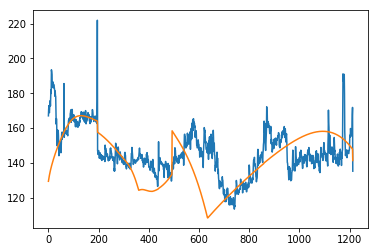


Iter: 1951, running avg elbo: -23722871.7078
Iter: 1952, running avg elbo: -23867281.0707
Iter: 1953, running avg elbo: -23798416.2400
Iter: 1954, running avg elbo: -23691631.3976
Iter: 1955, running avg elbo: -23626546.0636
Iter: 1956, running avg elbo: -23659066.3230
Iter: 1957, running avg elbo: -23607683.1198
Iter: 1958, running avg elbo: -23580947.5086
Iter: 1959, running avg elbo: -23629535.5735
Iter: 1960, running avg elbo: -23604750.4378
Iter: 1961, running avg elbo: -23649427.9534
Iter: 1962, running avg elbo: -23584192.6939
Iter: 1963, running avg elbo: -23547106.2069
Iter: 1964, running avg elbo: -23533272.7848
Iter: 1965, running avg elbo: -23492806.4770
Iter: 1966, running avg elbo: -23406249.8922
Iter: 1967, running avg elbo: -23339000.0833
Iter: 1968, running avg elbo: -23264065.2025
Iter: 1969, running avg elbo: -23163196.1704
Iter: 1970, running avg elbo: -23119402.0287
Iter: 1971, running avg elbo: -23023530.7385
Iter: 1972, running avg elbo: -22968065.0311
Iter: 197

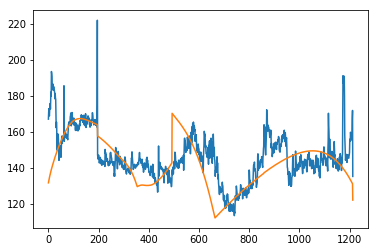

In [ ]:
niters = 2000
for itr in range(1, niters+1):
    optimizer.zero_grad()
    
    h = rec.initHidden() # for recurrent nn
    for t in reversed(range(orig_tt.size(1))):
        obs = orig_tt[:,t, :]
        out, h = rec.forward(obs, h) # init forward pass to start rnn (create batch_y0 for training)
        
        
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    #torch.manual_seed(seed)
    epsilon = torch.randn(qz0_mean.size())
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
    
    
    # forward in time and solve ode for reconstructions
    pred_z = odeint(func,z0,orig_ts,method='euler').permute(1, 0, 2)
    pred_x = dec(pred_z) #decoder
    
    # compute loss
    noise_std_ = torch.zeros(pred_x.size()) + noise_std
    noise_logvar = 2. * torch.log(noise_std_)
    logpx = log_normal_pdf(orig_tt, pred_x, noise_logvar).sum(-1).sum(-1)
    pz0_mean = pz0_logvar = torch.zeros(z0.size())
    analytic_kl = normal_kl(qz0_mean, qz0_logvar,pz0_mean, pz0_logvar).sum(-1)
    loss = torch.mean(-logpx + analytic_kl, dim=0)
    
    loss.backward()
    optimizer.step()
    loss_meter.update(loss.item())
    print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -loss_meter.avg))
    
    if (itr % 50 == 0 or itr == 30):
        print()
        print("Figure --")
        plt.figure()
        plt.plot(orig_tt[0,:,:].detach().numpy())
        plt.plot(pred_x[0,:,:].detach().numpy())
        plt.show()
        print()


In [ ]:
niters = 3000
for itr in range(1, niters+1):
    optimizer.zero_grad()
    
    h = rec.initHidden() # for recurrent nn
    for t in reversed(range(orig_tt.size(1))):
        obs = orig_tt[:,t, :]
        out, h = rec.forward(obs, h) # init forward pass to start rnn (create batch_y0 for training)
        
        
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    #torch.manual_seed(seed)
    epsilon = torch.randn(qz0_mean.size())
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
    
    
    # forward in time and solve ode for reconstructions
    pred_z = odeint(func,z0,orig_ts,method='euler').permute(1, 0, 2)
    pred_x = dec(pred_z) #decoder
    
    # compute loss
    noise_std_ = torch.zeros(pred_x.size()) + noise_std
    noise_logvar = 2. * torch.log(noise_std_)
    logpx = log_normal_pdf(orig_tt, pred_x, noise_logvar).sum(-1).sum(-1)
    pz0_mean = pz0_logvar = torch.zeros(z0.size())
    analytic_kl = normal_kl(qz0_mean, qz0_logvar,pz0_mean, pz0_logvar).sum(-1)
    loss = torch.mean(-logpx + analytic_kl, dim=0)
    
    loss.backward()
    optimizer.step()
    loss_meter.update(loss.item())
    print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -loss_meter.avg))
    
    if (itr % 50 == 0 or itr == 30):
        print()
        print("Figure --")
        plt.figure()
        plt.plot(orig_tt[0,:,:].detach().numpy())
        plt.plot(pred_x[0,:,:].detach().numpy())
        plt.show()
        print()


NameError: ignored